In [1]:
start_time <- proc.time()

# Install and load required packages
install.packages("saemix")
install.packages("PKNCA")

proc.time() - start_time

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘npde’, ‘gridExtra’, ‘mclust’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘checkmate’




   user  system elapsed 
 84.169   4.303  96.456 



The following SaemixData object was successfully created:

Object of class SaemixData
    longitudinal data for use with the SAEM algorithm
Dataset Theoph 
    Structured data: conc_scaled ~ Dose + Time | Subject 
    X variable for graphs: Dose (hr) 


The following SaemixModel object was successfully created:

Nonlinear mixed-effects model
  Model function:  One-compartment model with first-order absorption
  Model type:  structural
function (psi, id, xidep) 
{
    ka <- exp(psi[id, 1])
    cl <- exp(psi[id, 2])
    v <- exp(psi[id, 3])
    dose <- xidep[, 1] * 32
    time <- xidep[, 2]
    k <- cl/v
    eps <- 0.001
    ka_adj <- pmax(ka, k + eps)
    conc <- dose/v * ka_adj/(ka_adj - k) * (exp(-k * time) - 
        exp(-ka_adj * time))
    return(conc)
}
  Nb of parameters: 3 
      parameter names:  ka cl v 
      distribution:
     Parameter Distribution Estimated
[1,] ka        normal       Estimated
[2,] cl        normal       Estimated
[3,] v         normal       Estimated
 

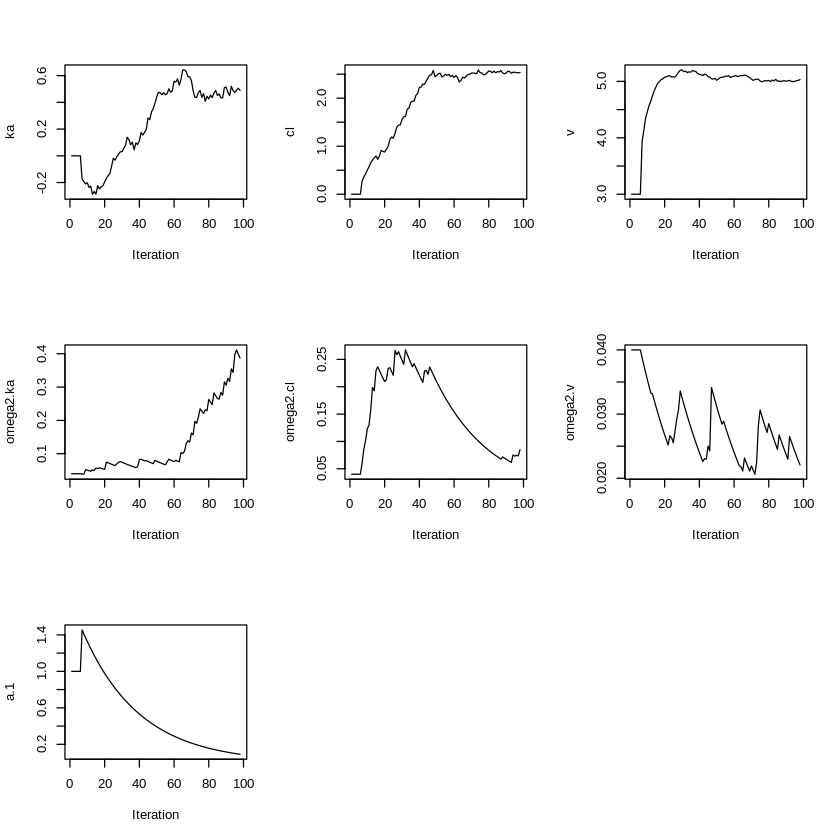

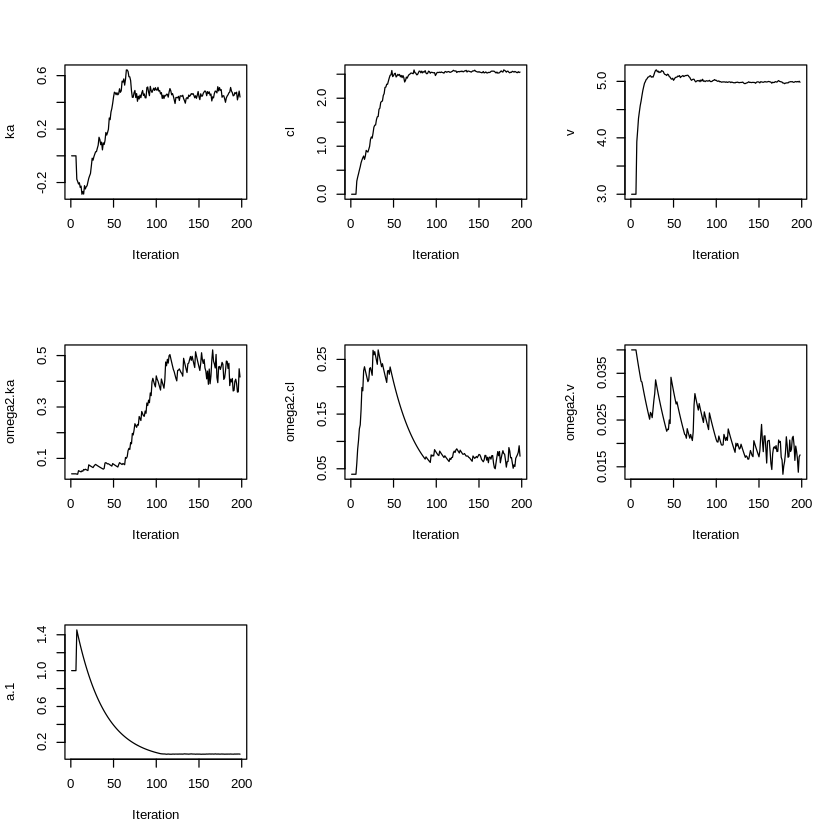

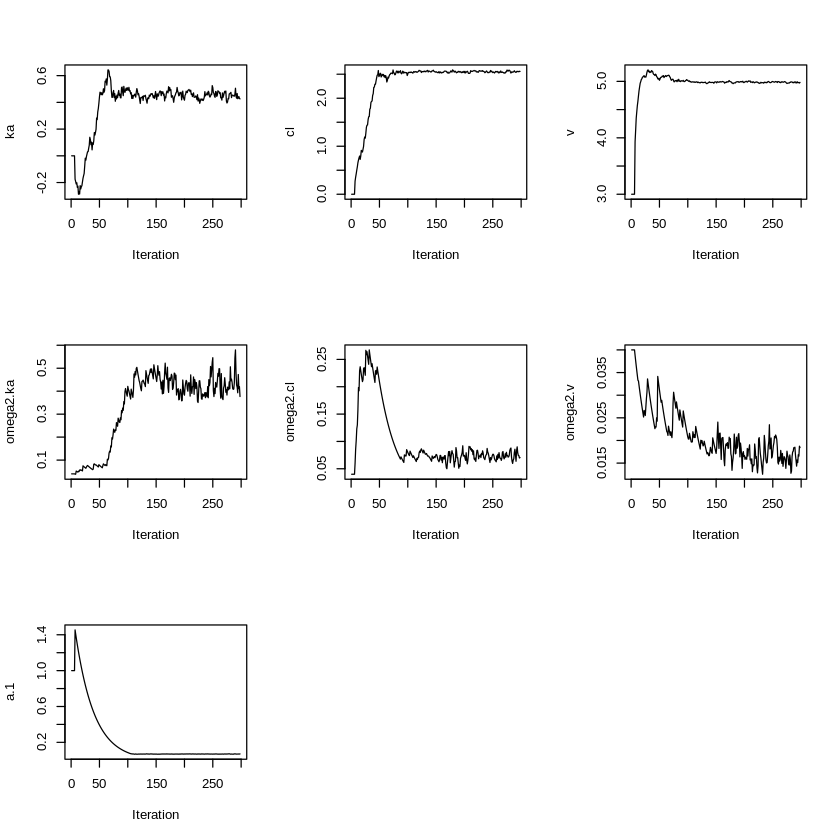

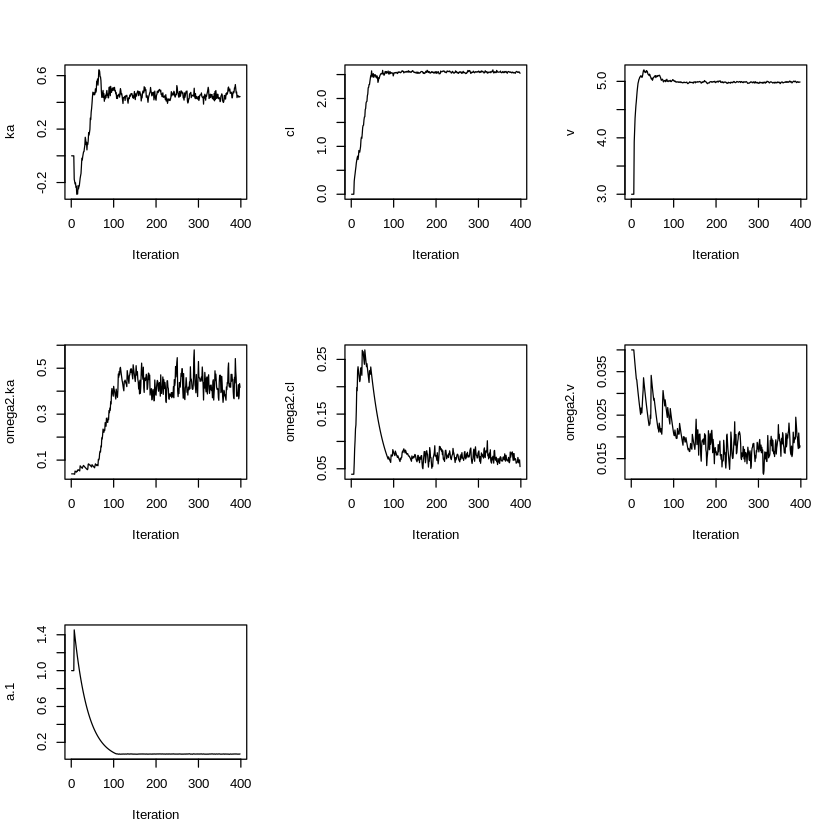

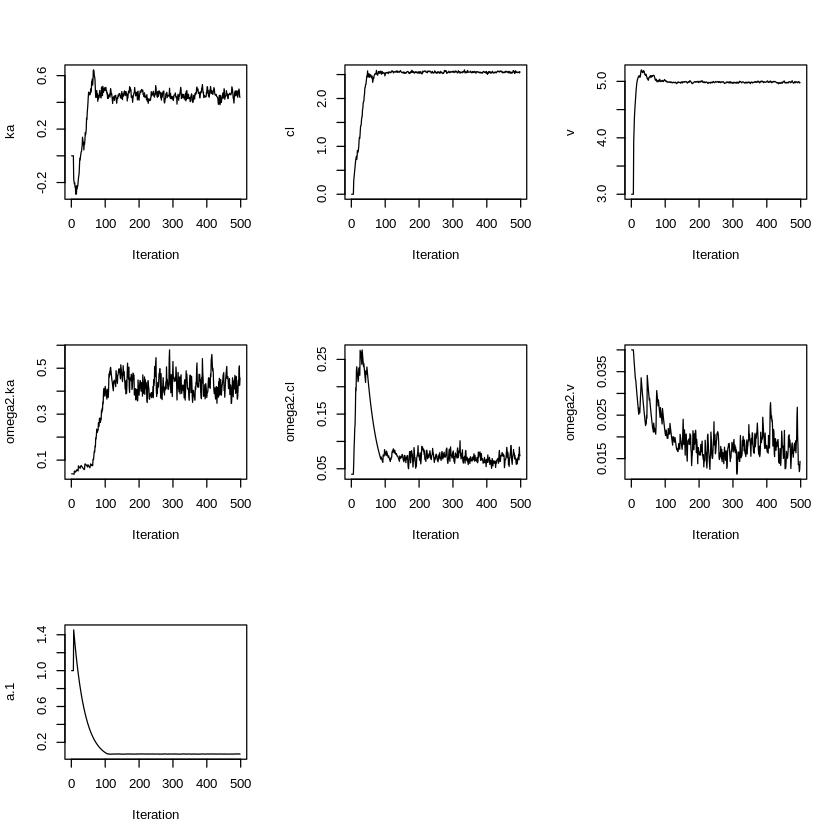

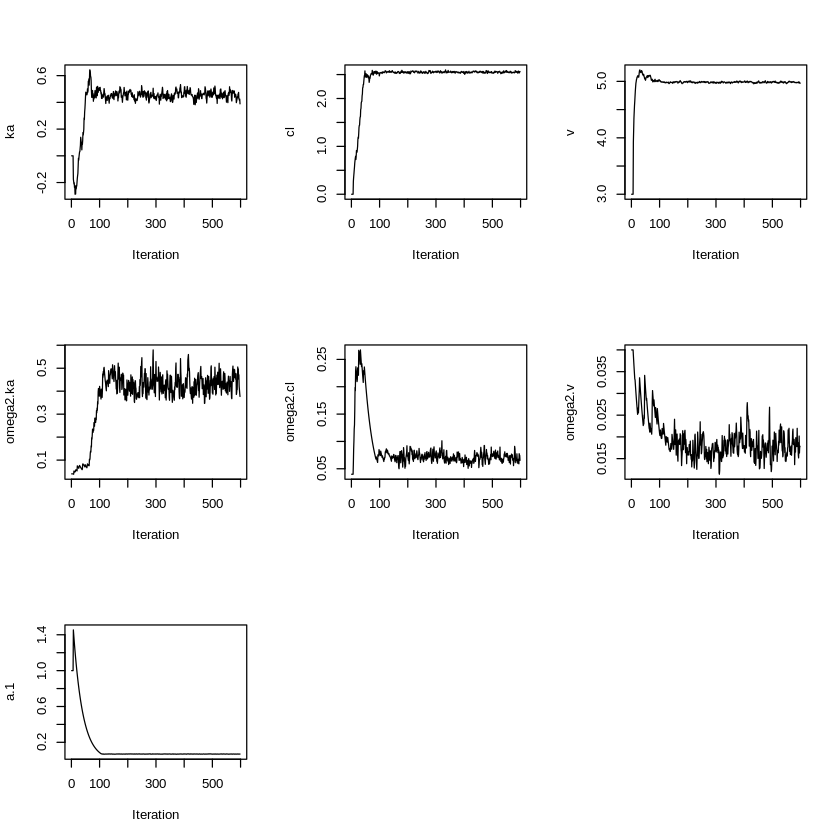

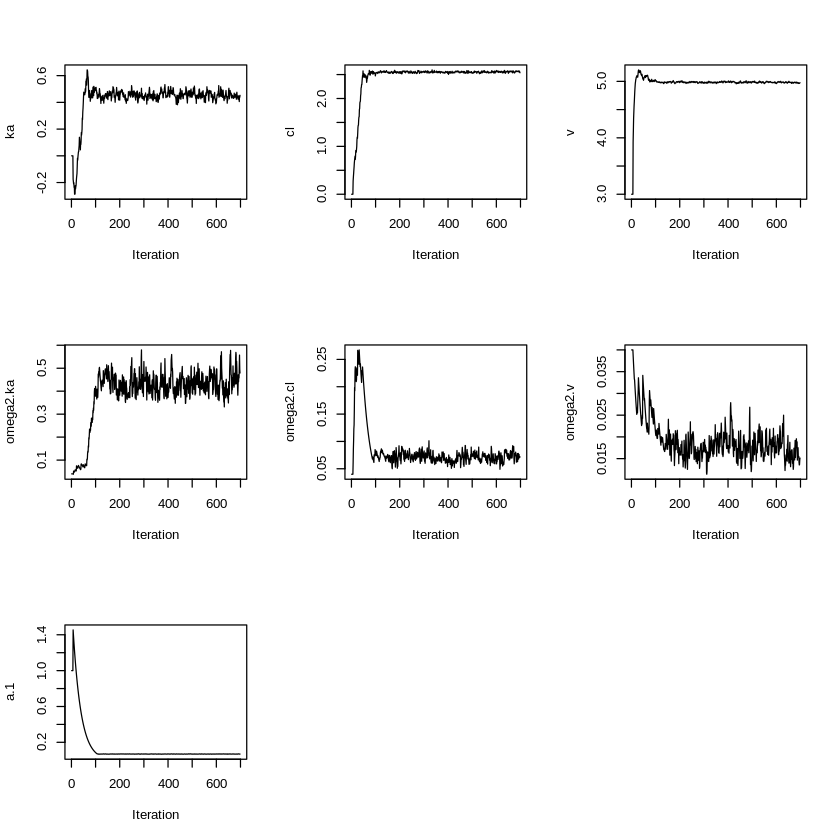

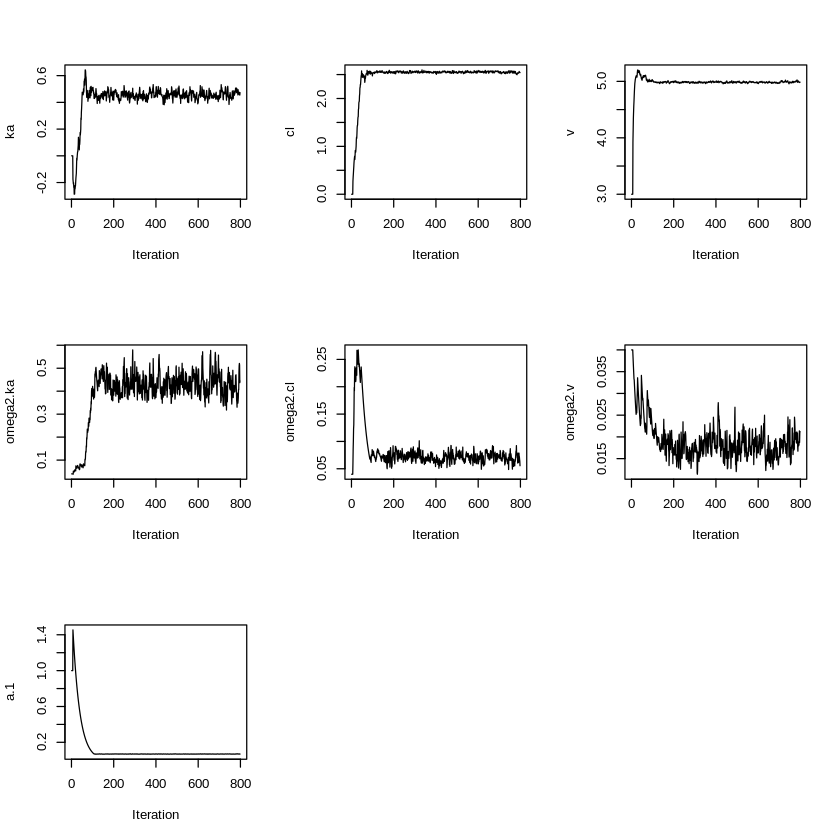

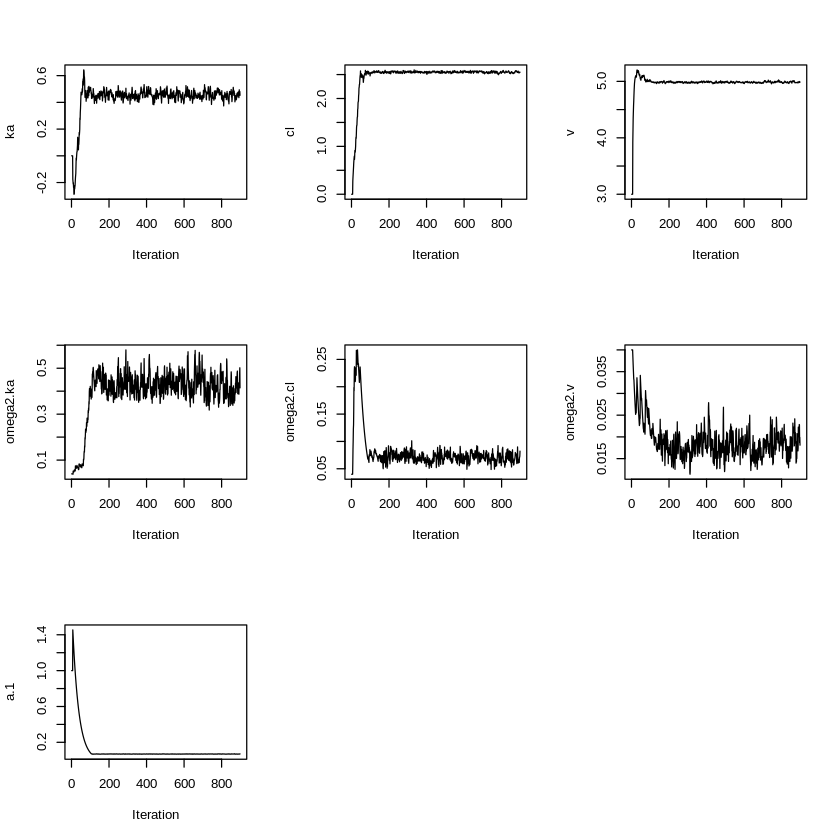

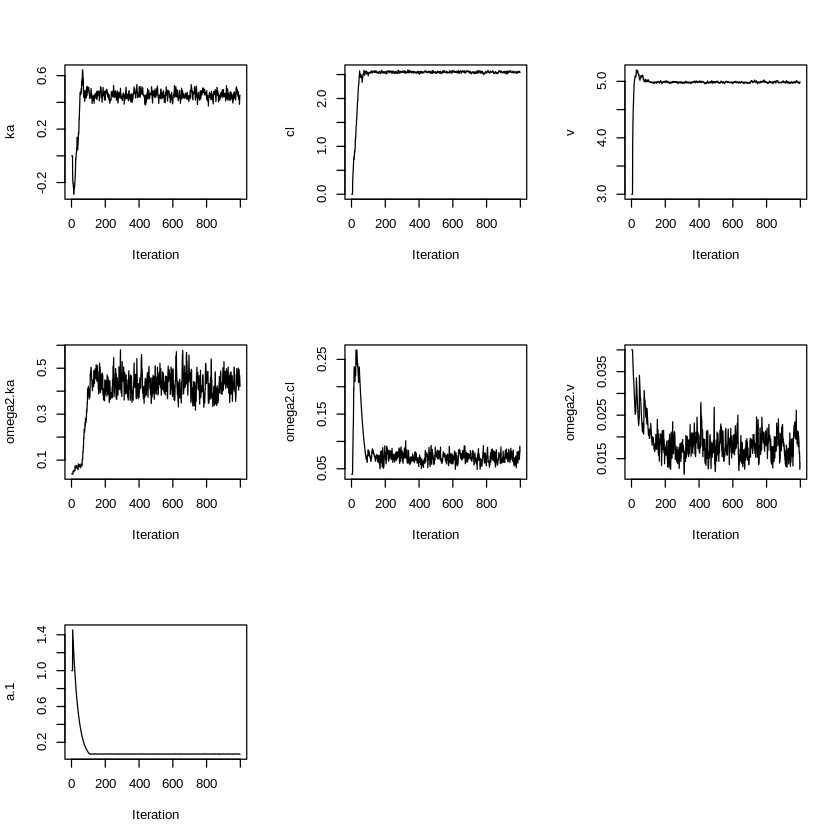

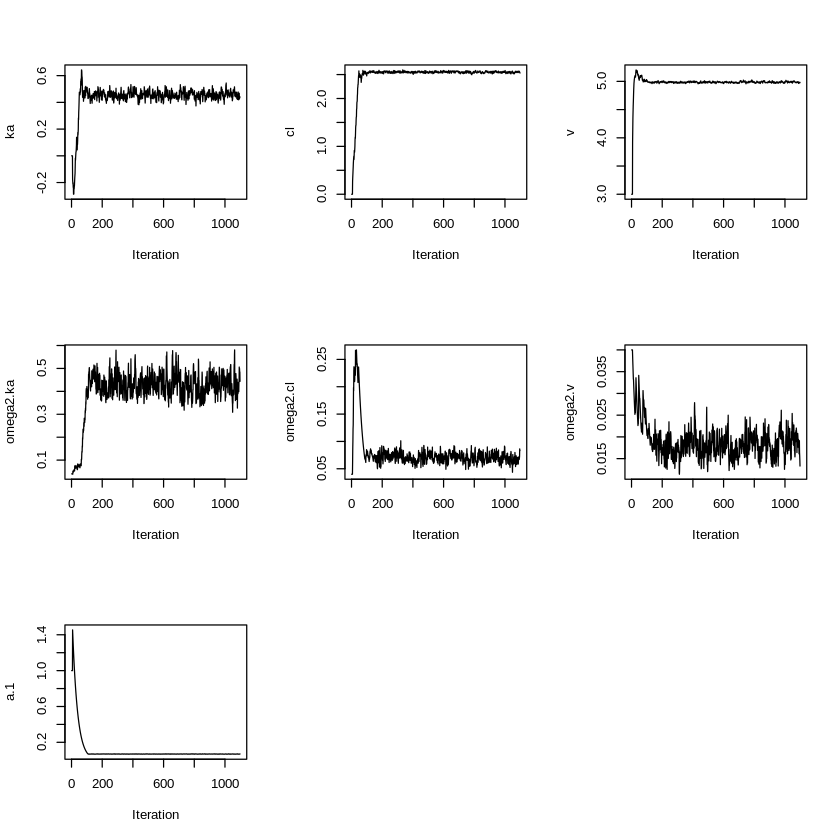

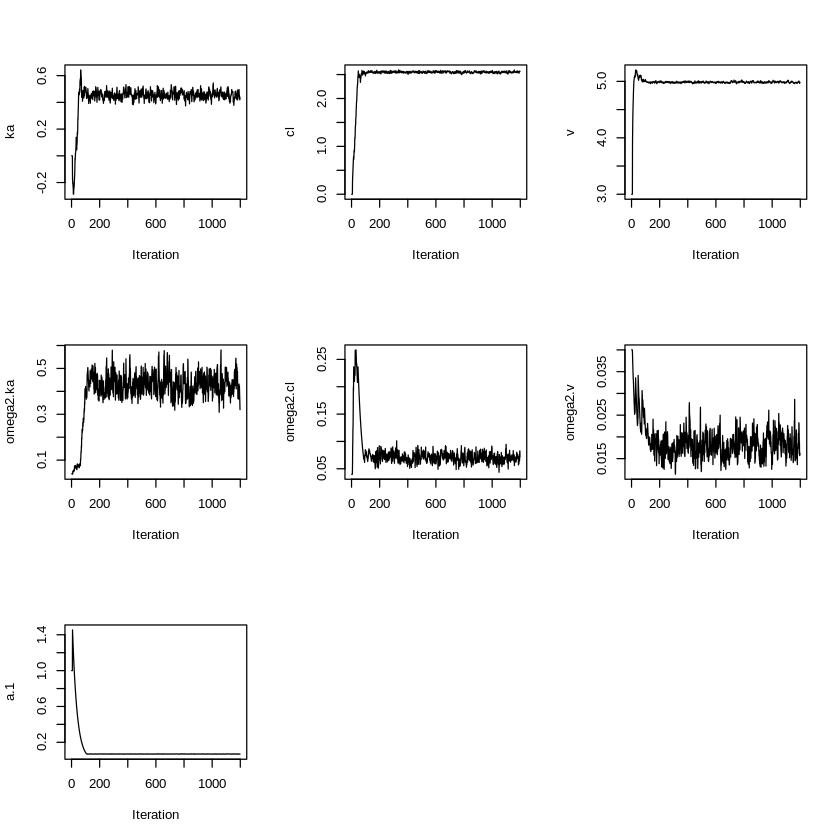

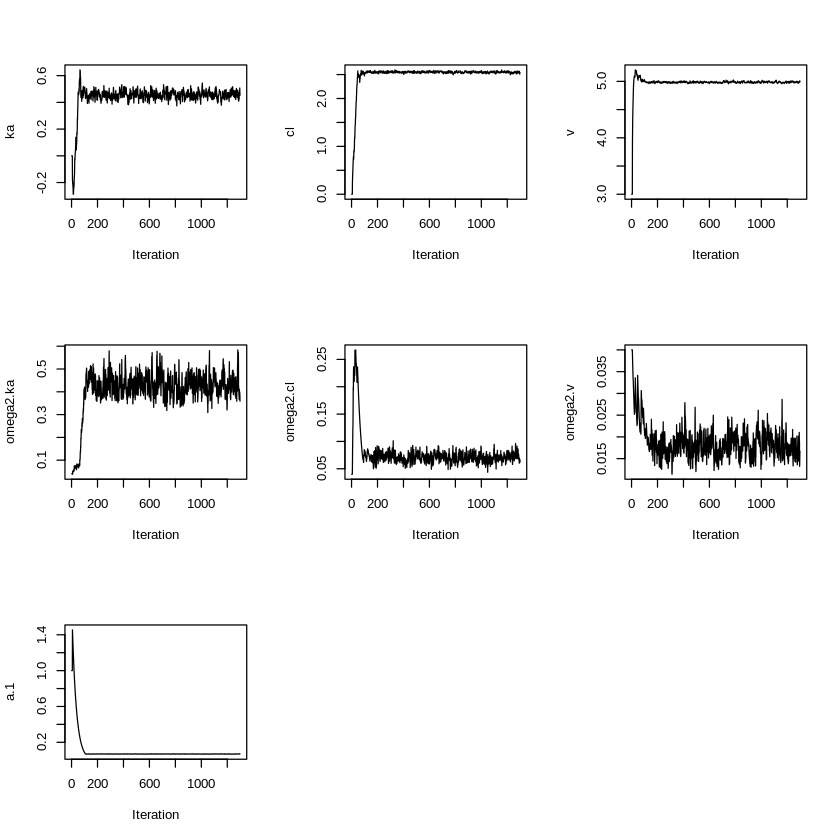

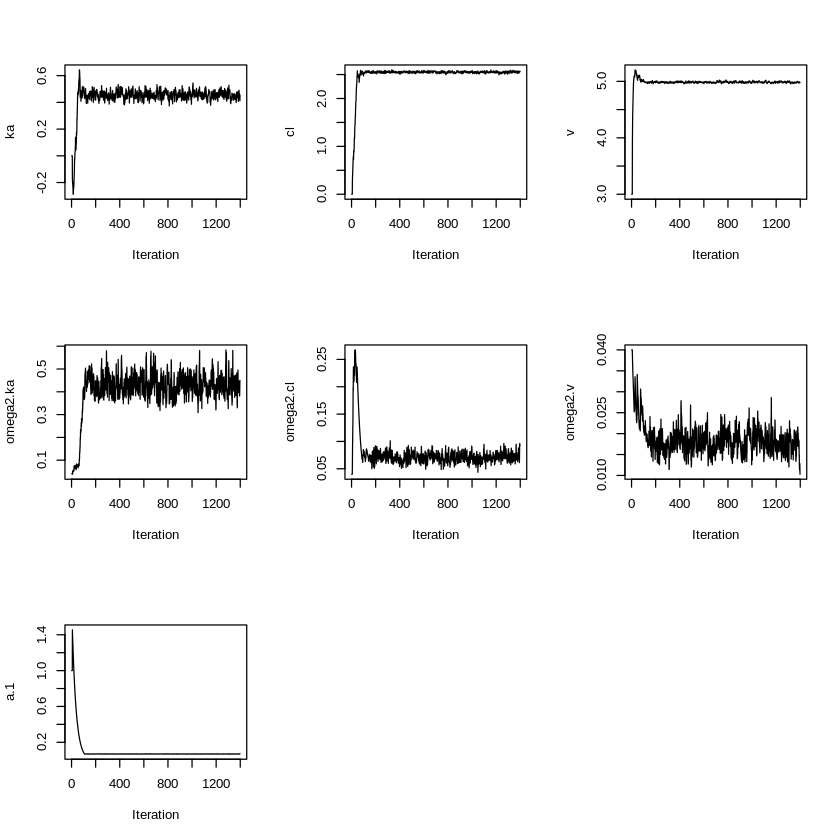

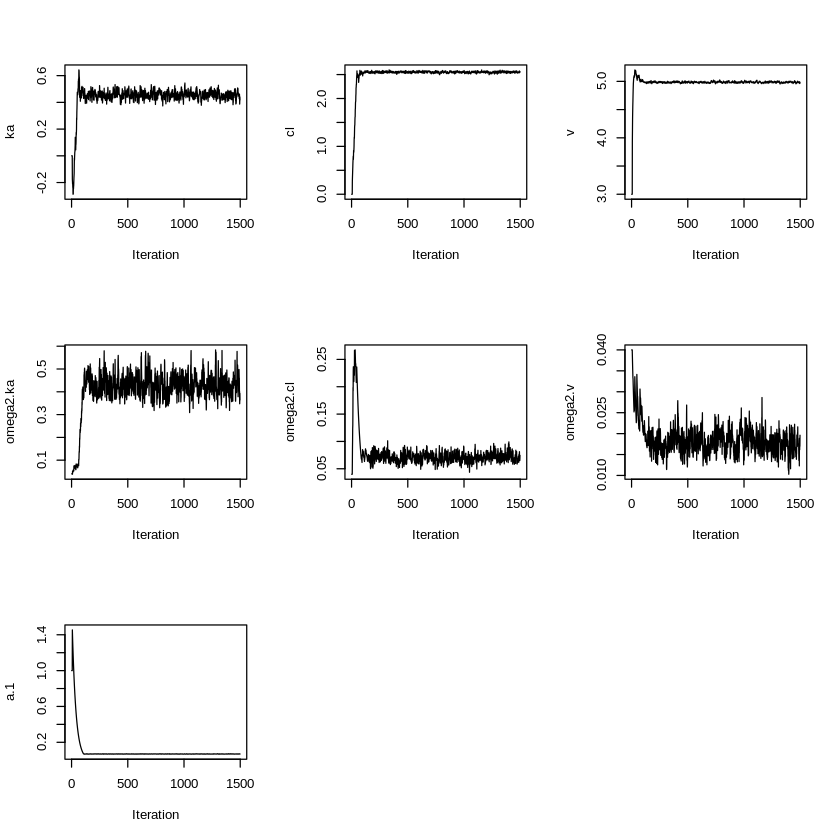

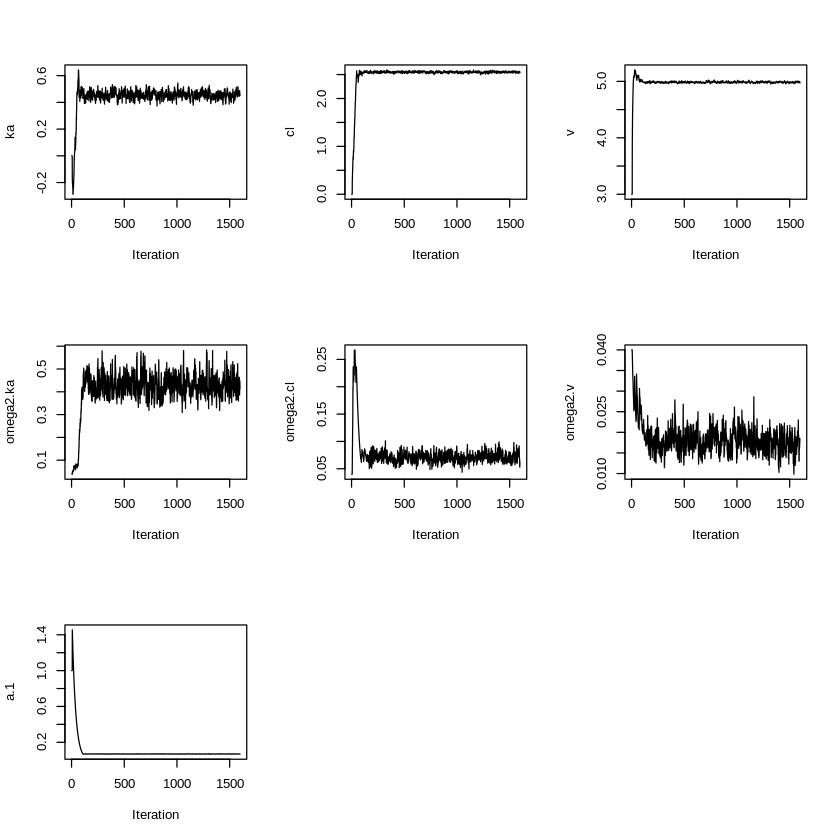

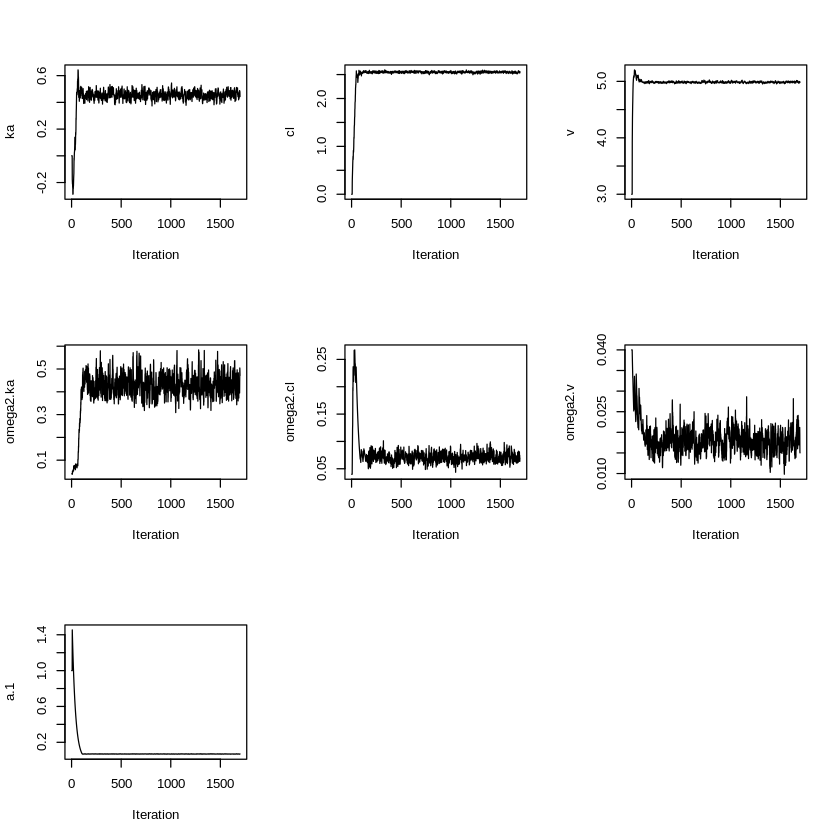

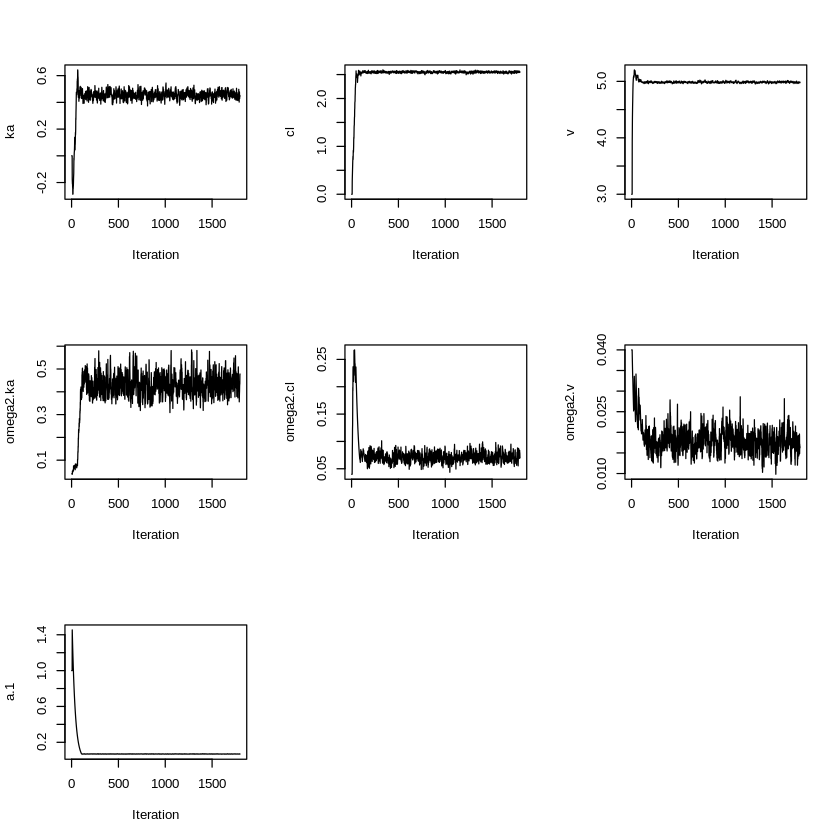

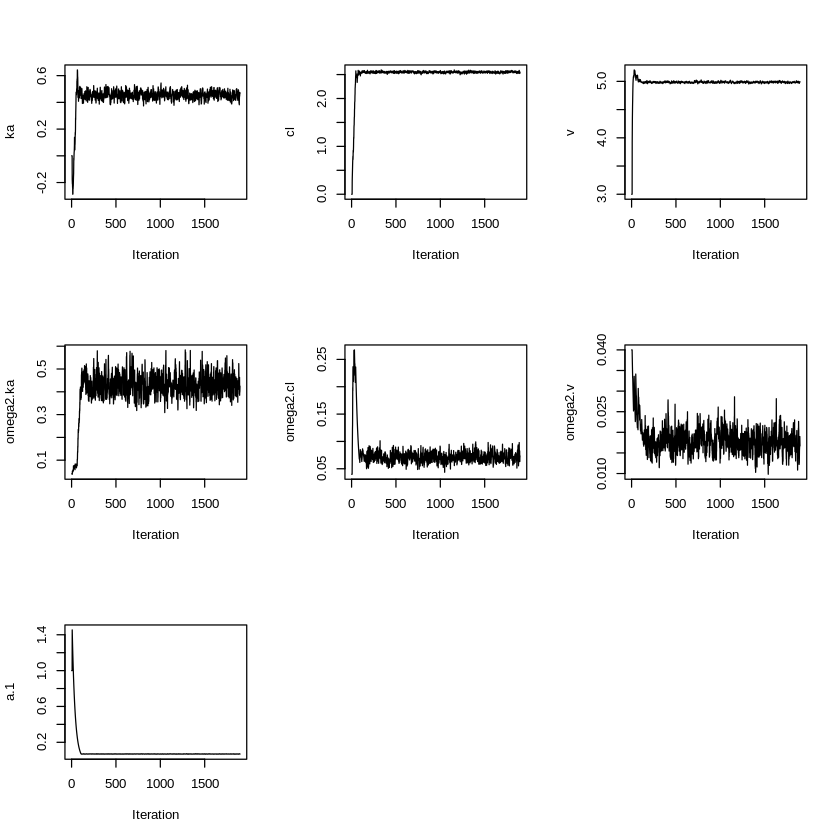

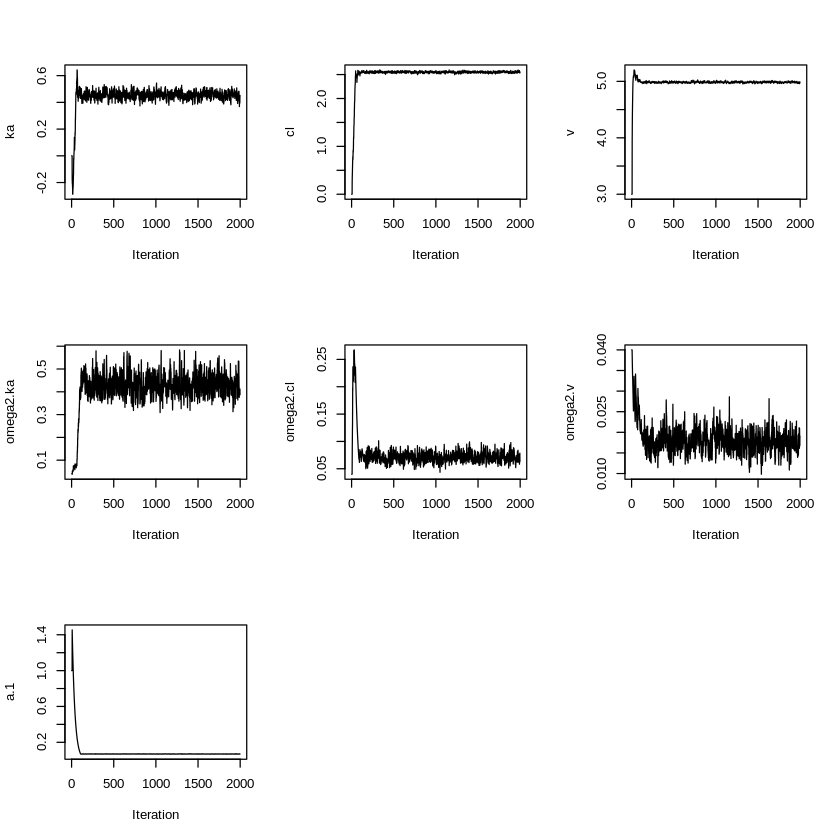

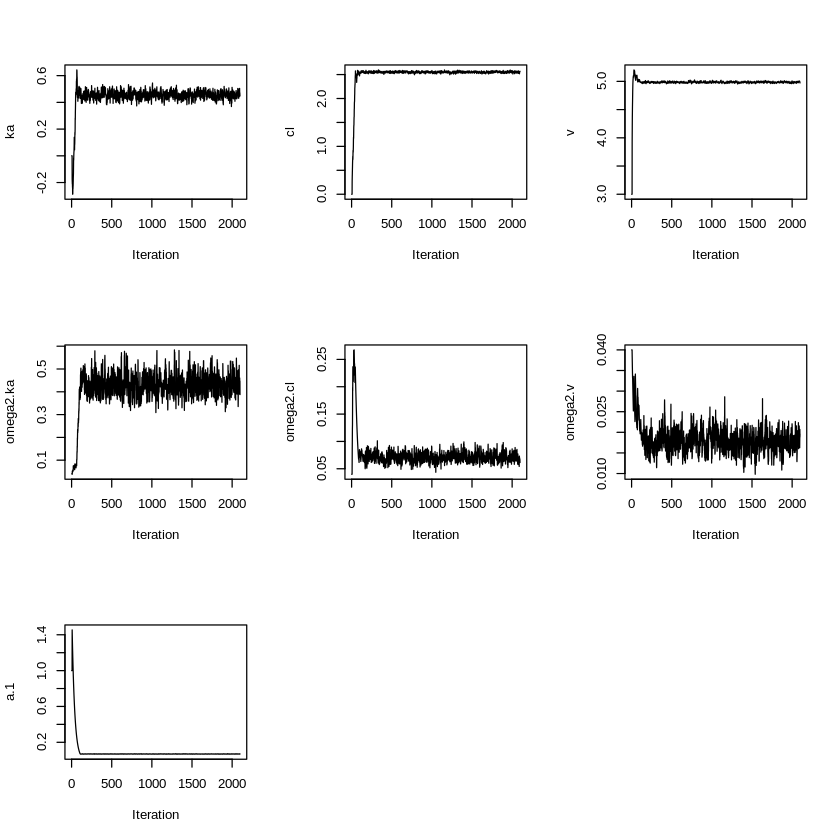

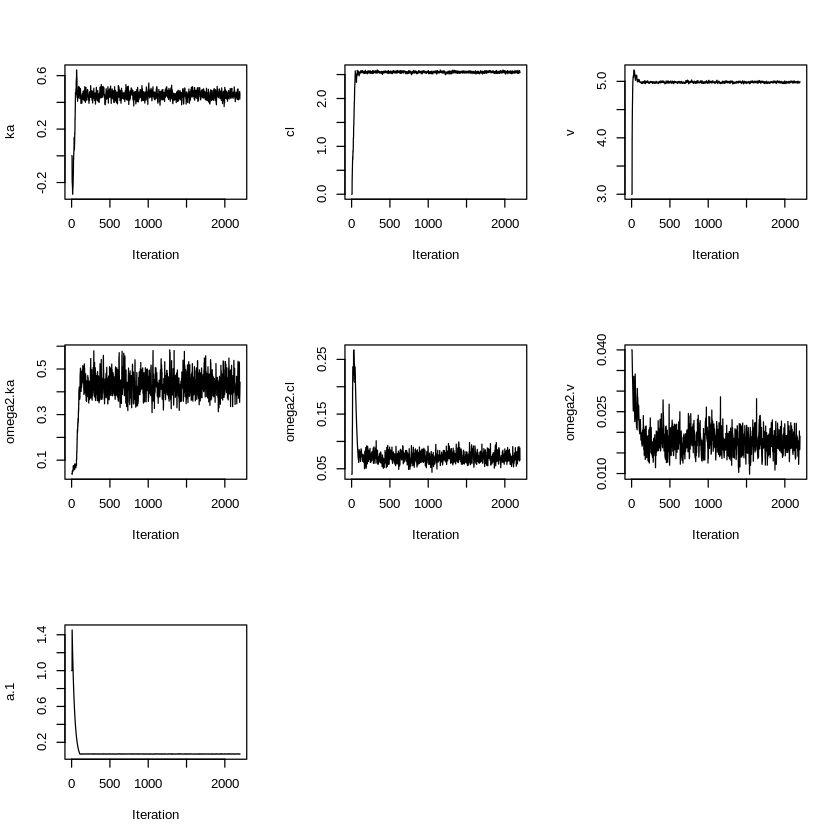

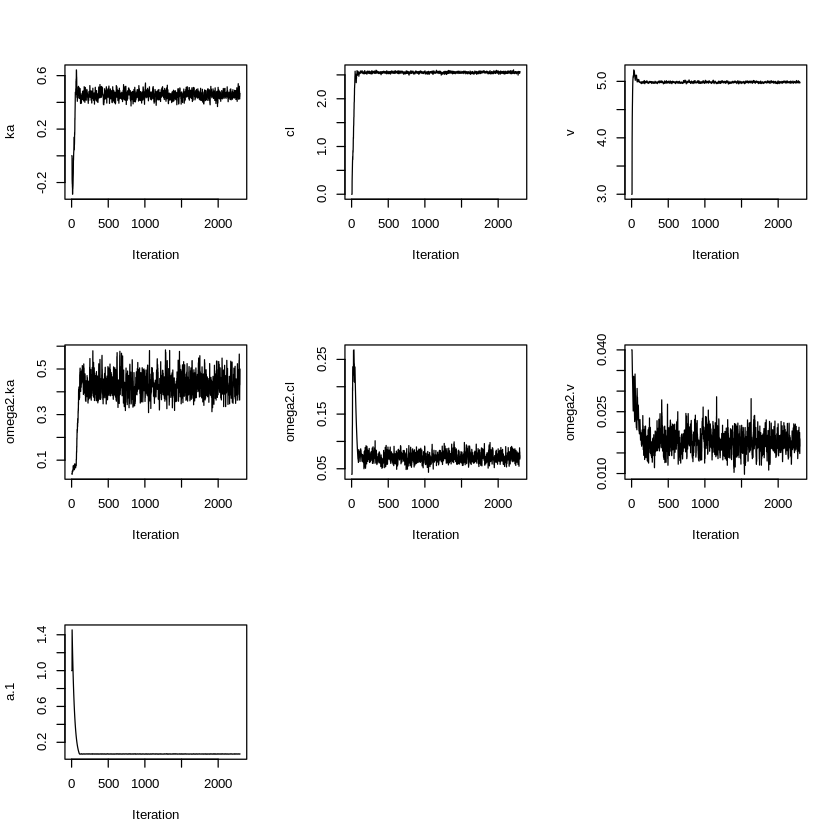

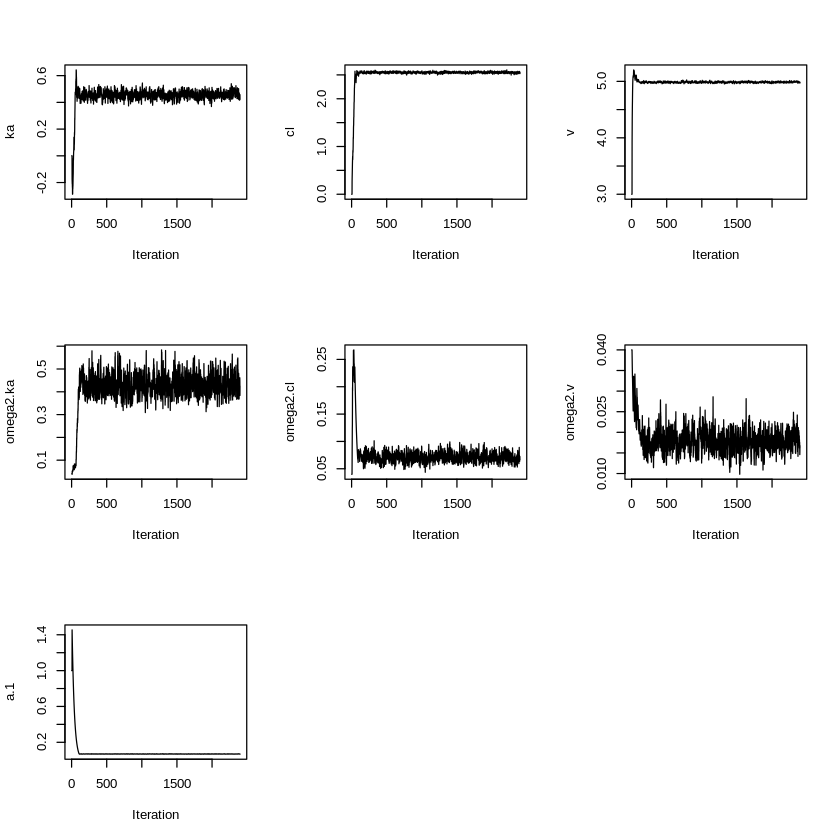

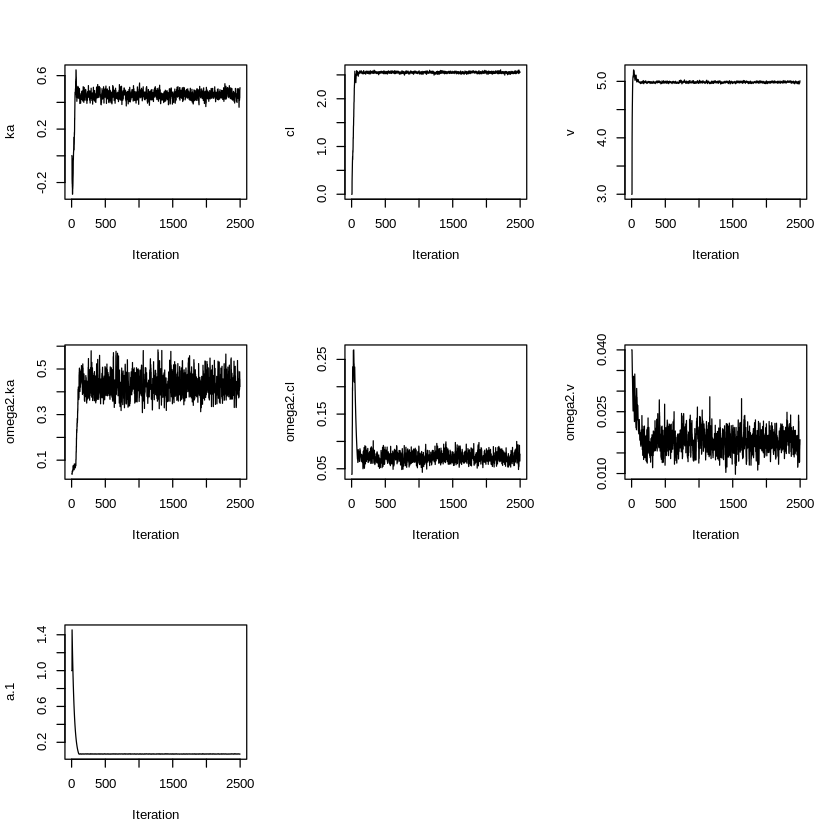

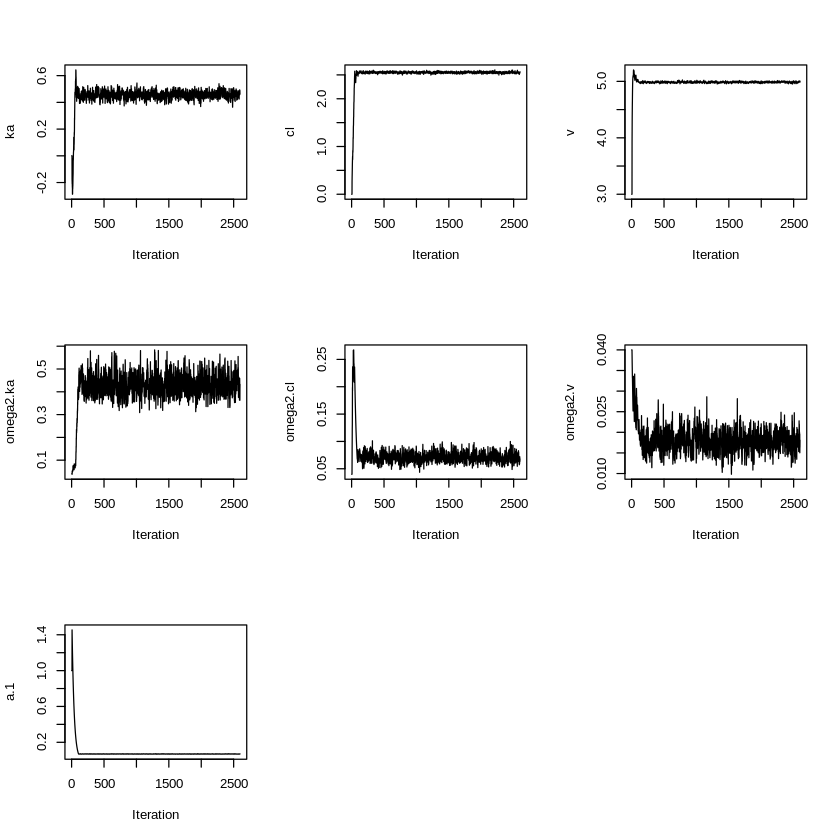

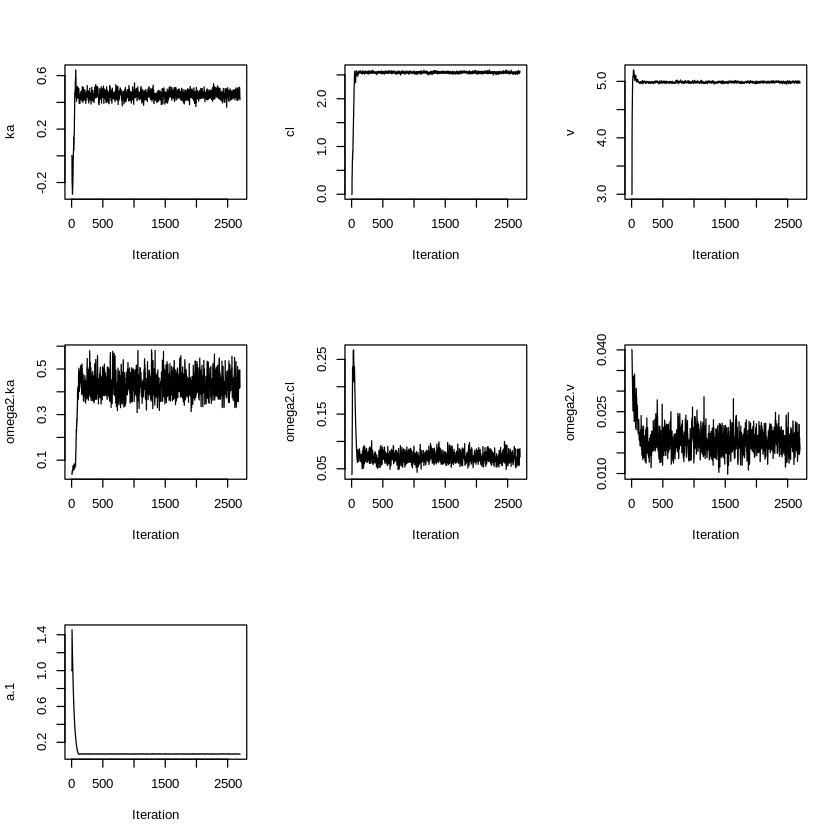

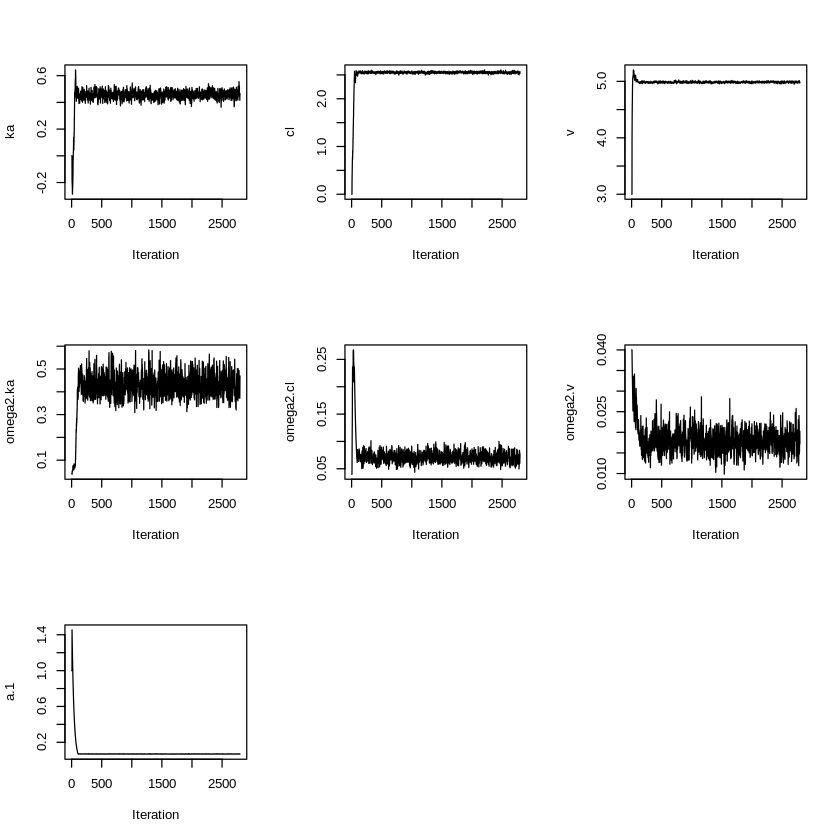

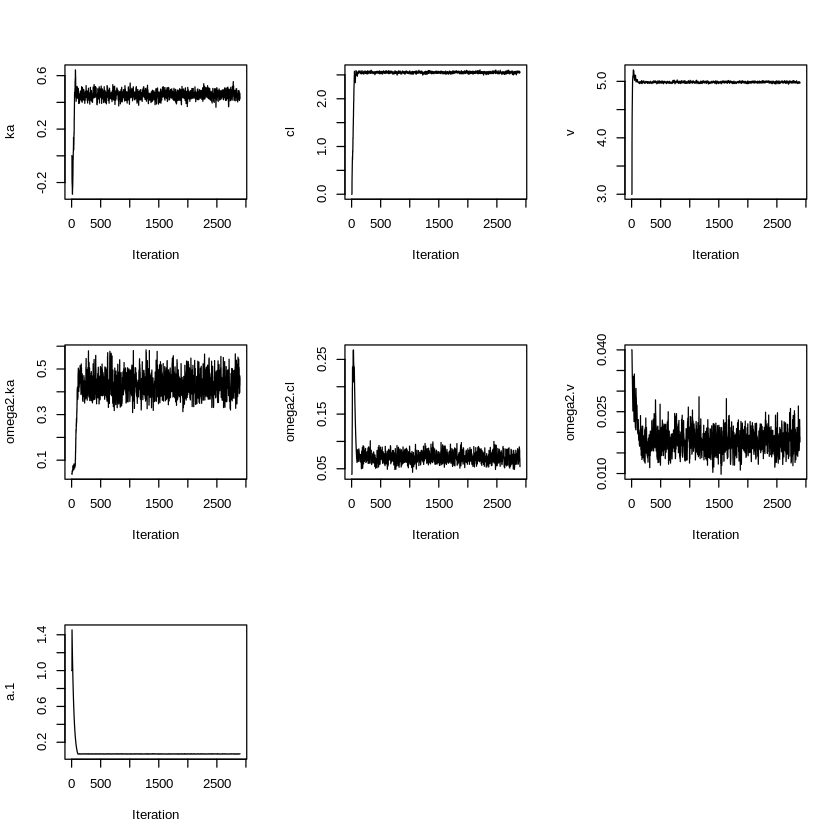

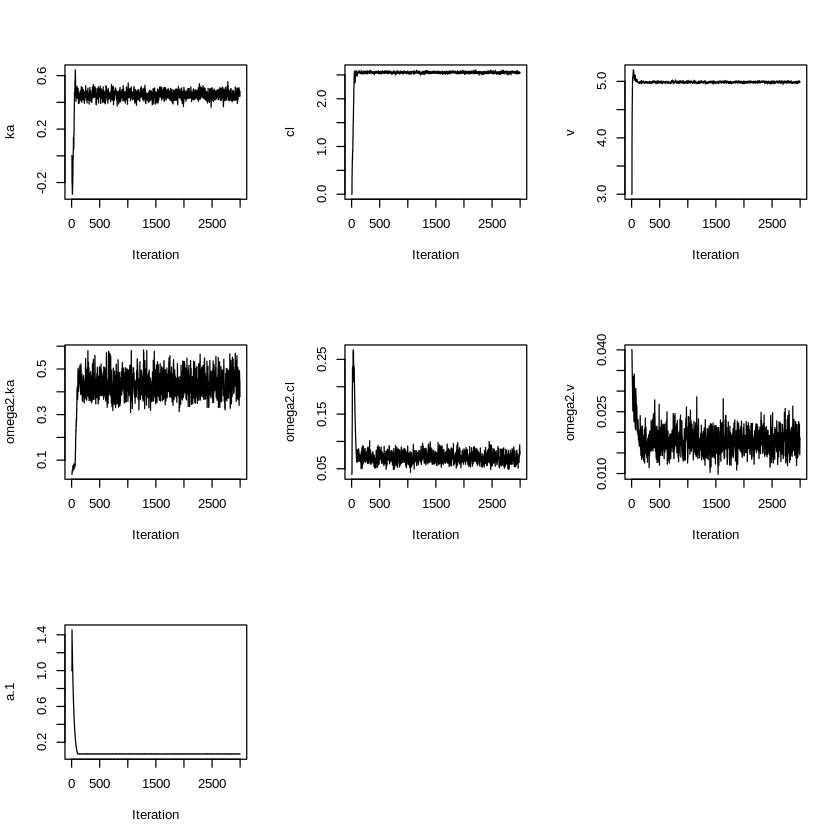

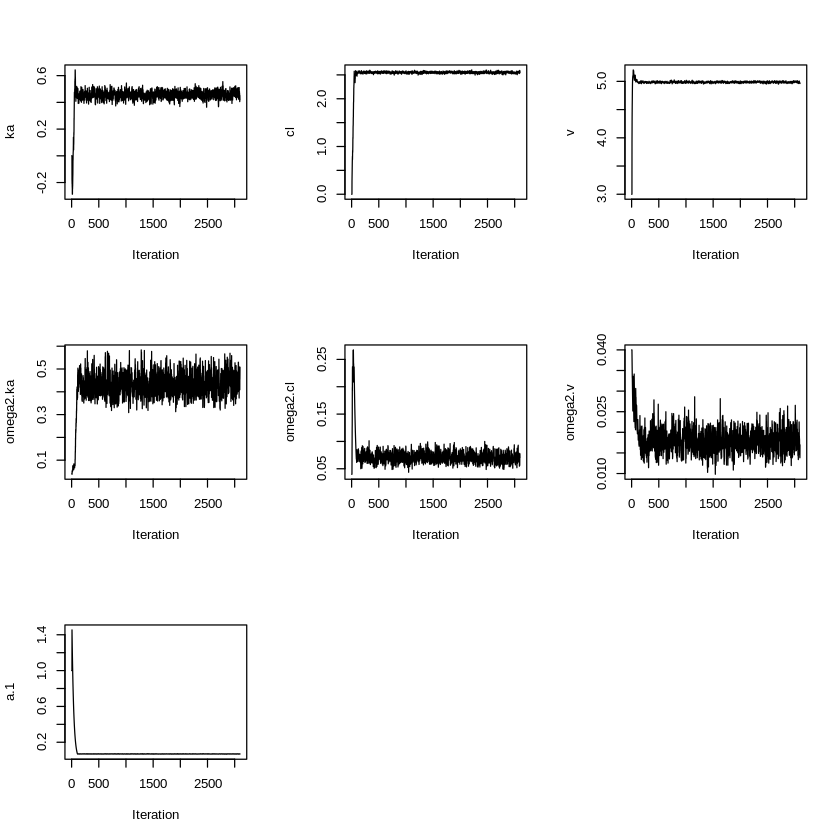

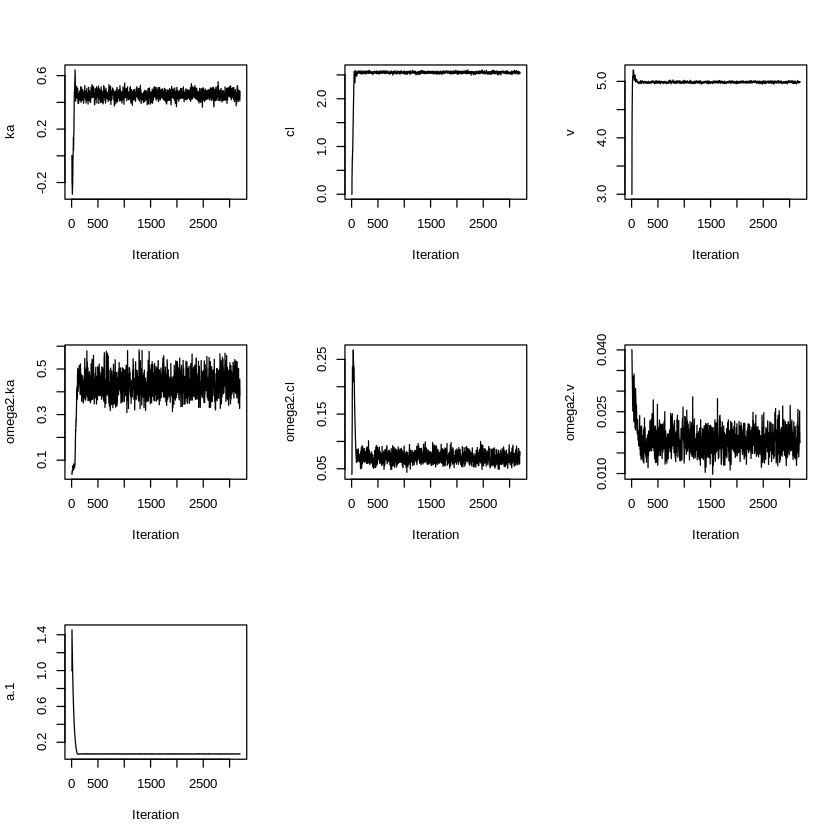

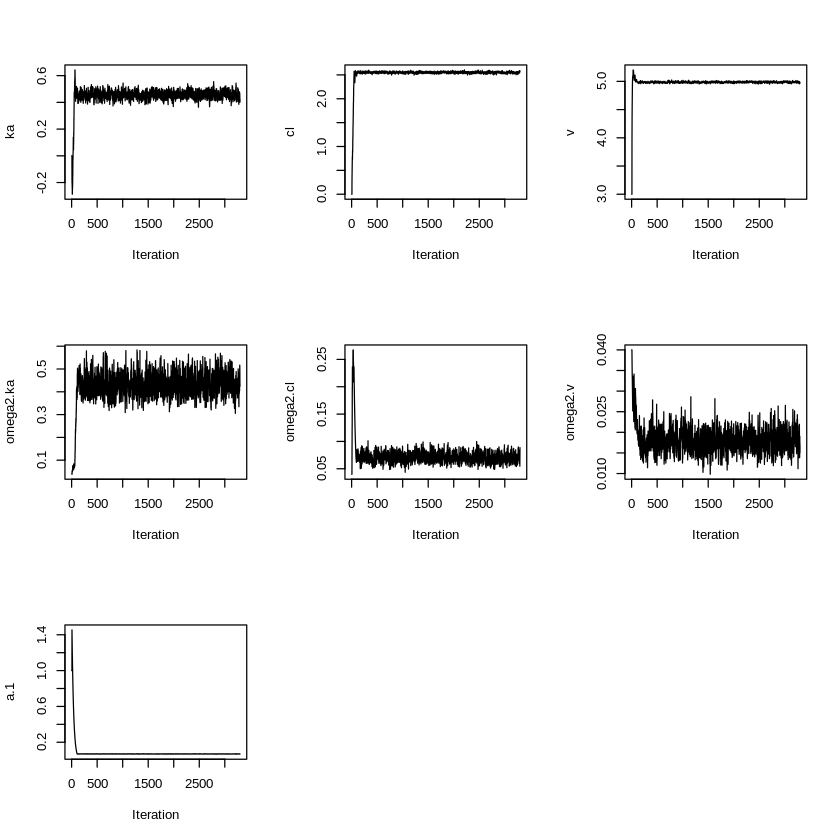

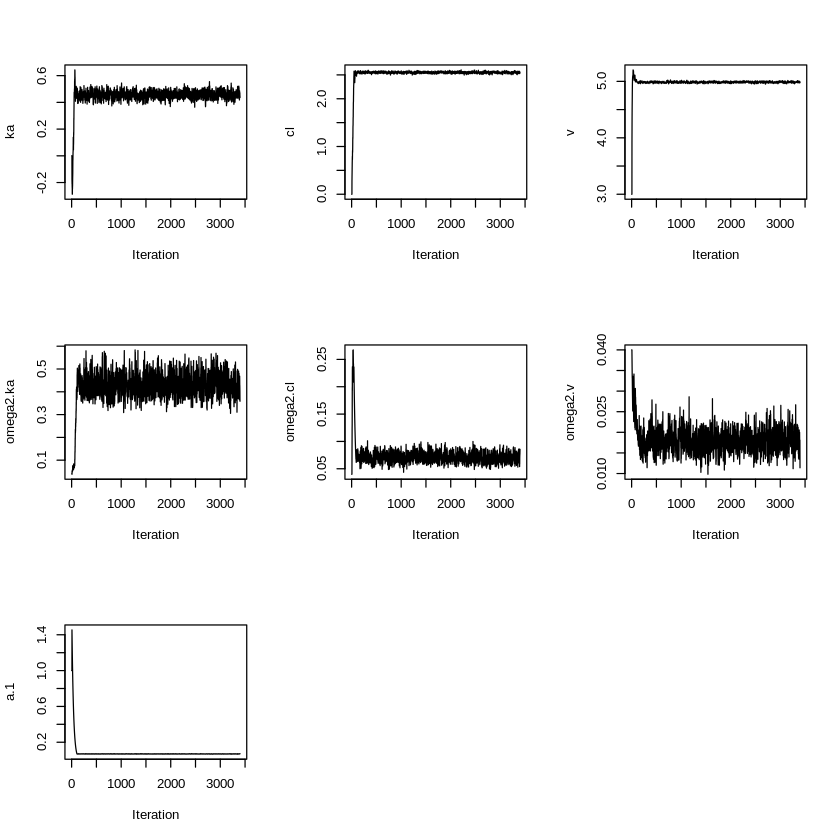

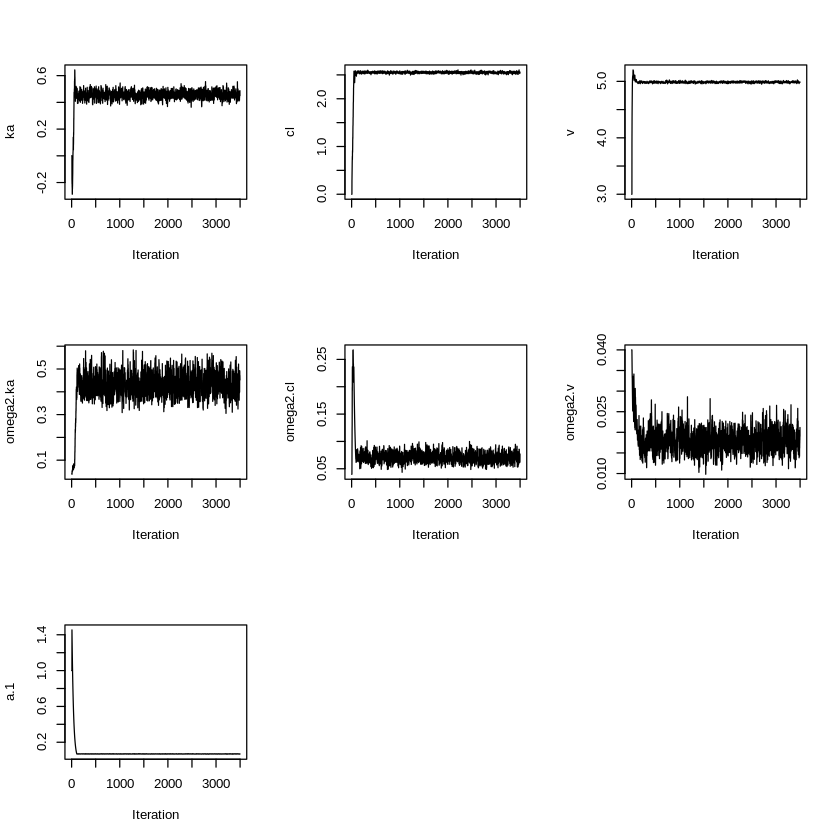

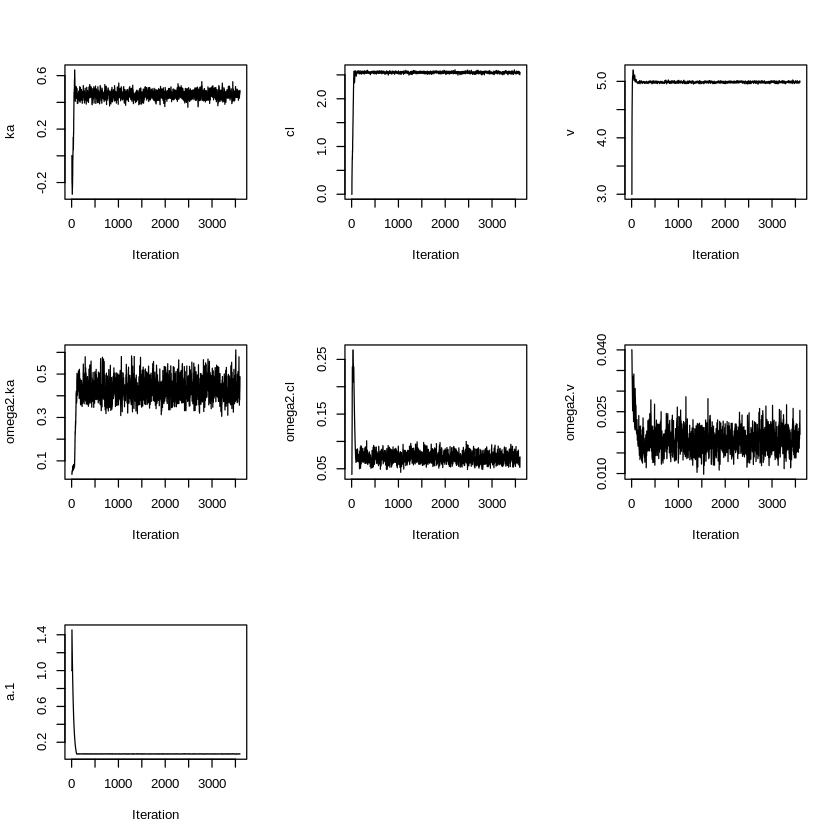

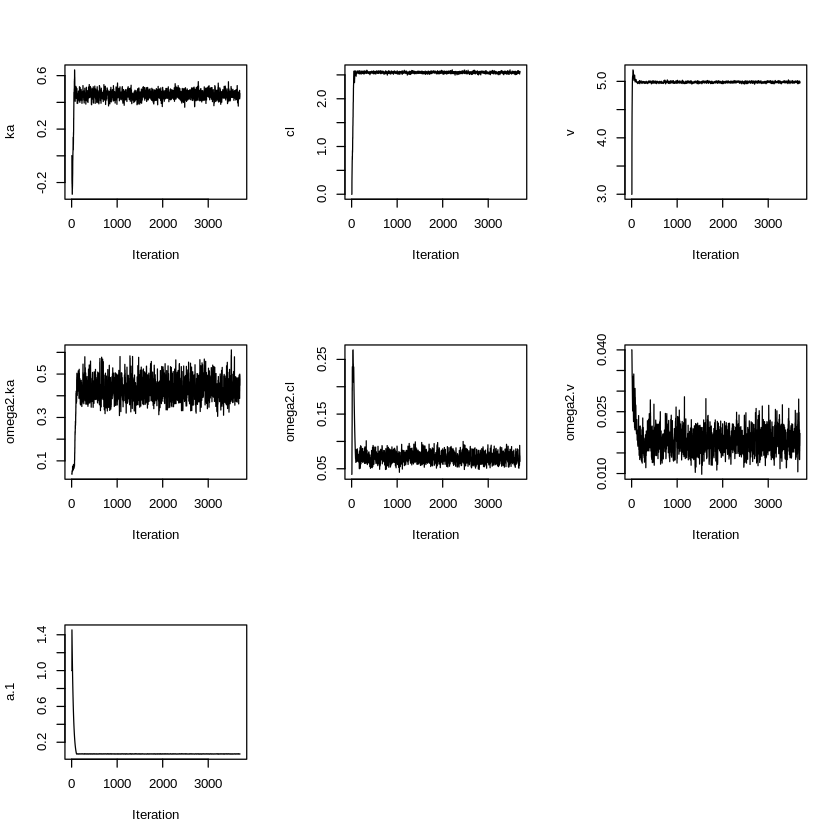

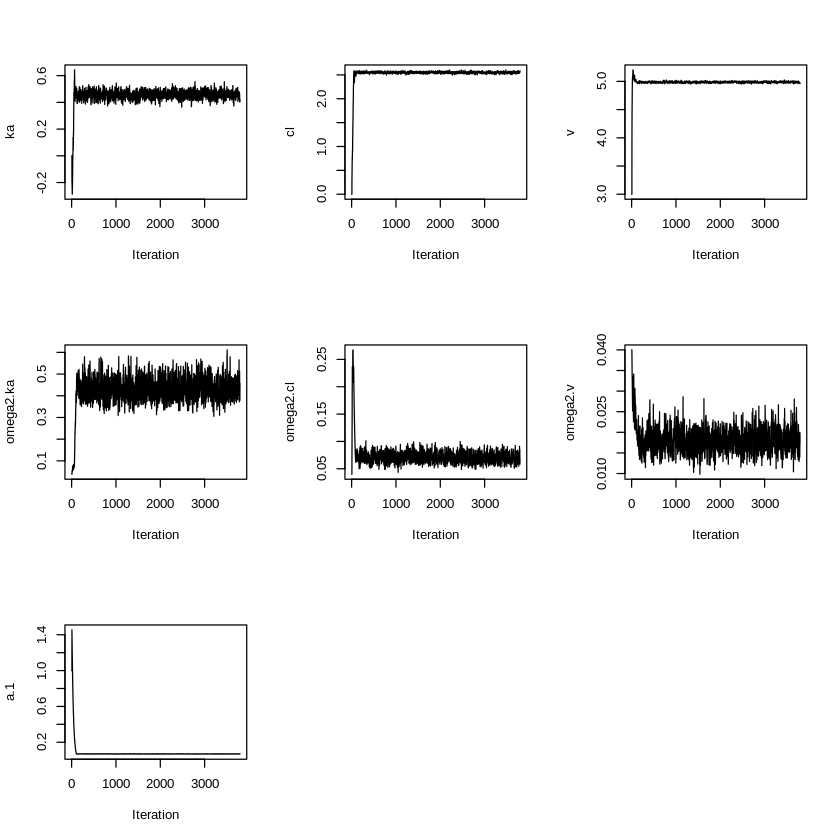

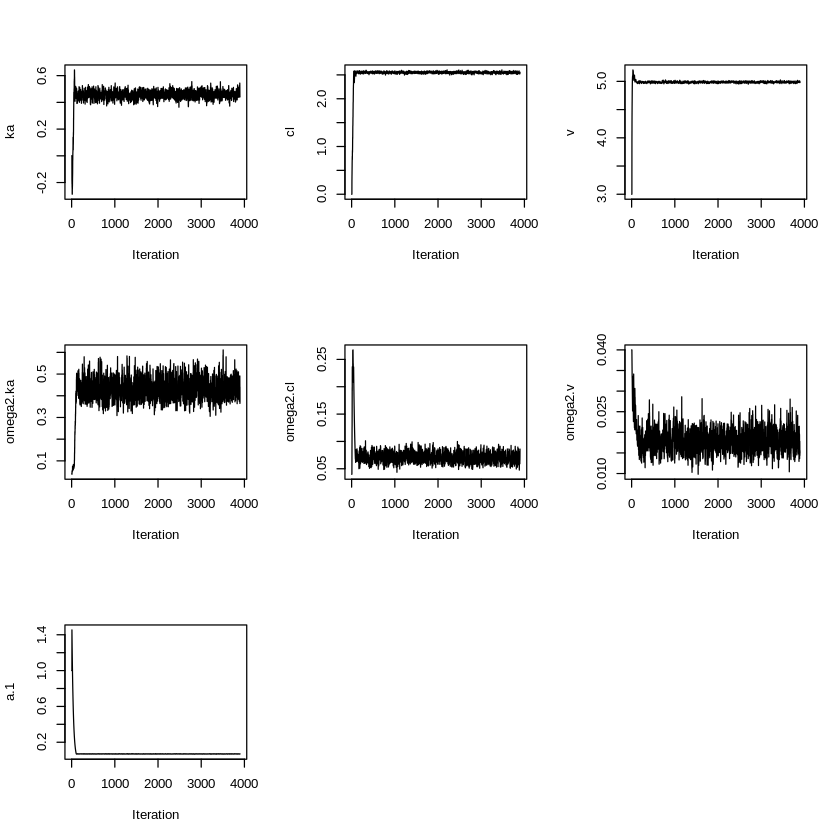

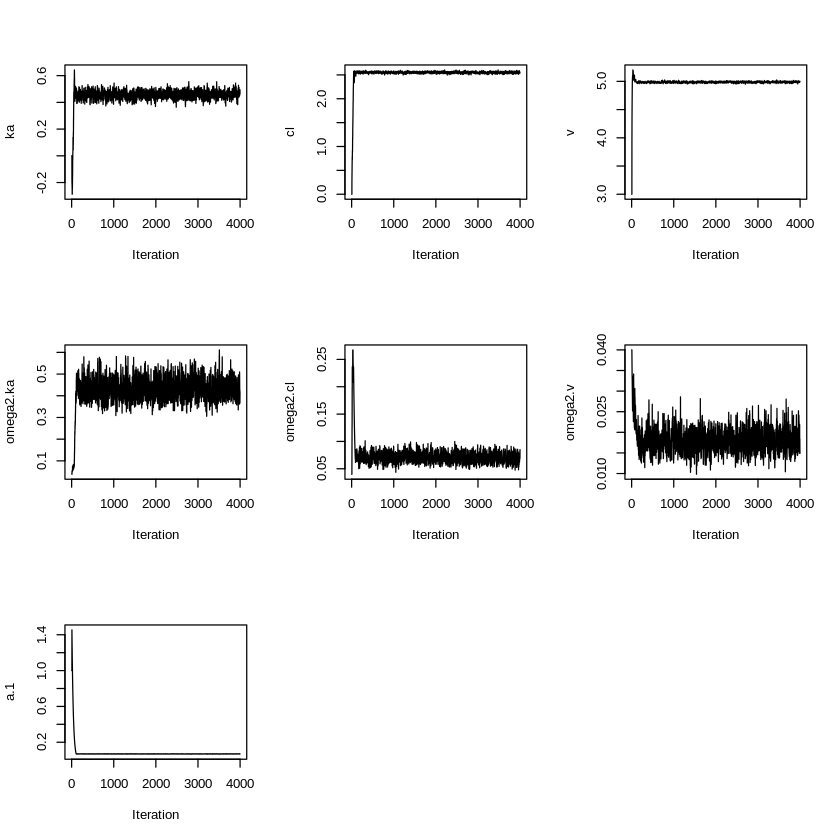

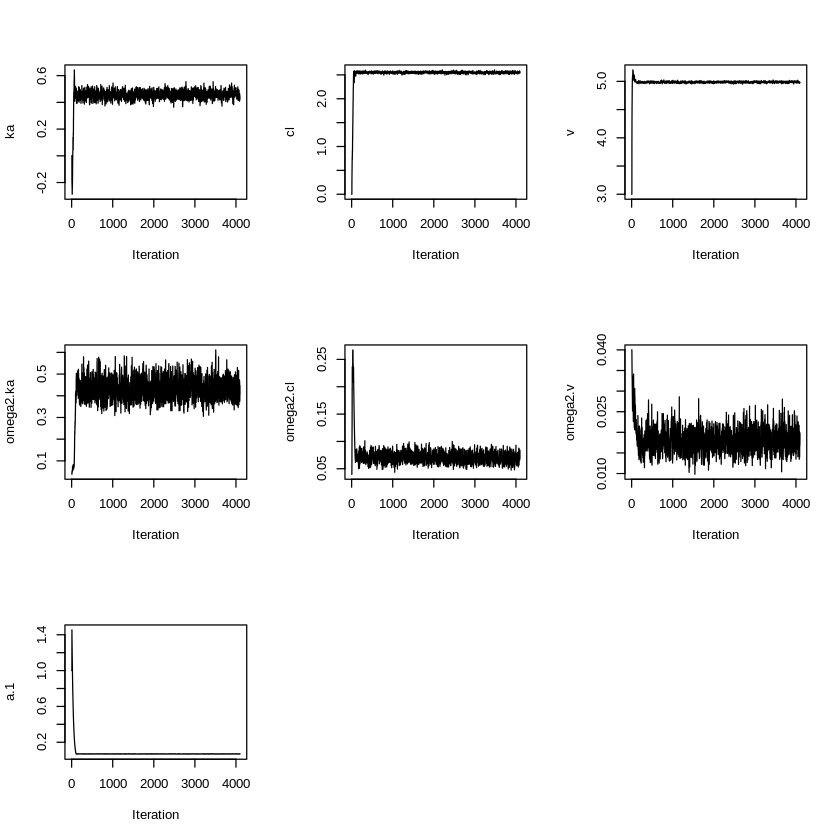

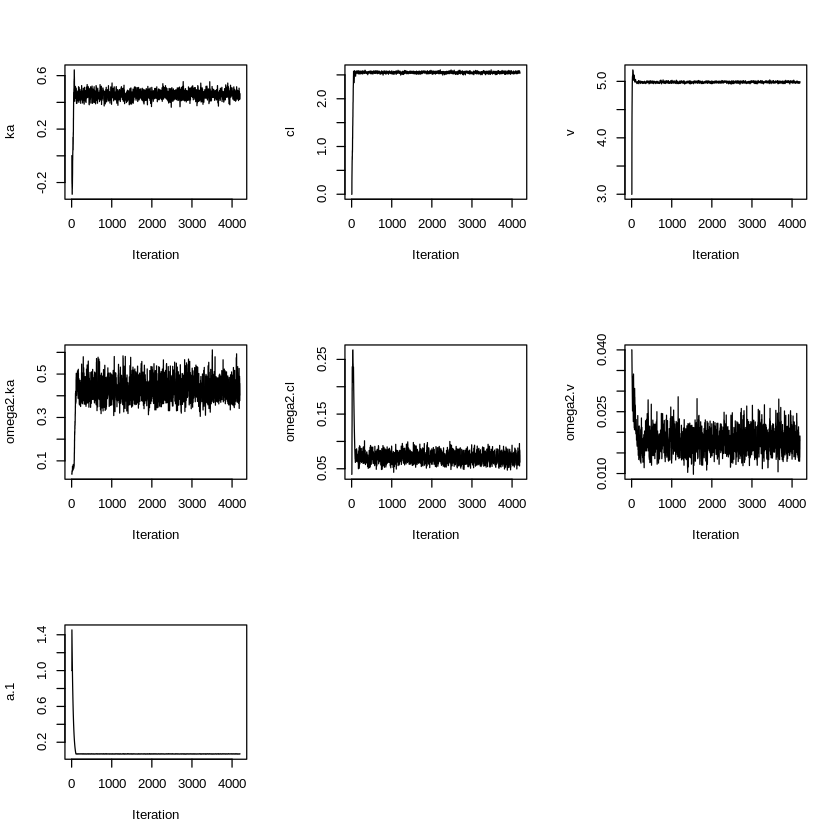

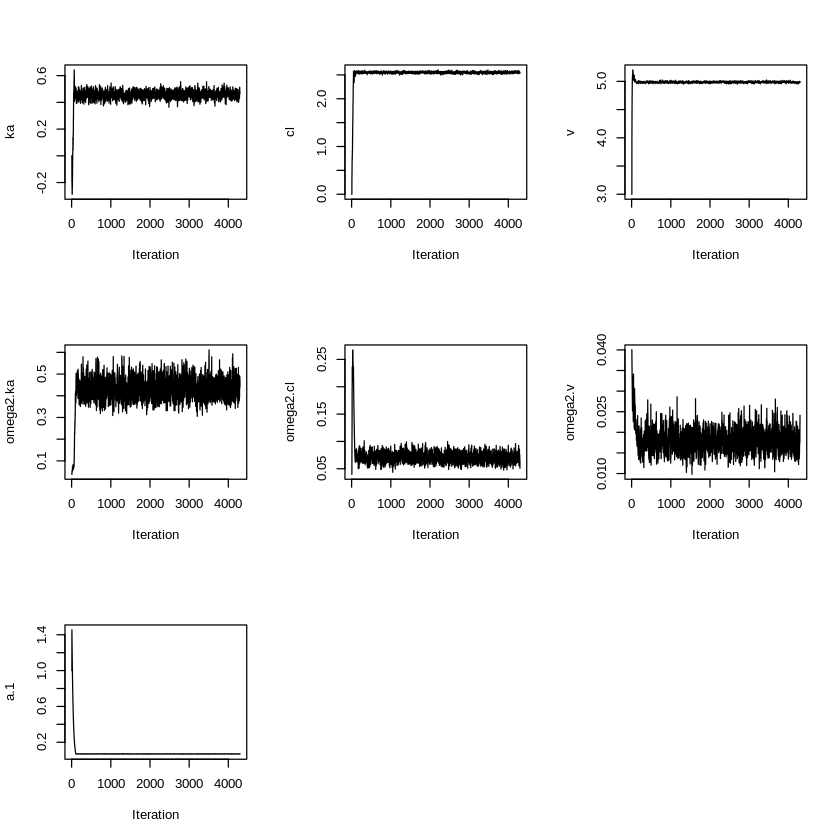

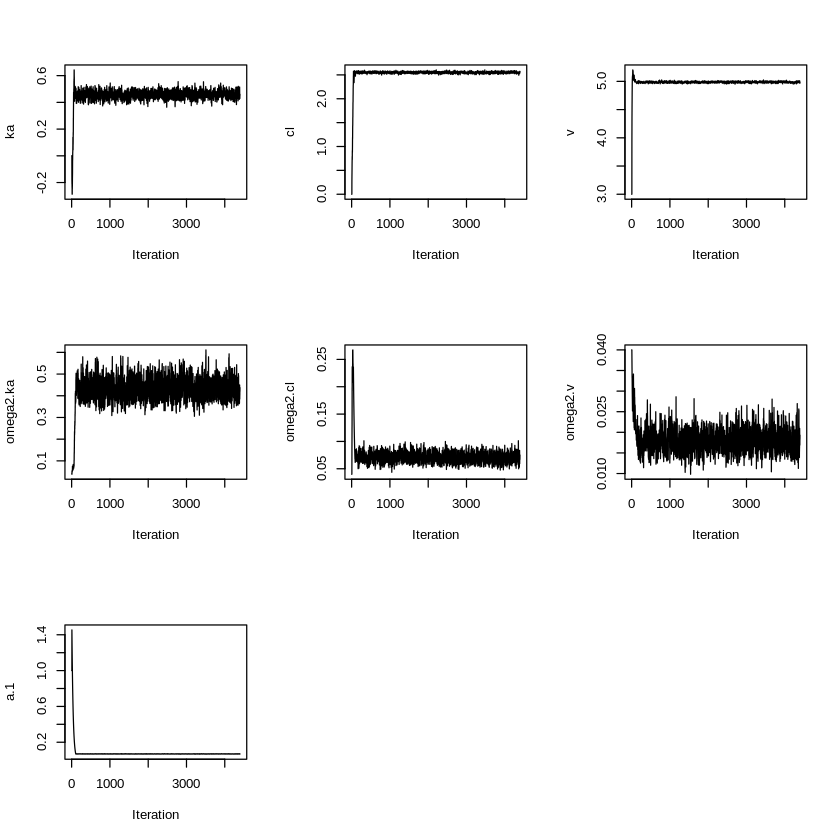

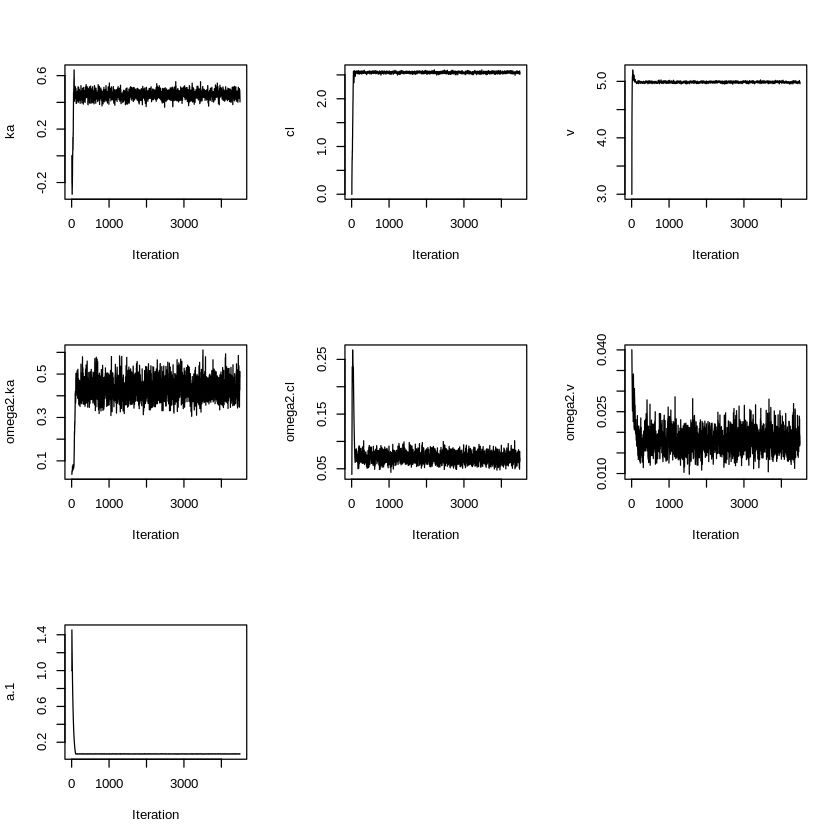

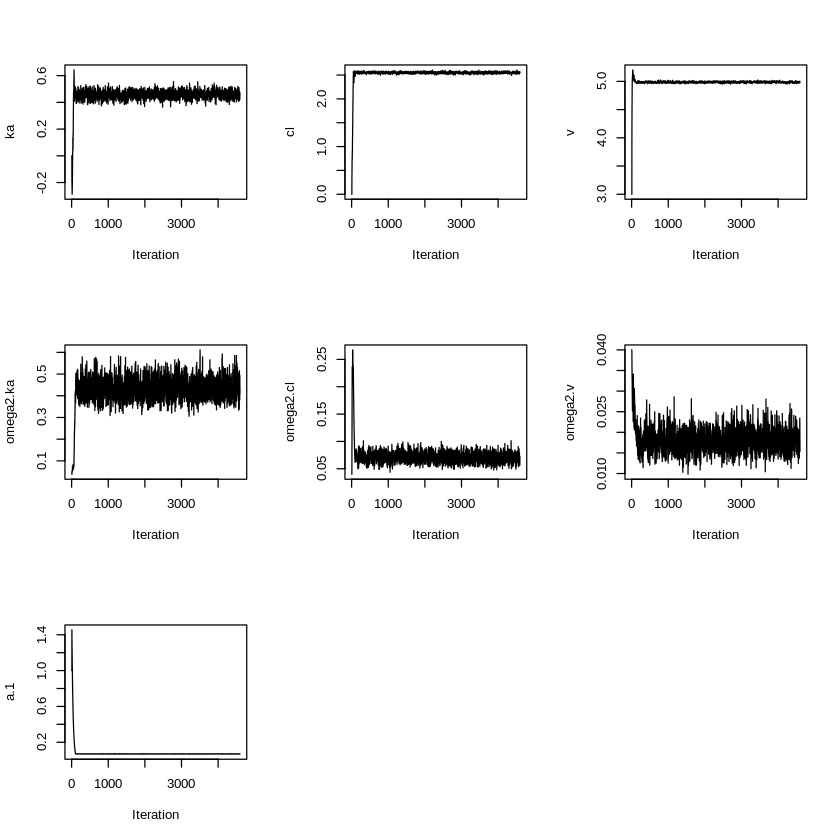

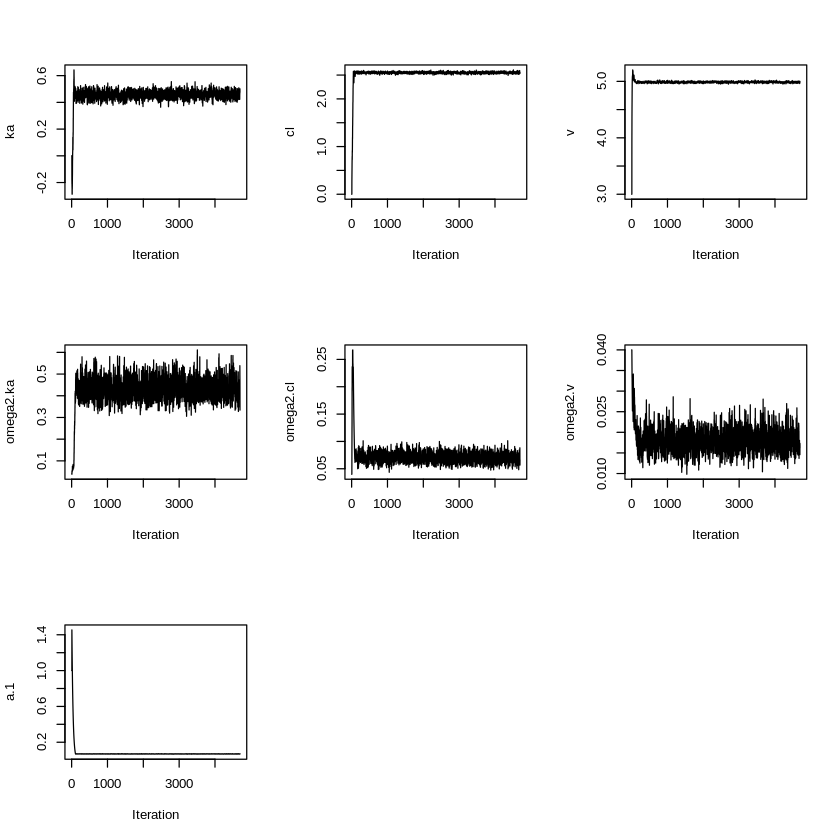

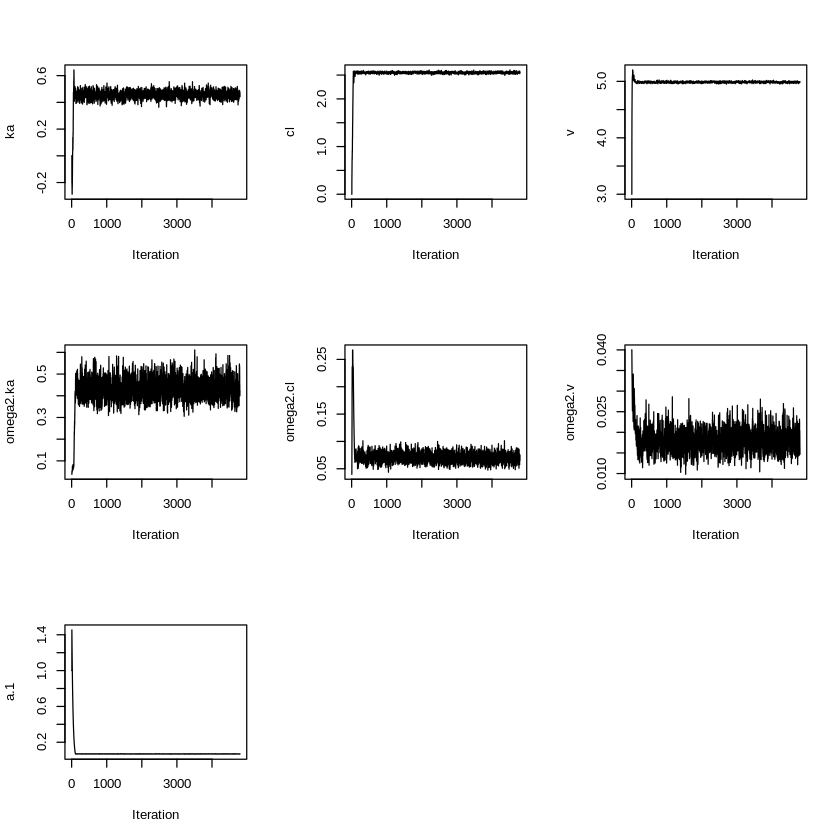

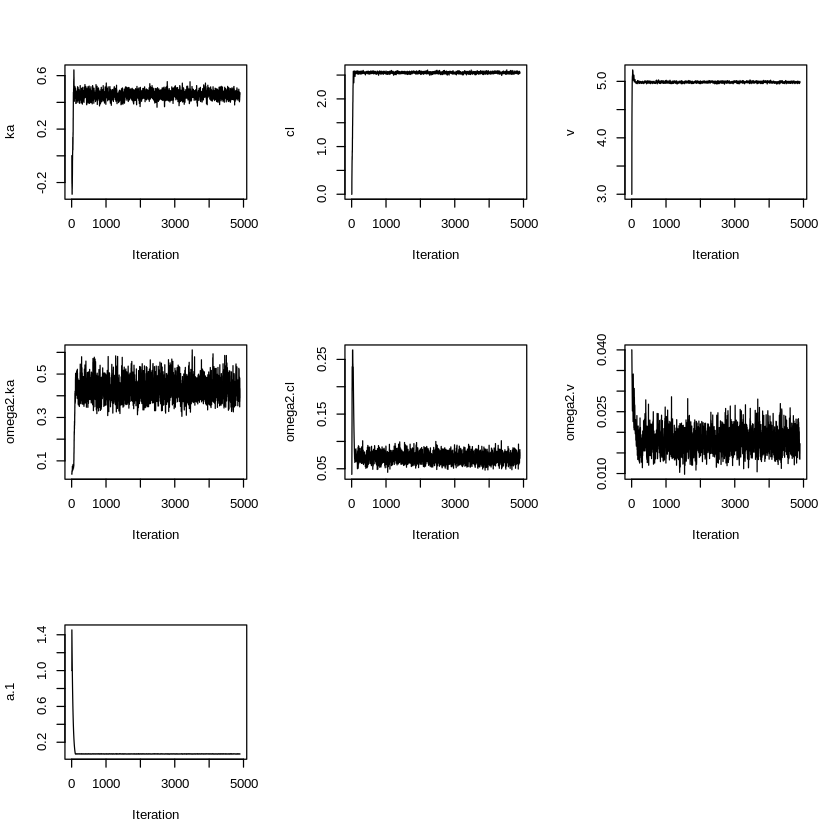

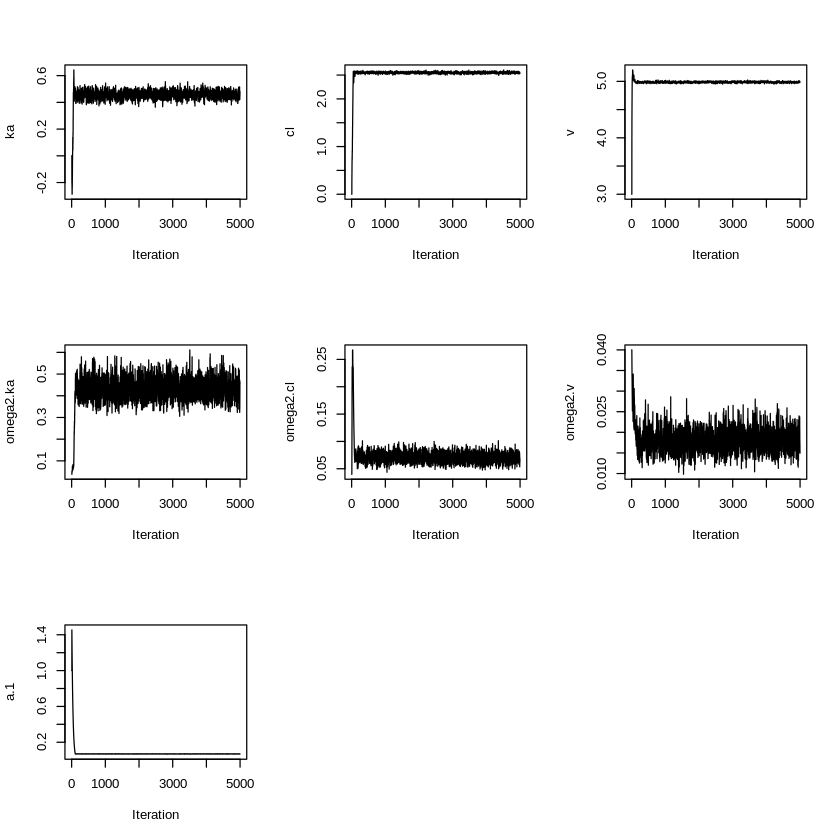

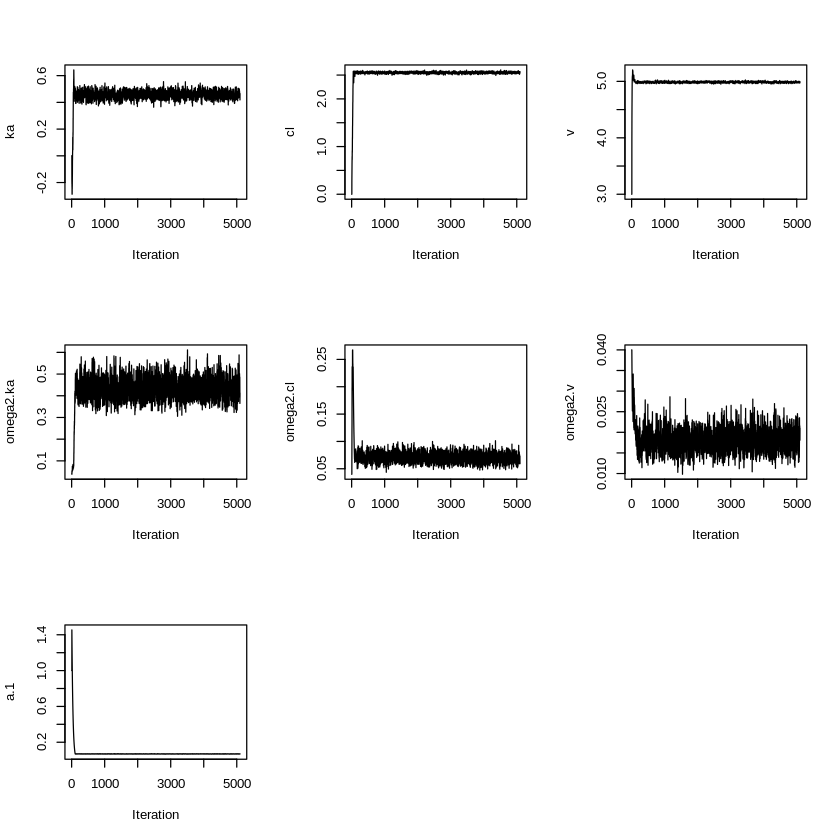

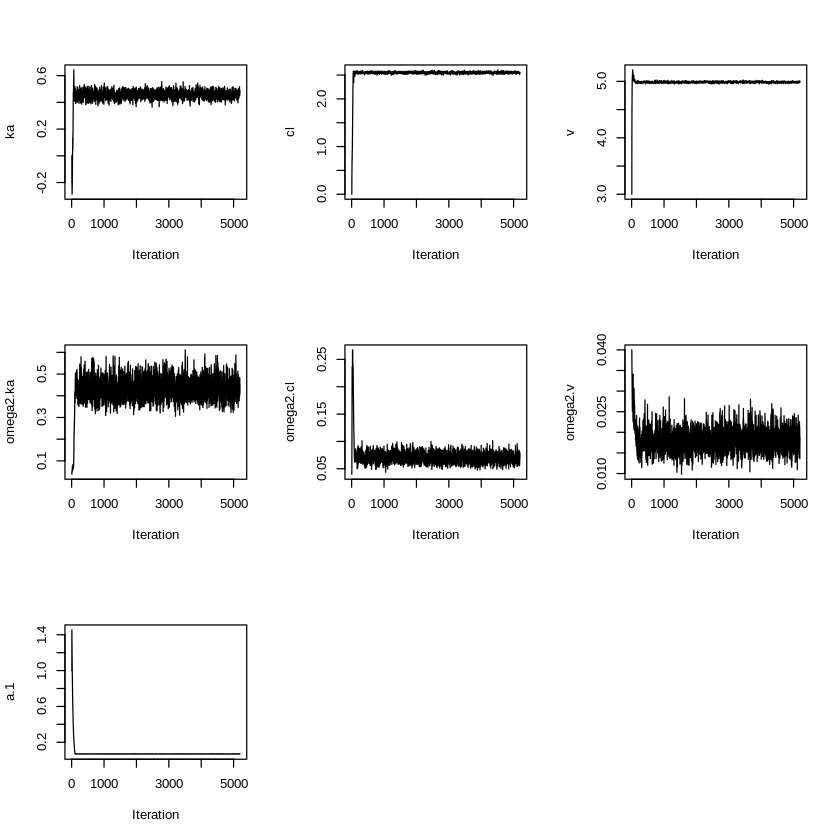

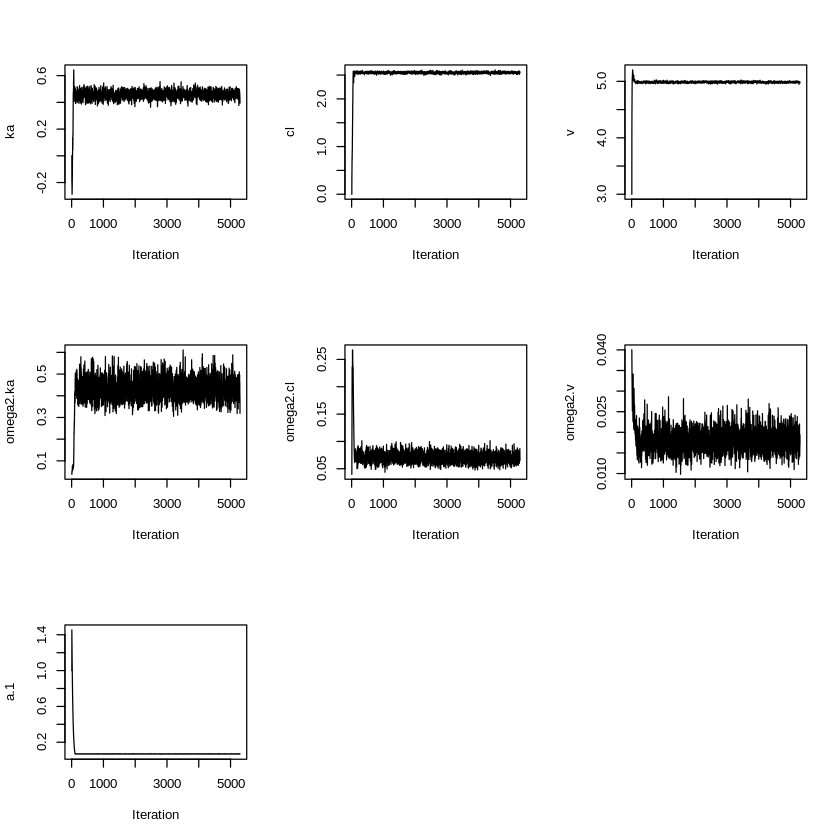

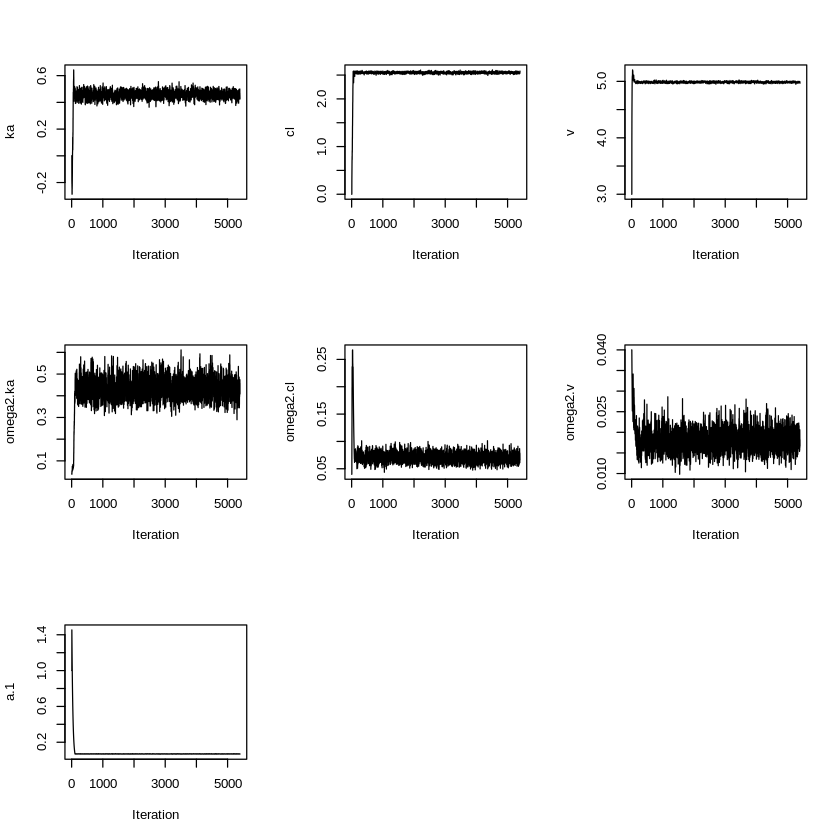

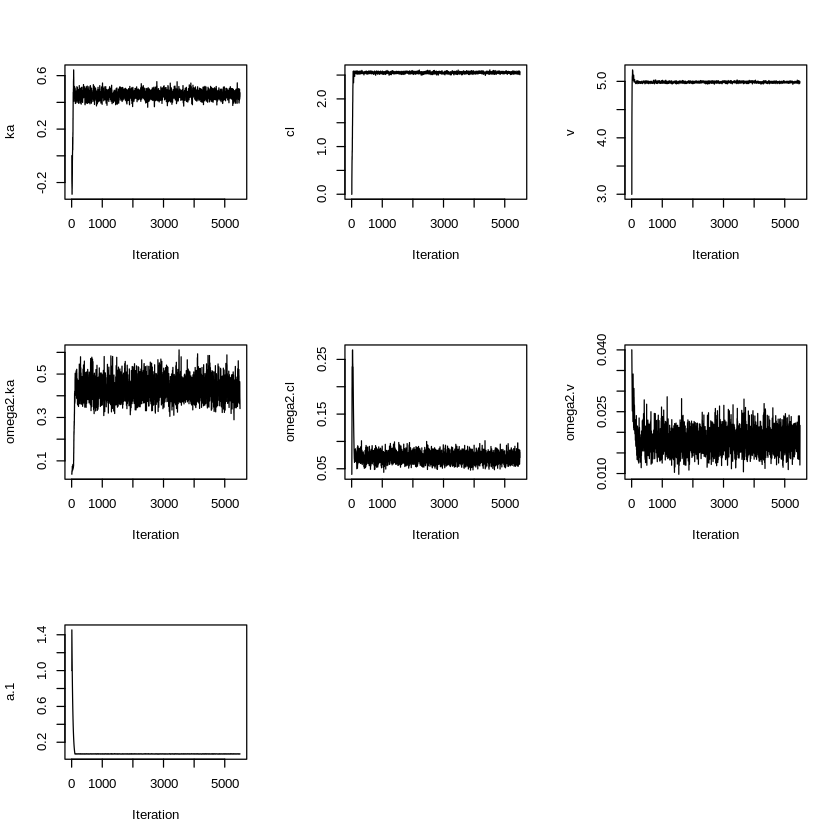

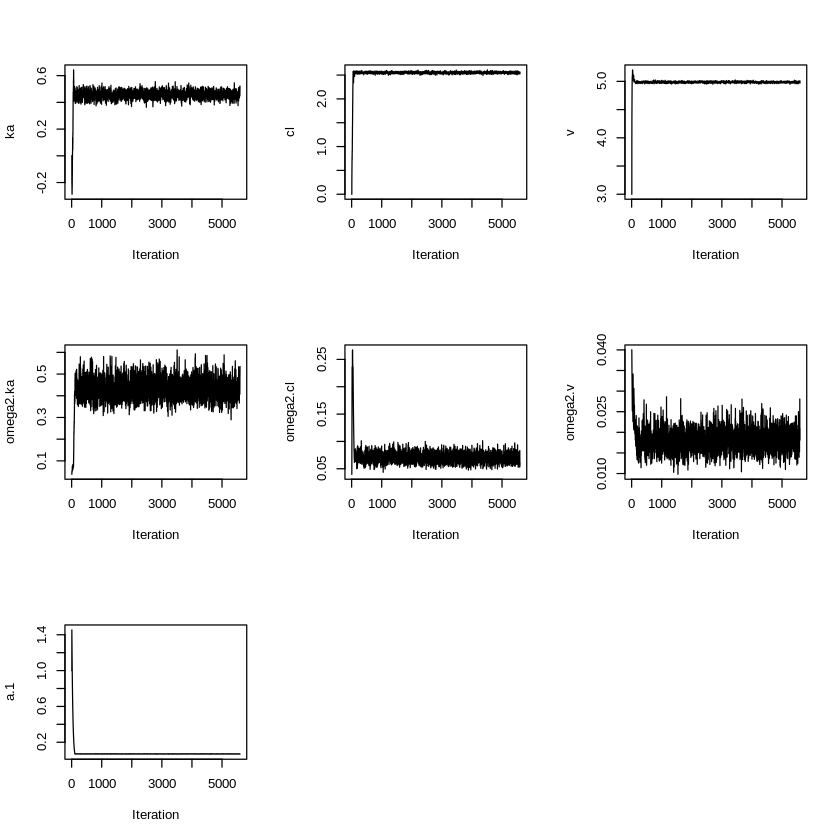

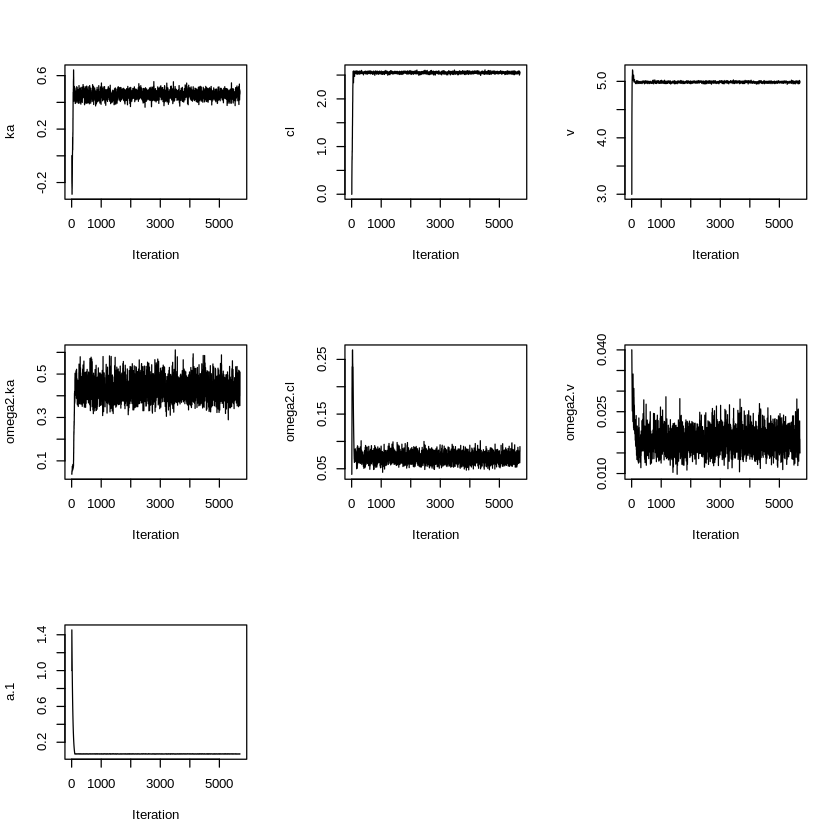

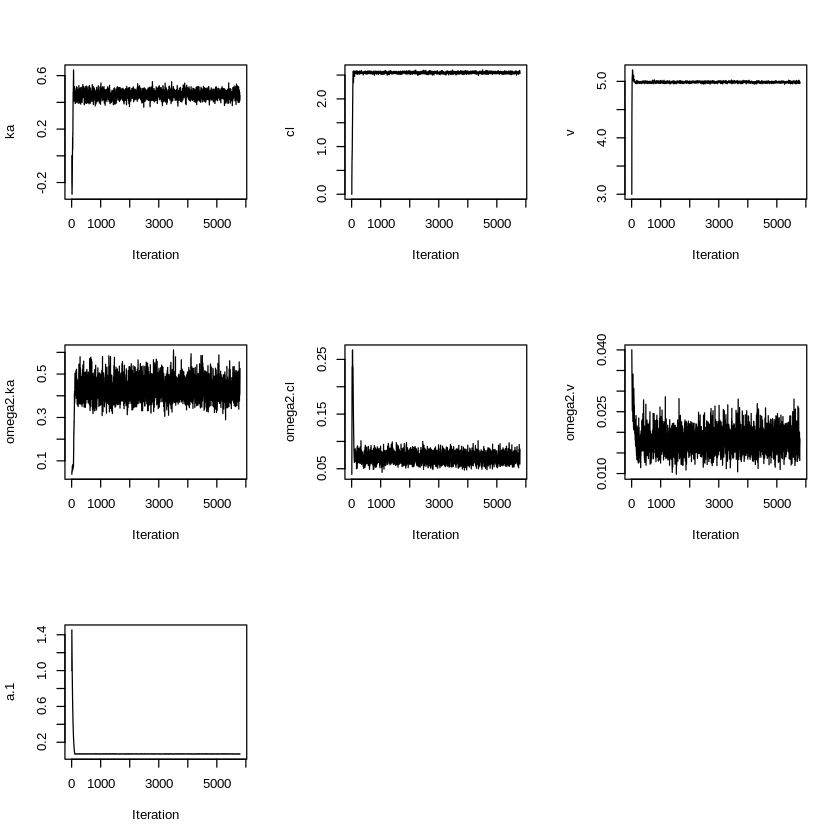

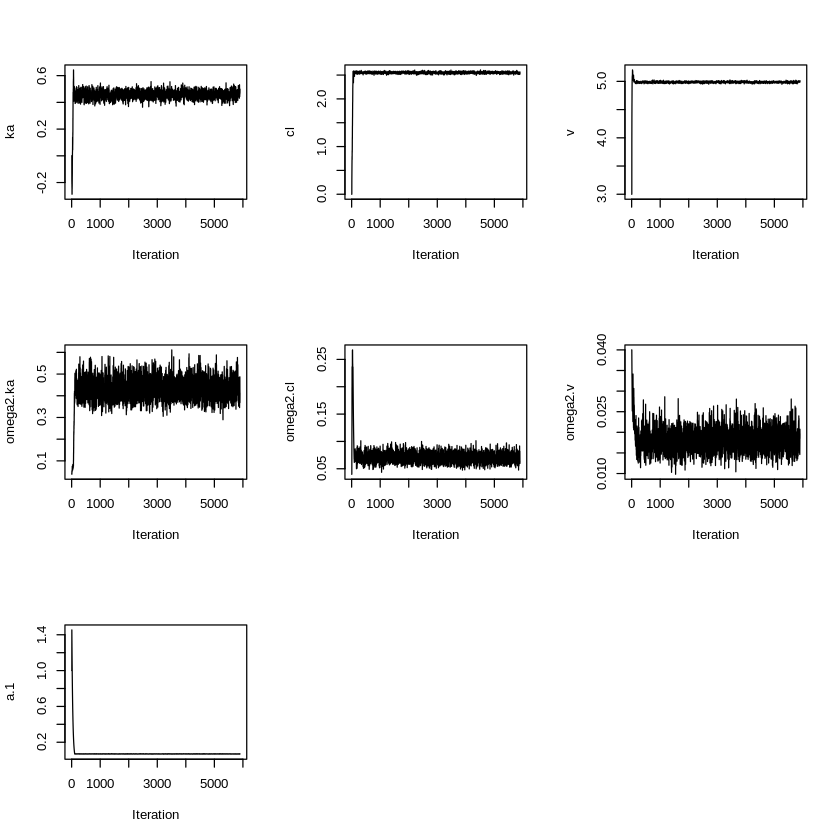

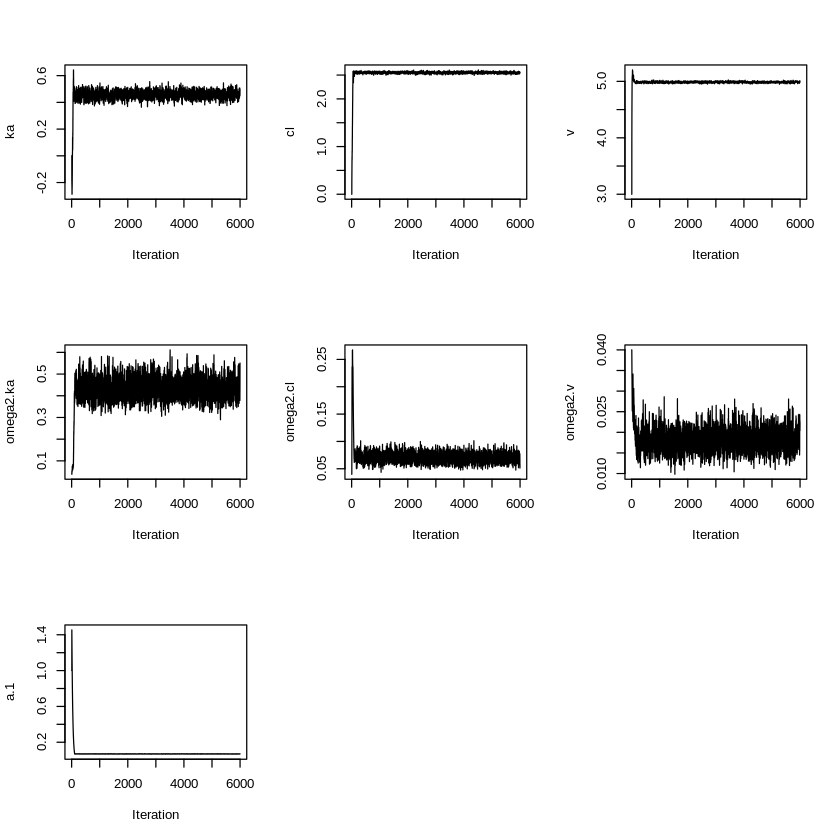

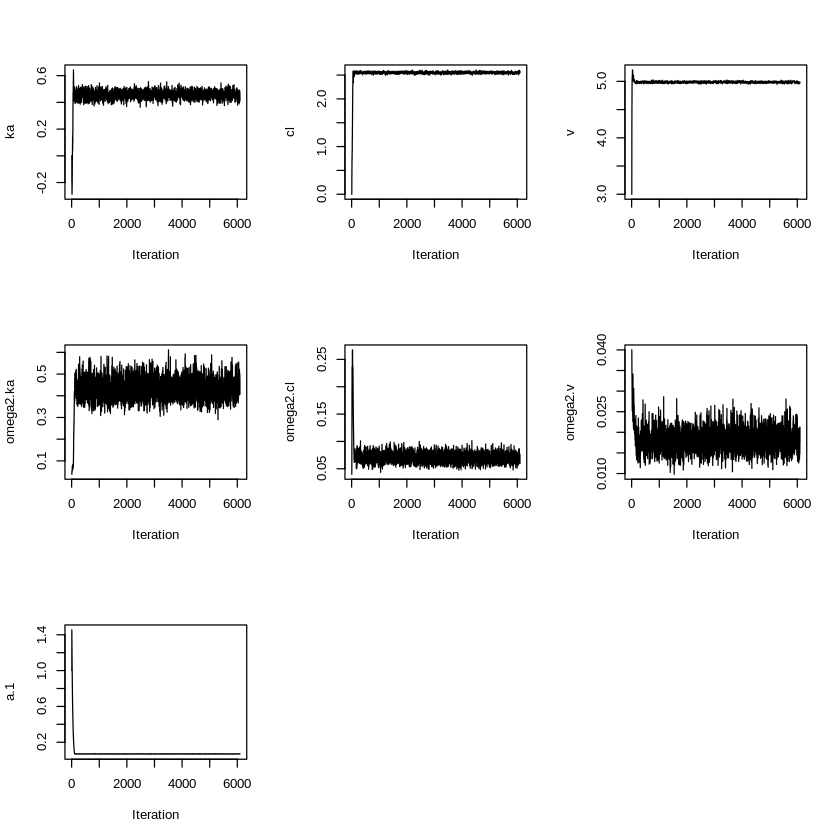

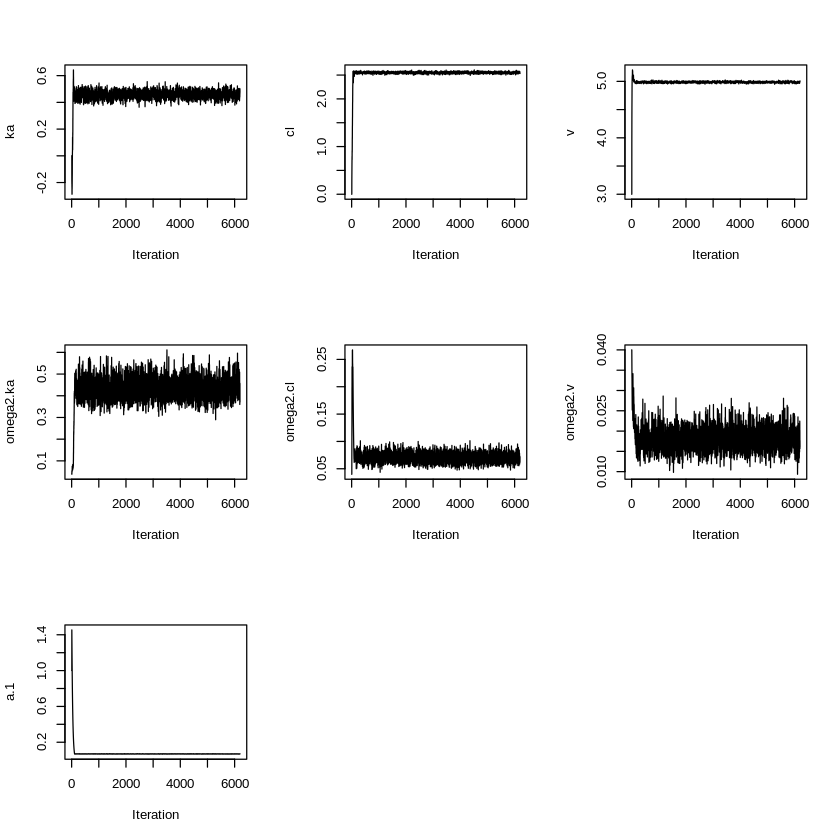

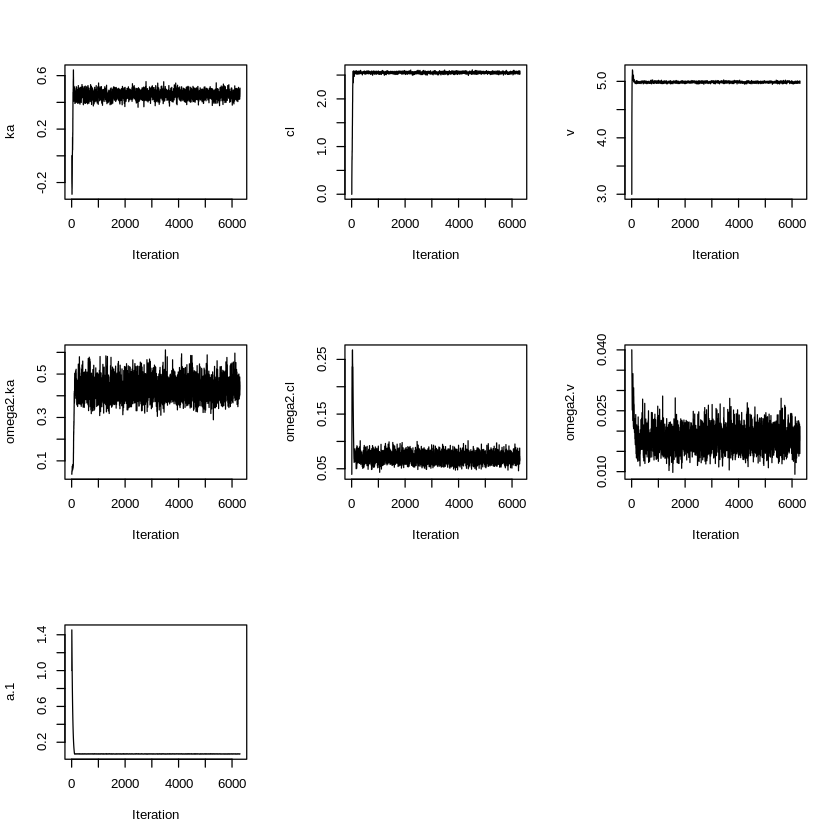

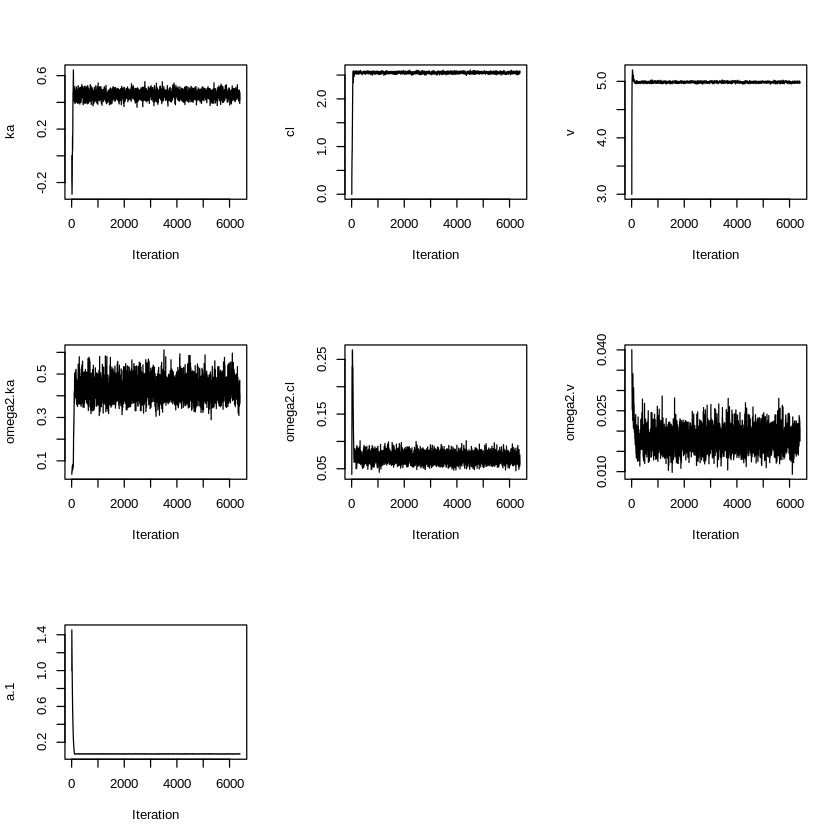

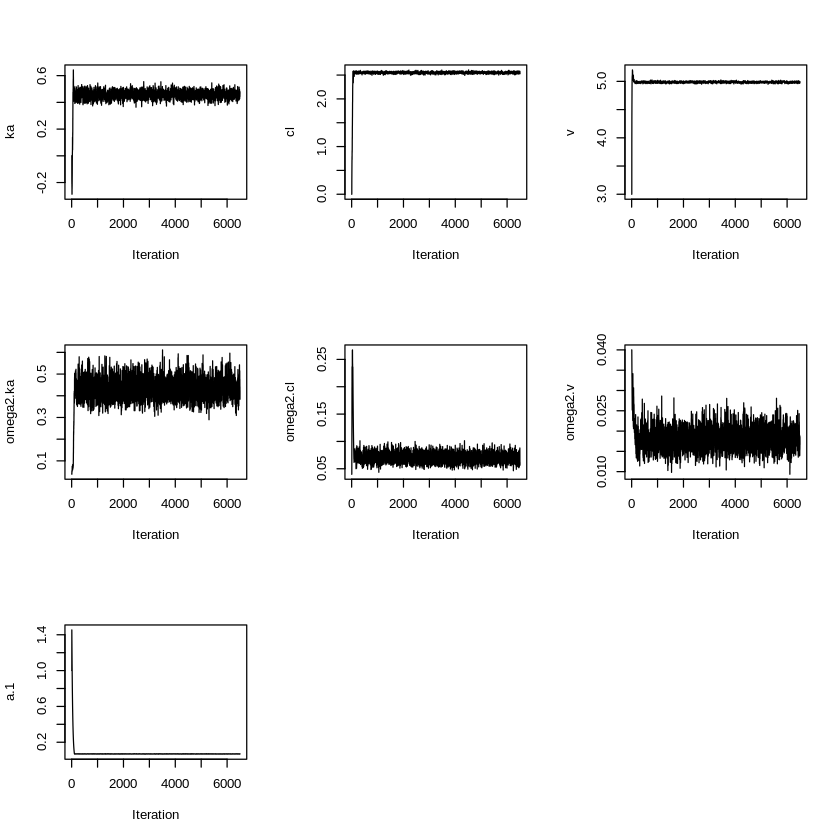

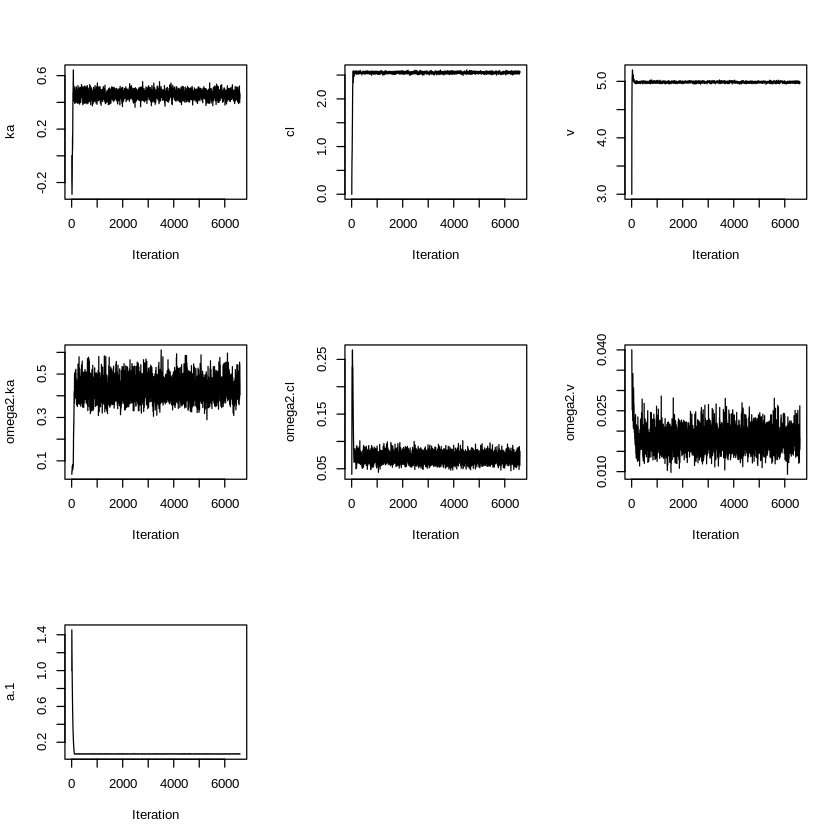

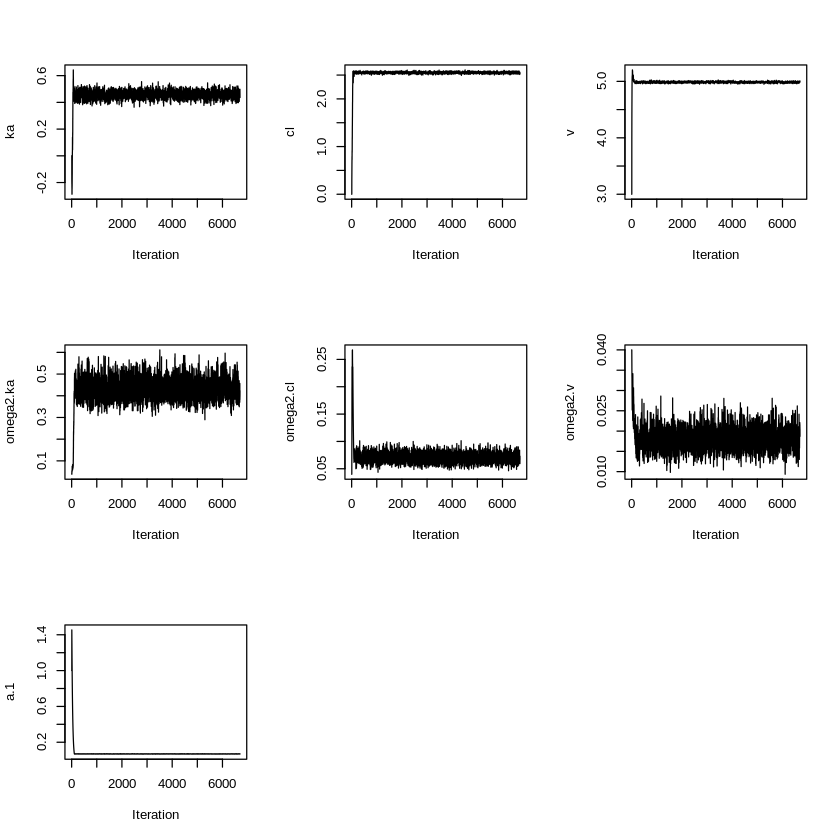

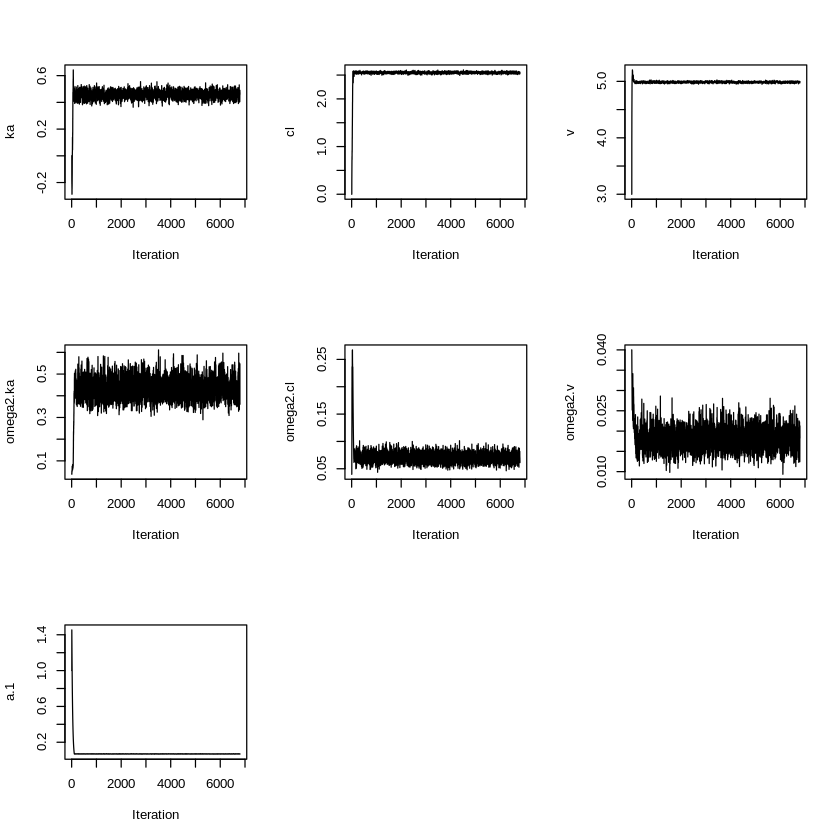

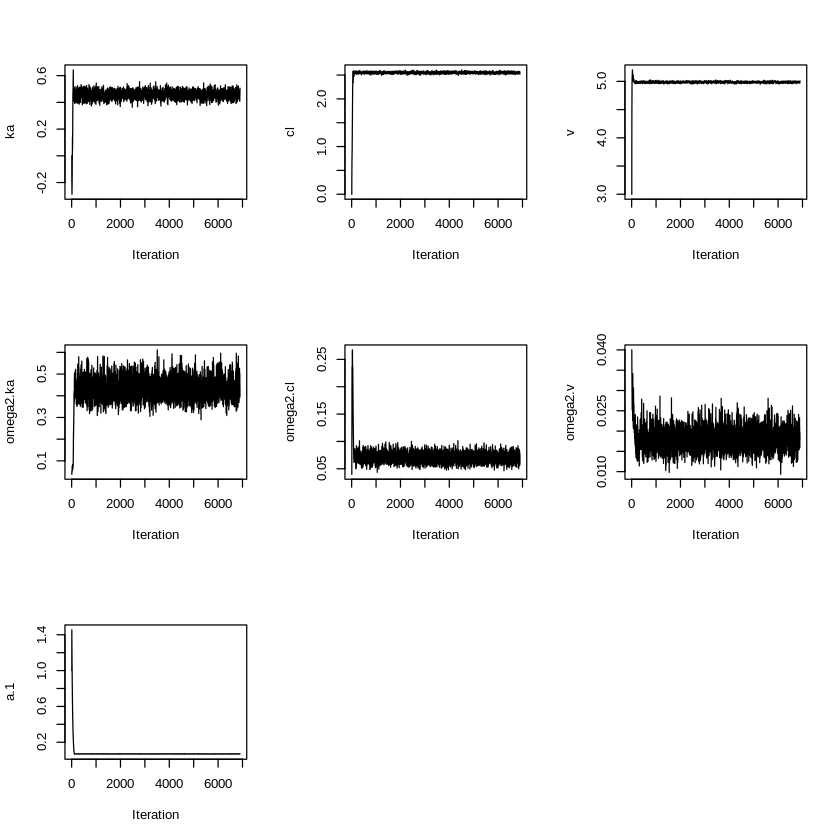

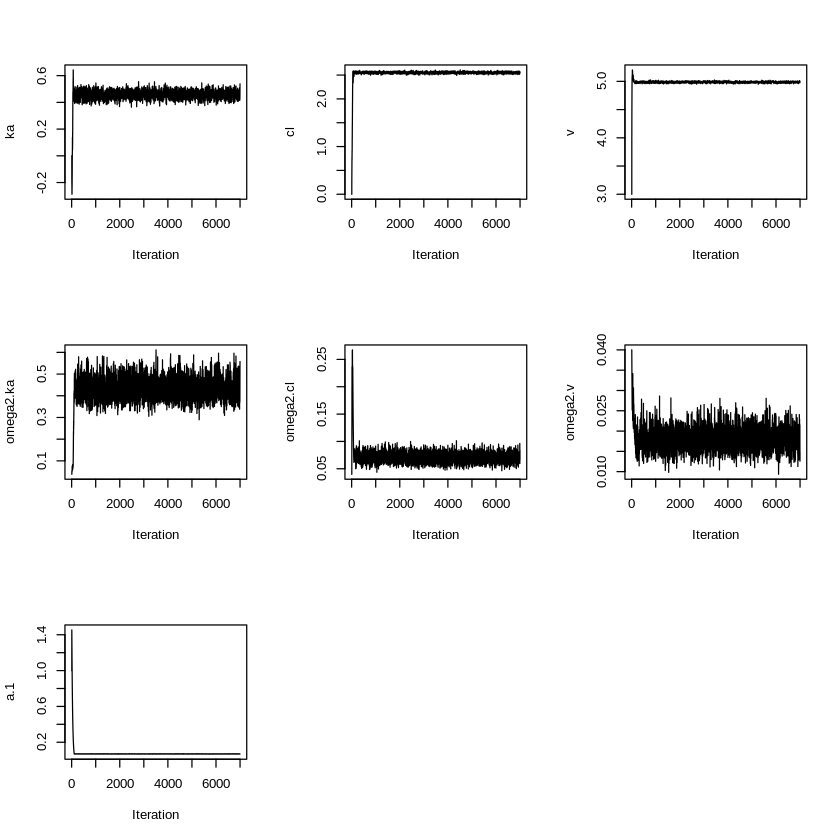

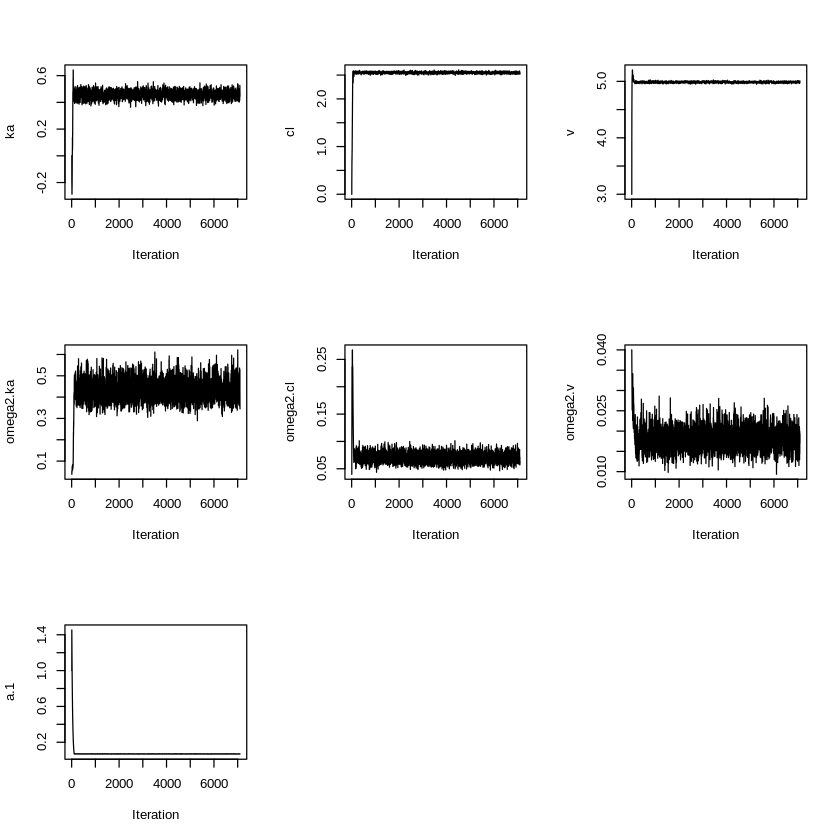

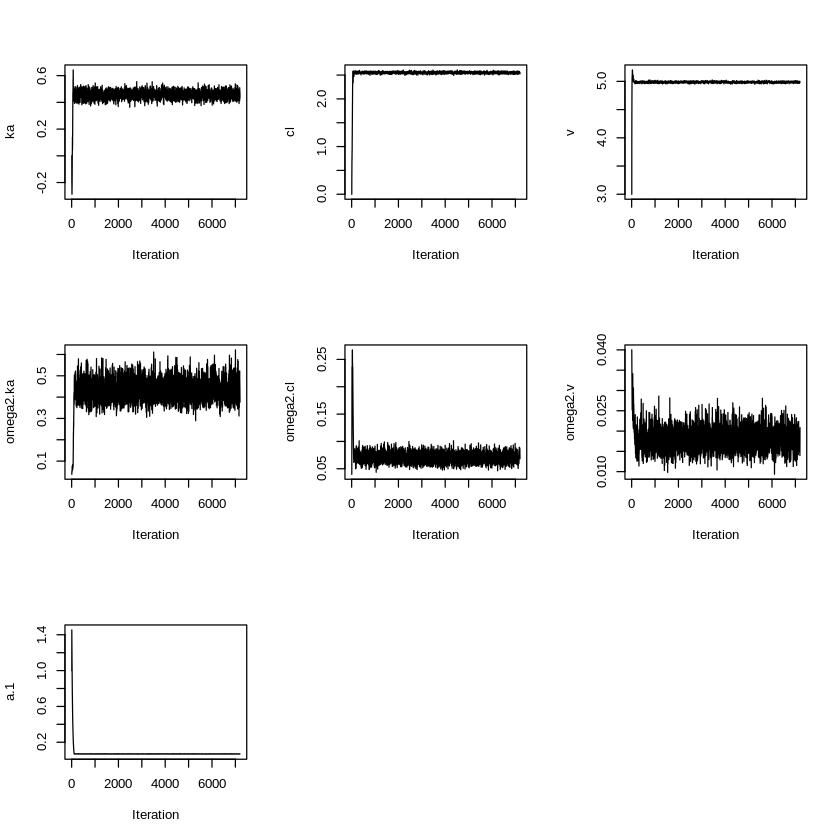

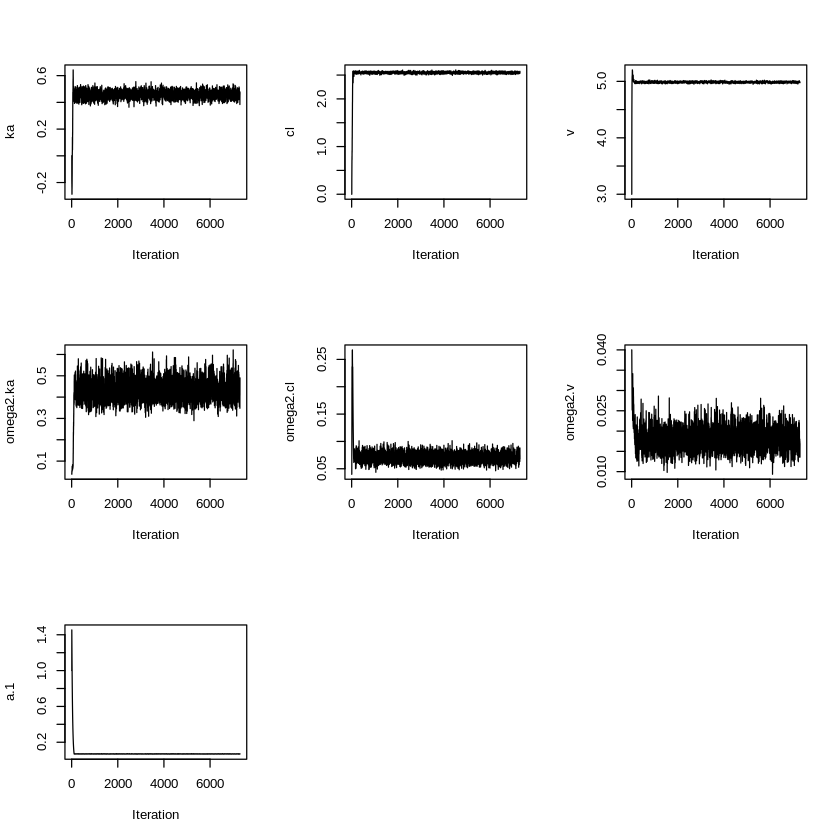

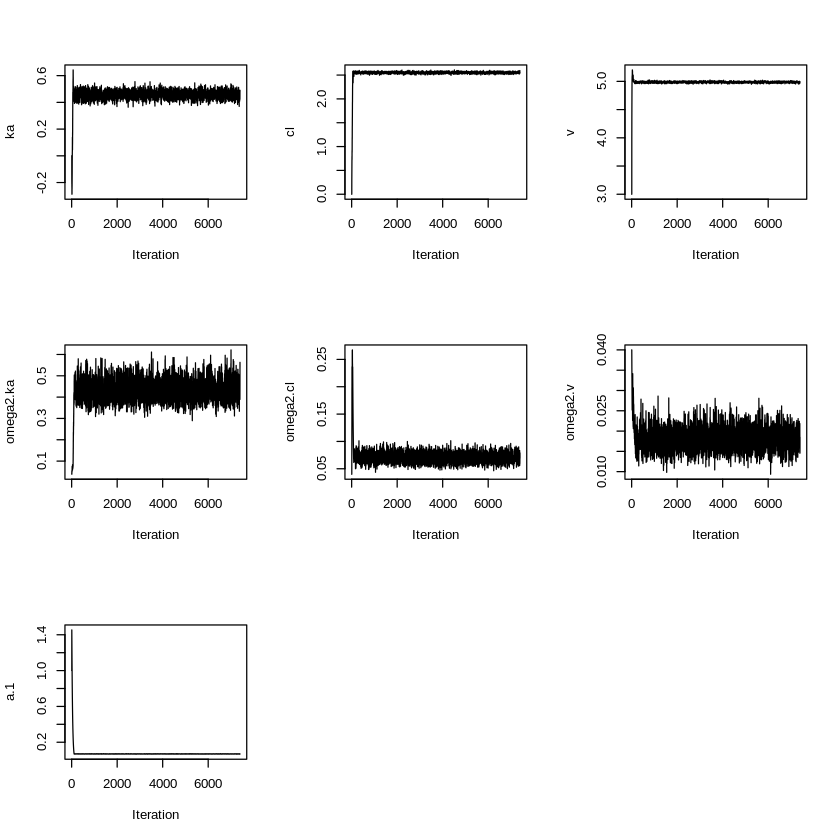

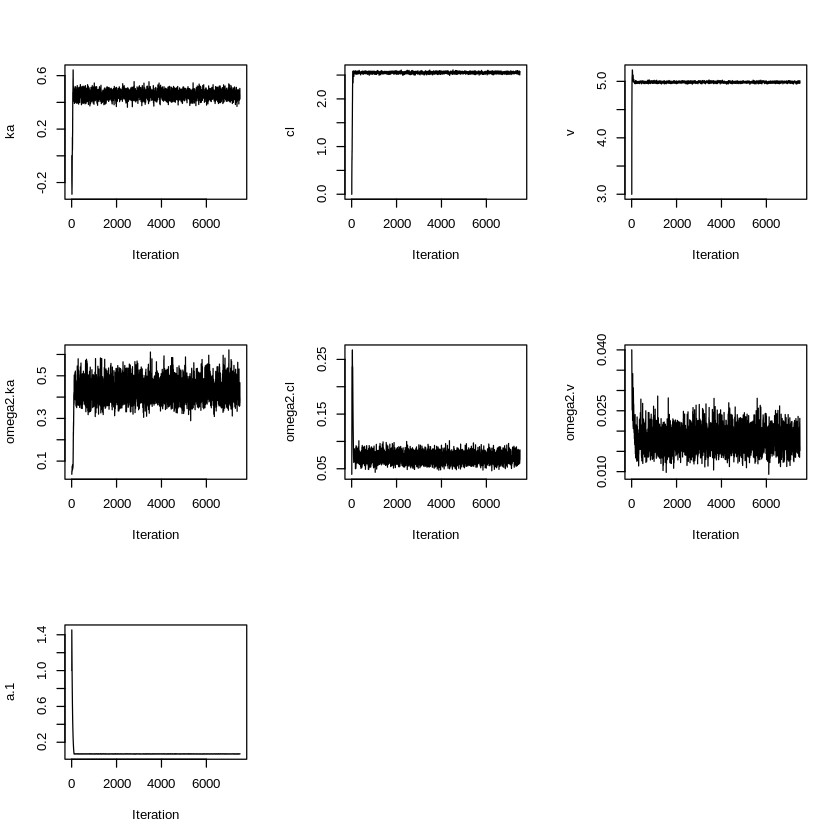

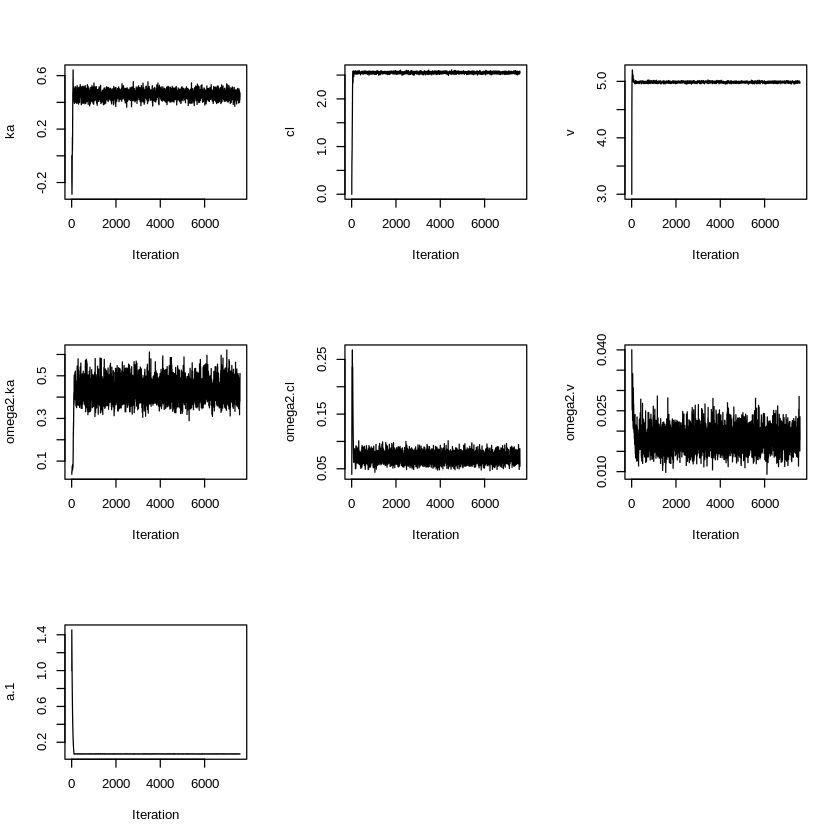

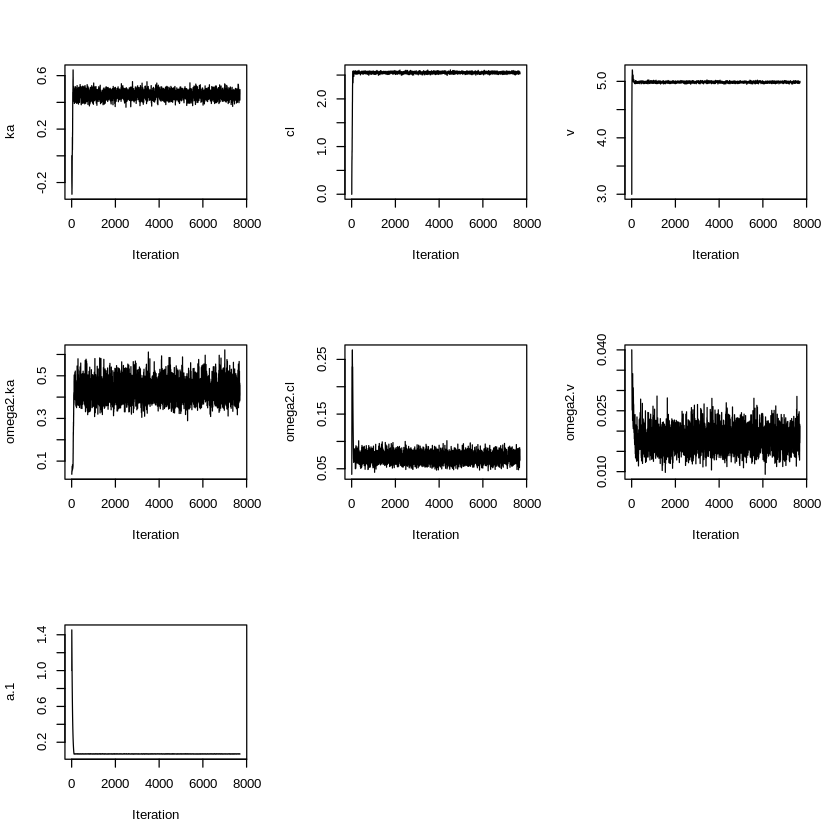

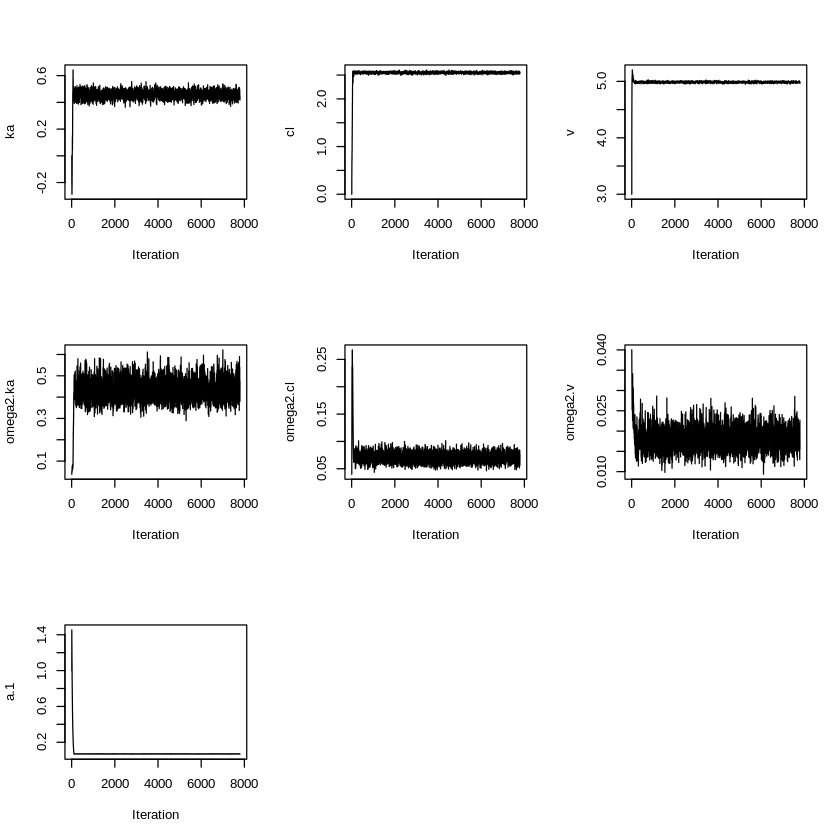

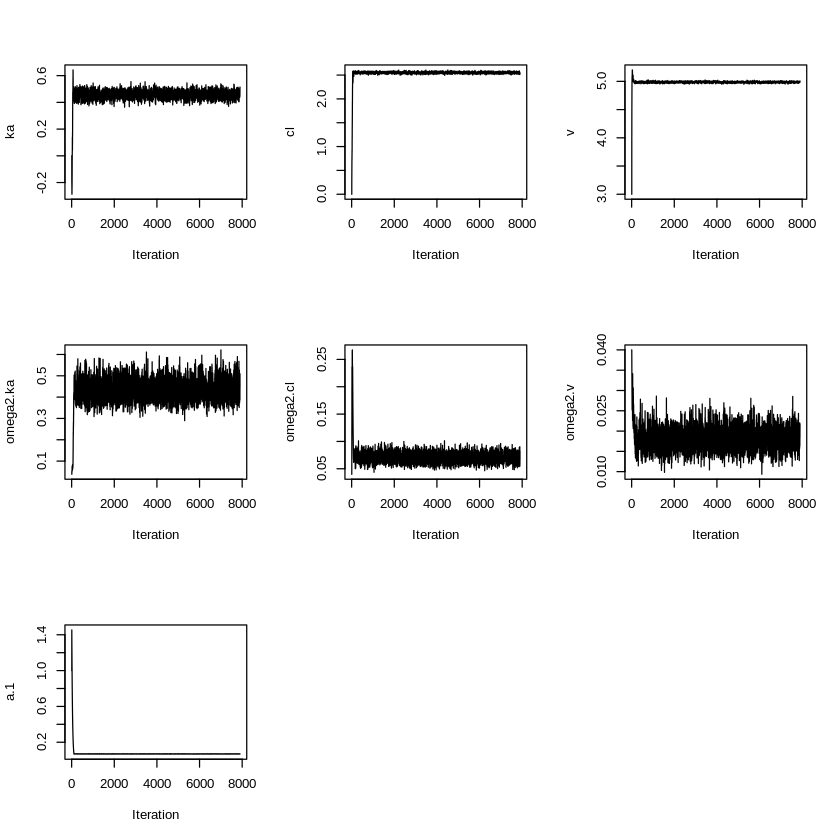

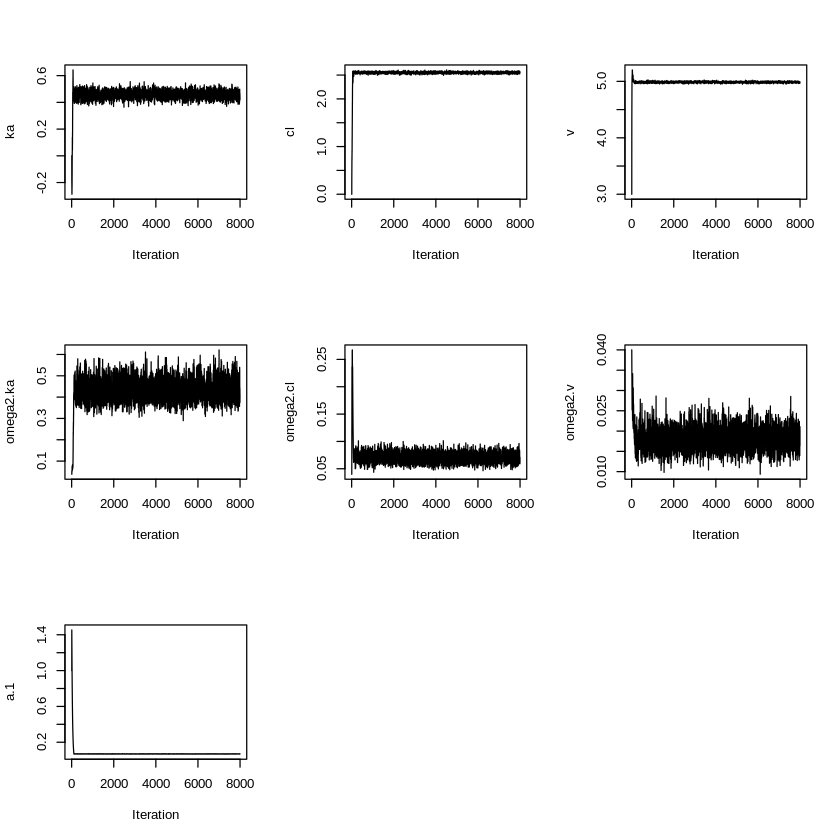

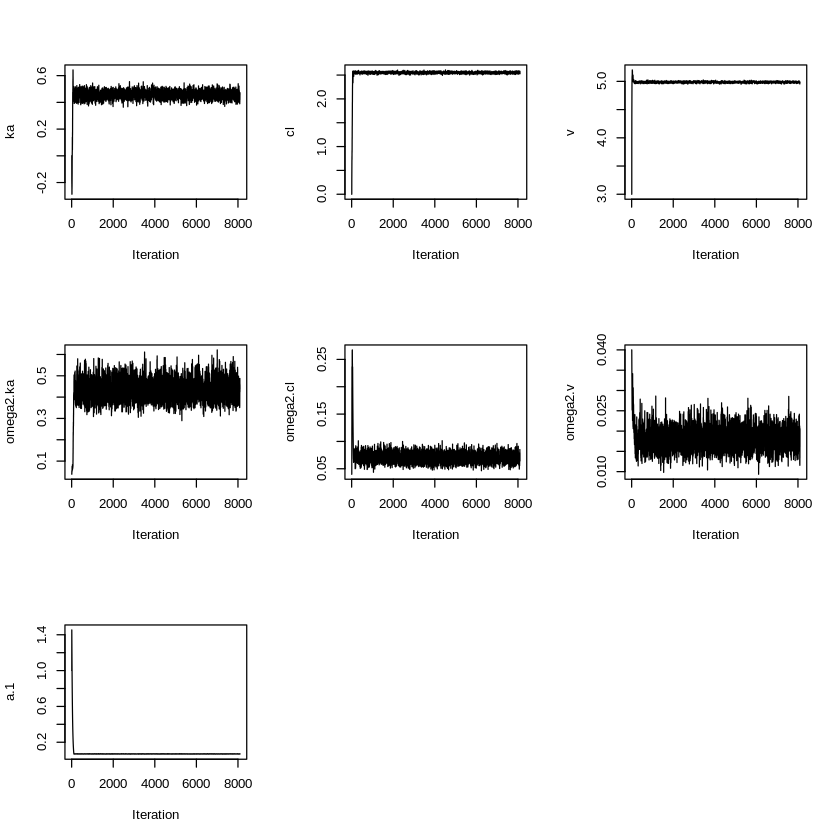

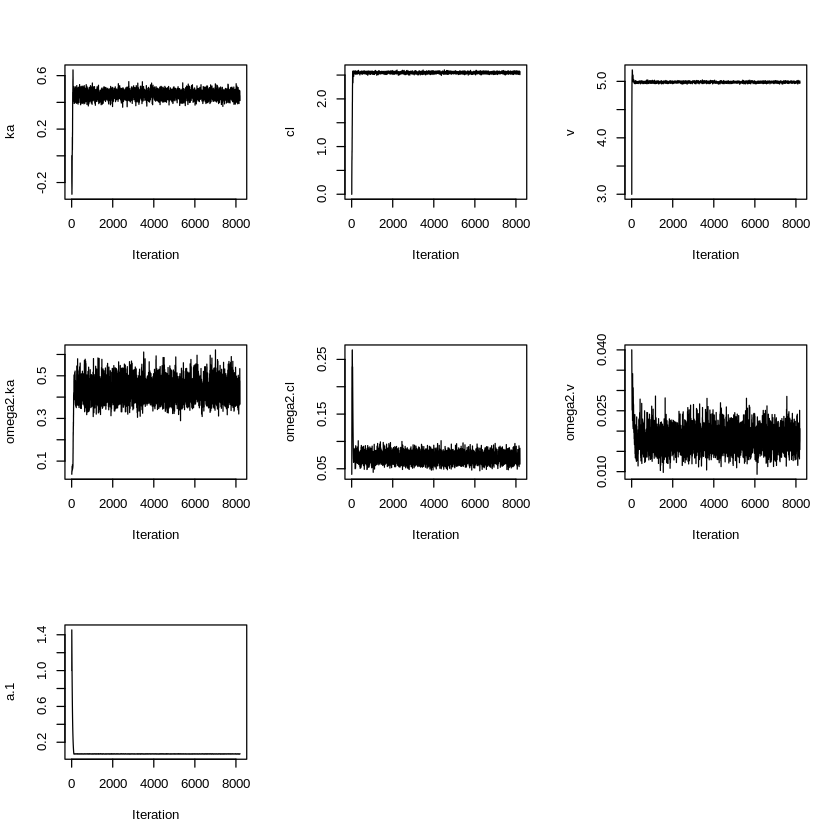

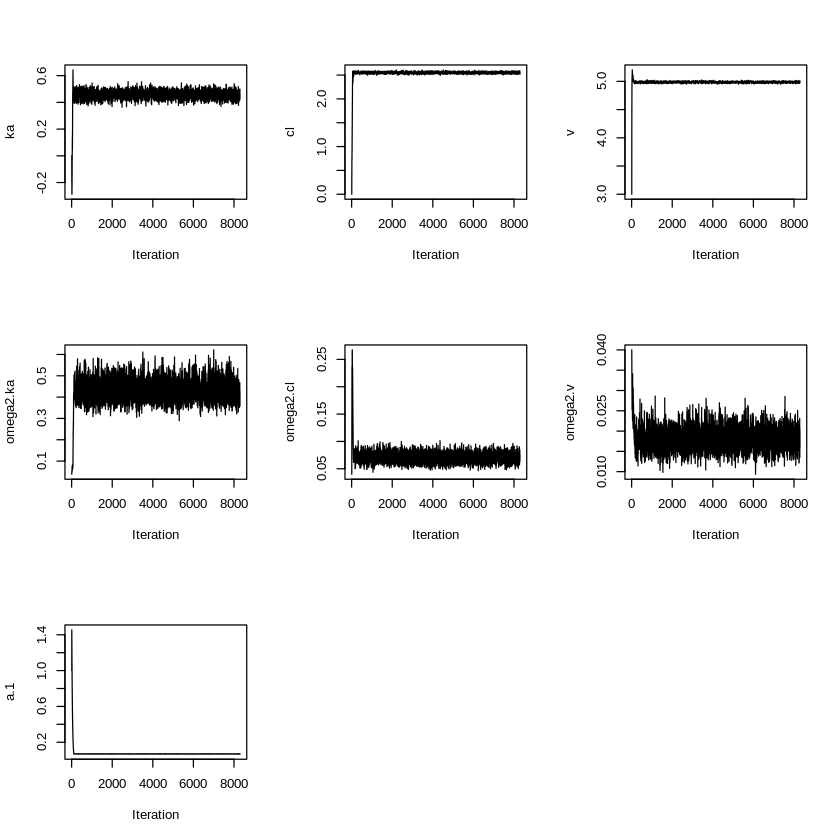

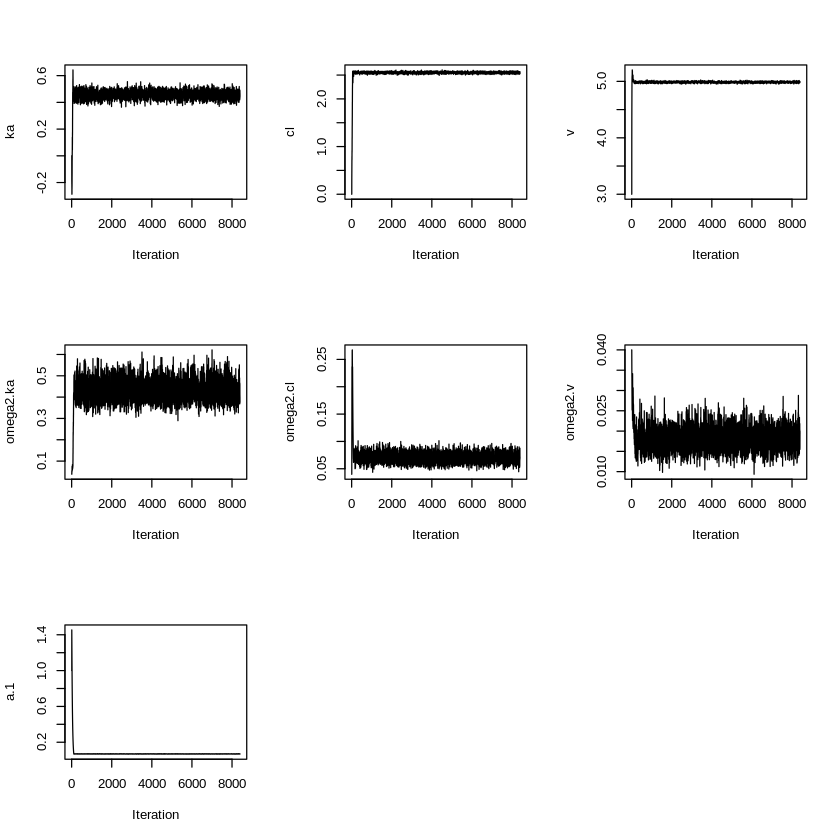

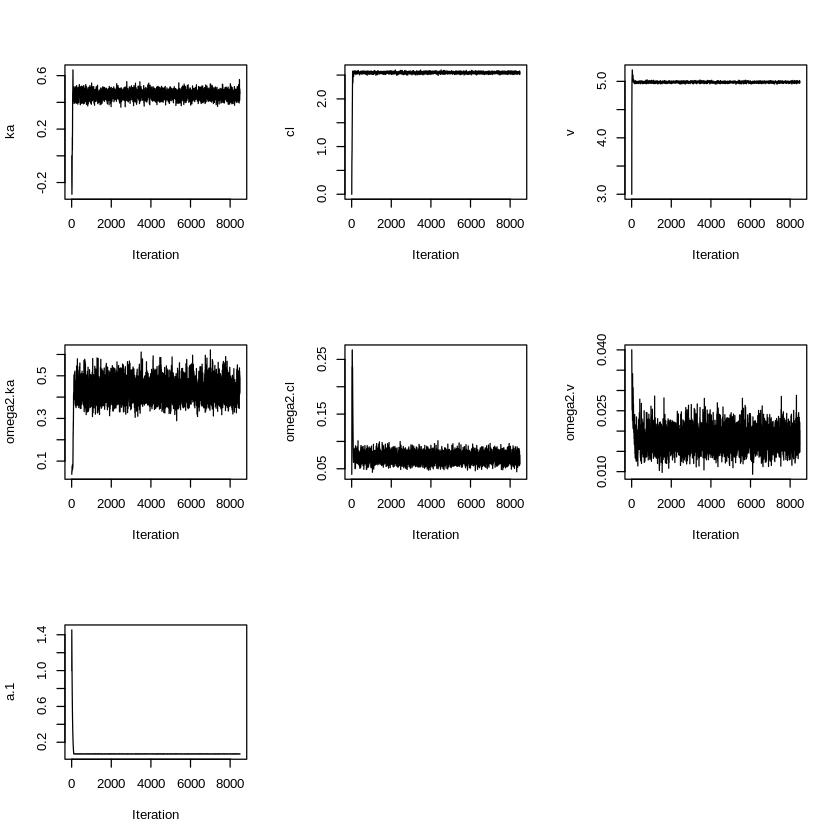

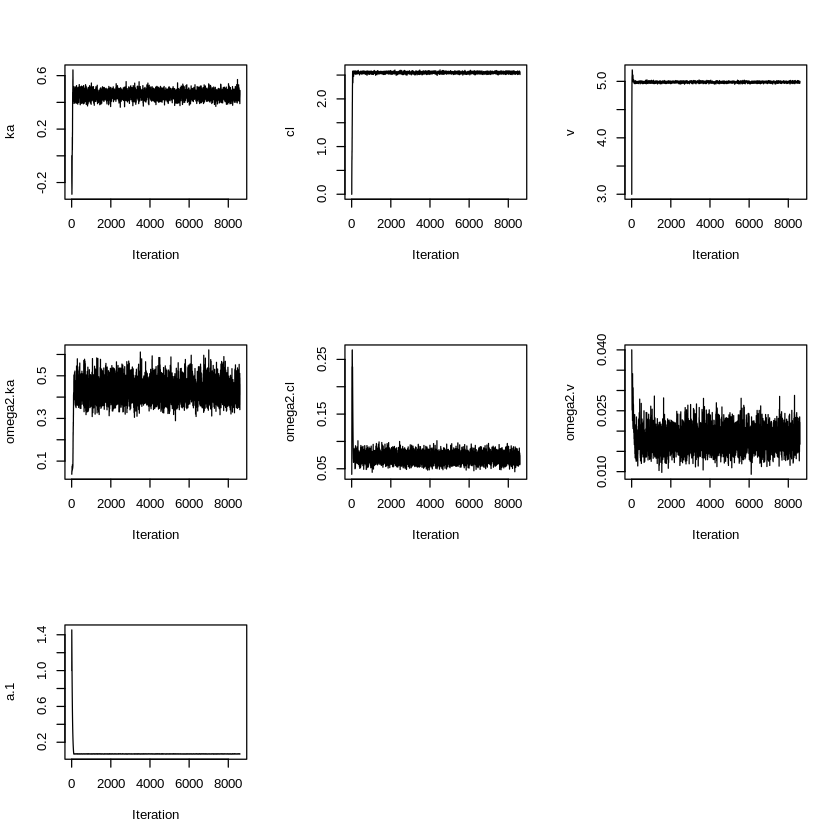

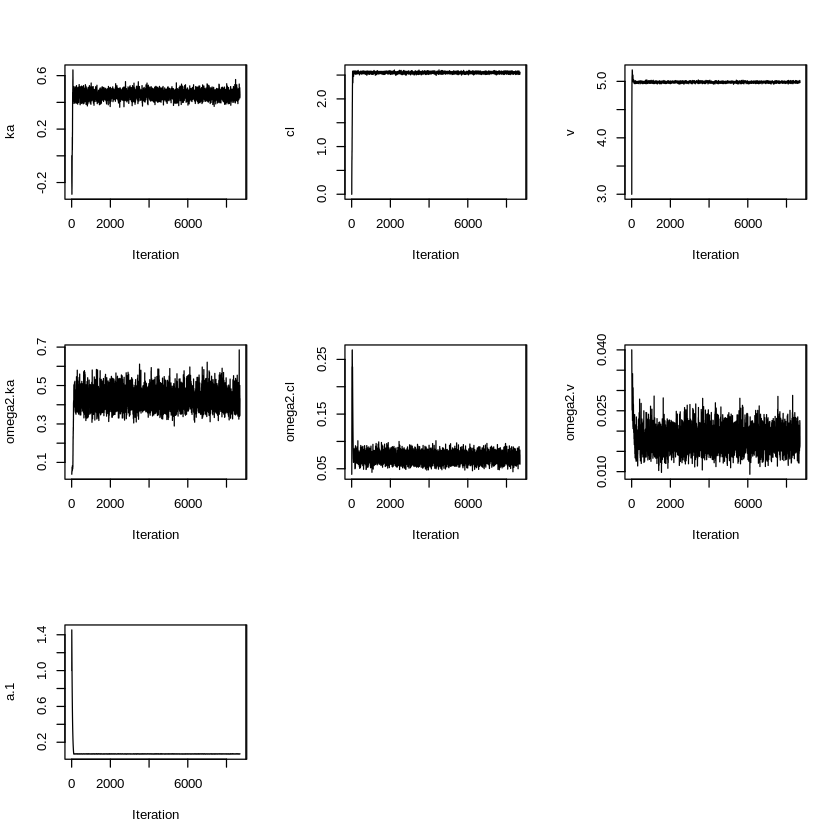

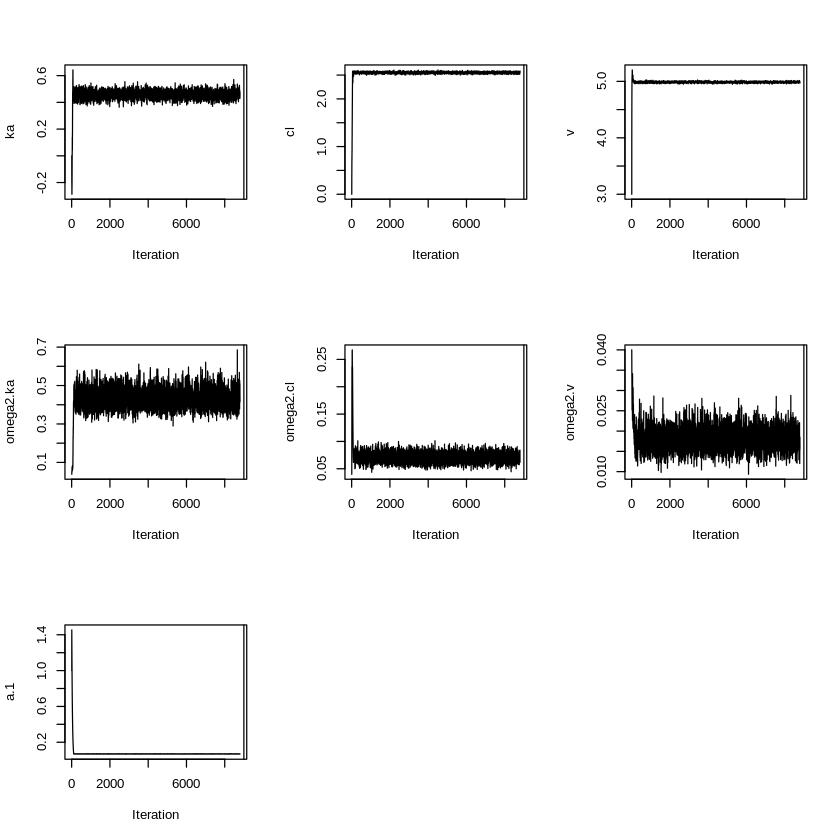

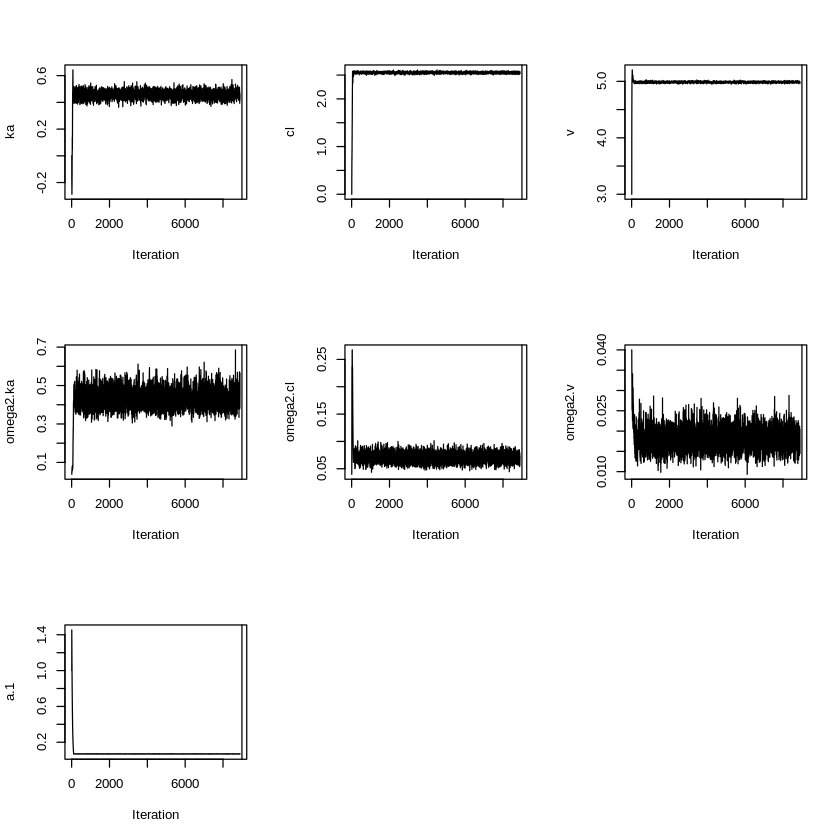

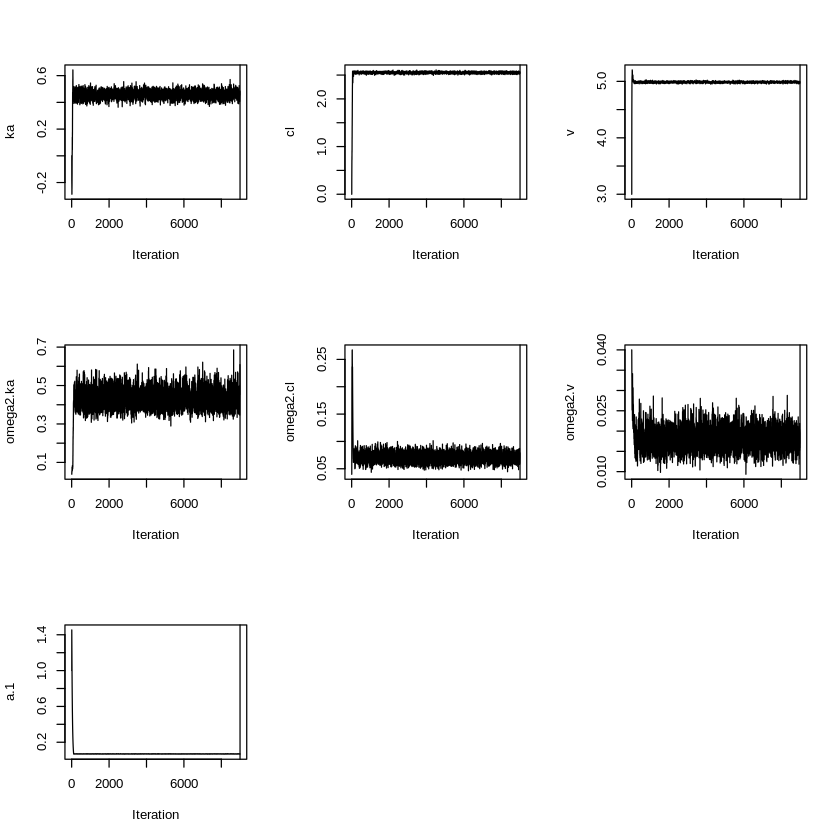

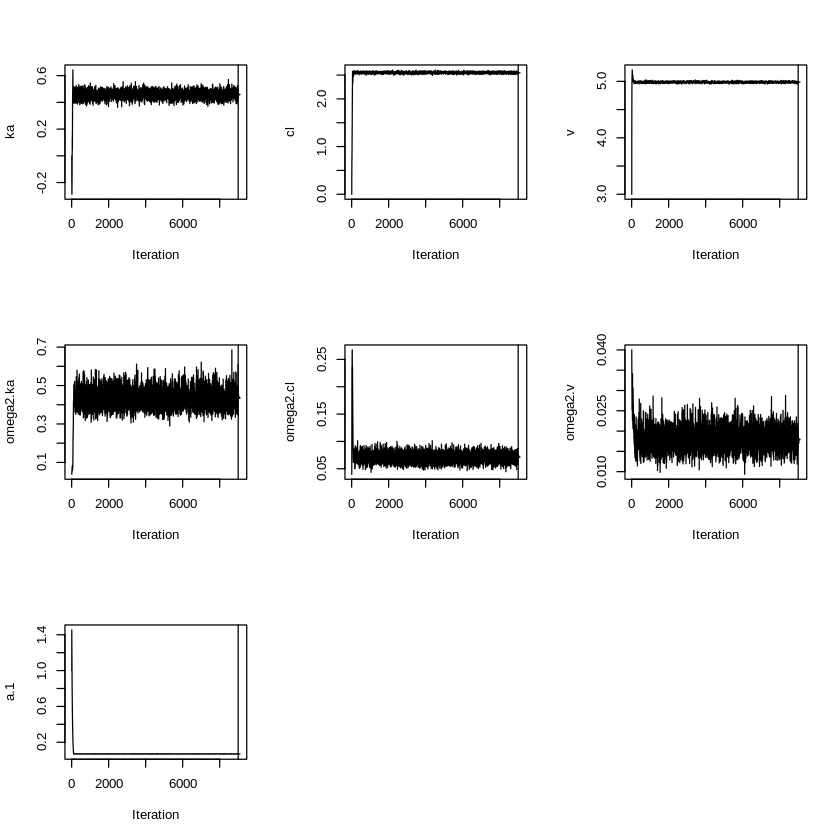

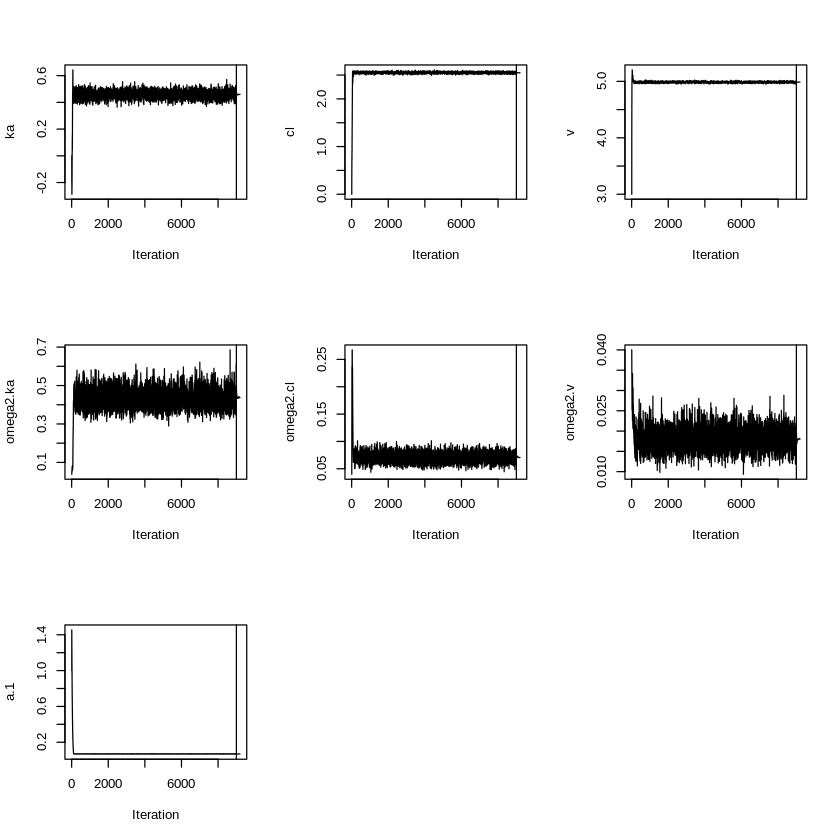

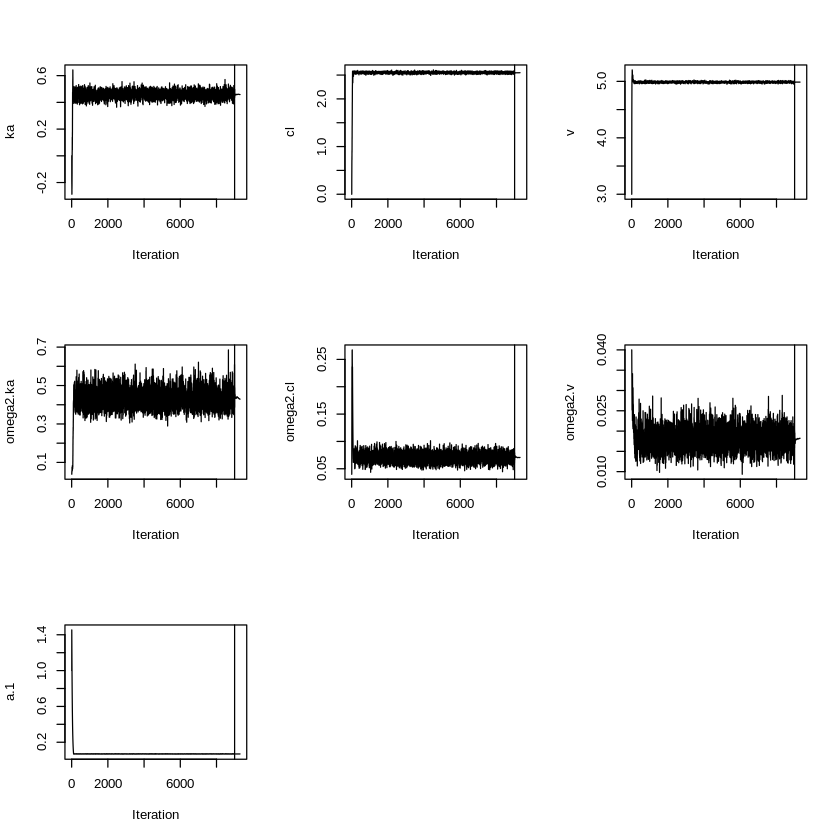

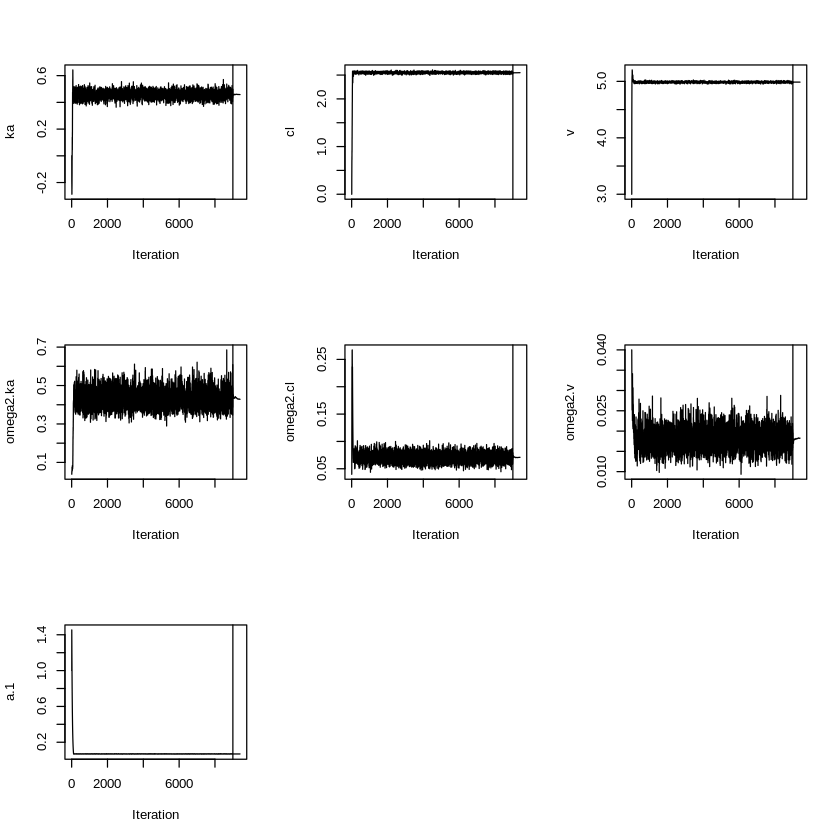

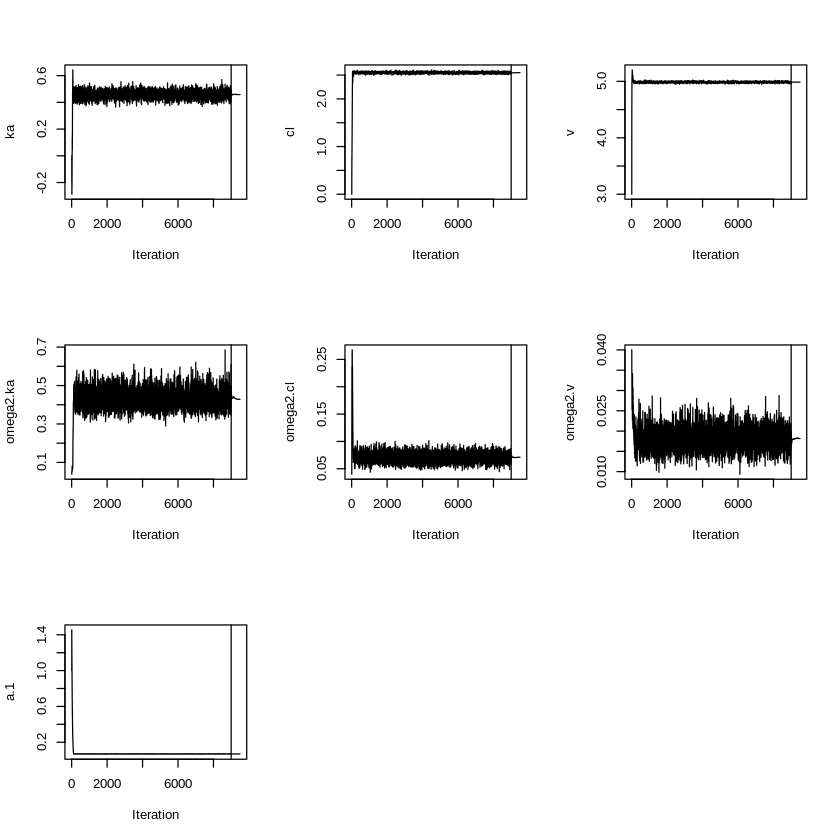

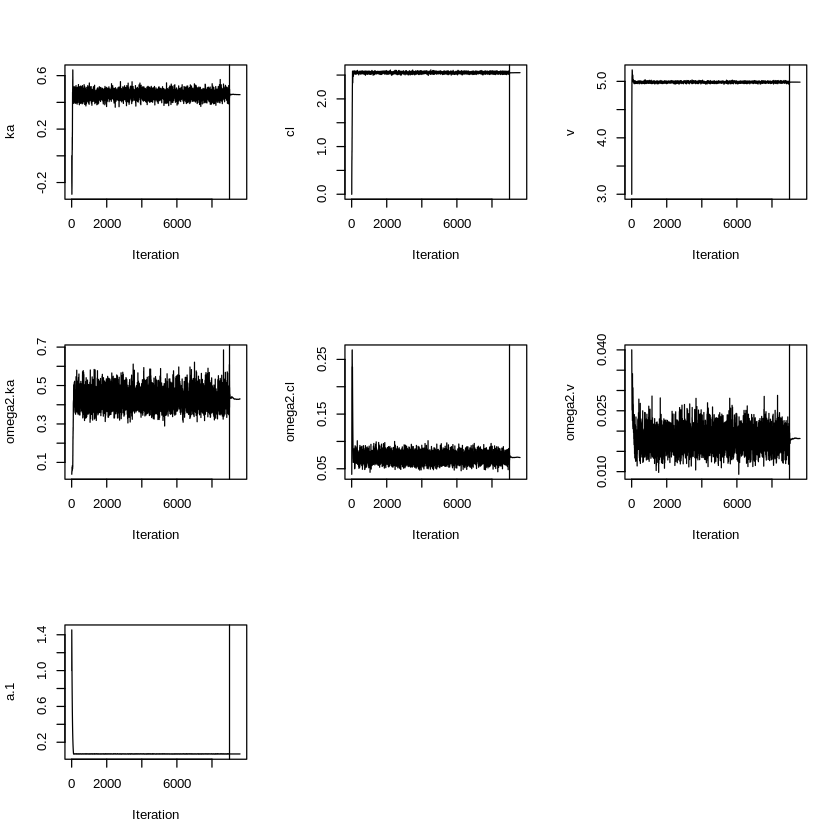

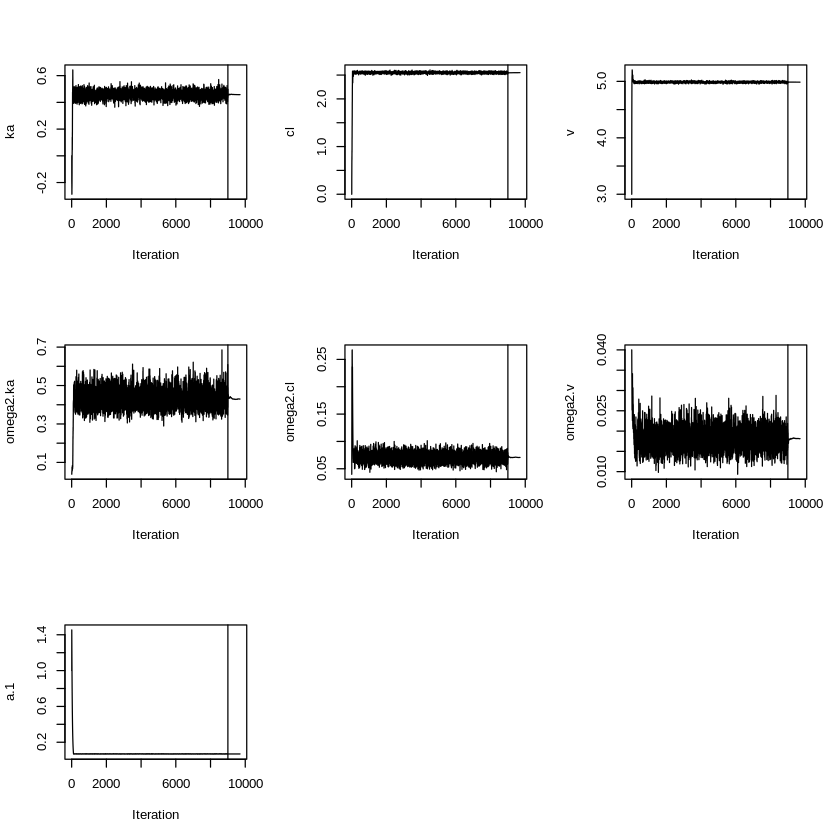

Simulating data using nsim = 1000 simulated datasets
Computing WRES and npde ..
Simulating data using nsim = 1000 simulated datasets
Computing WRES and npde ..
Simulating data using nsim = 1000 simulated datasets
Computing WRES and npde ..


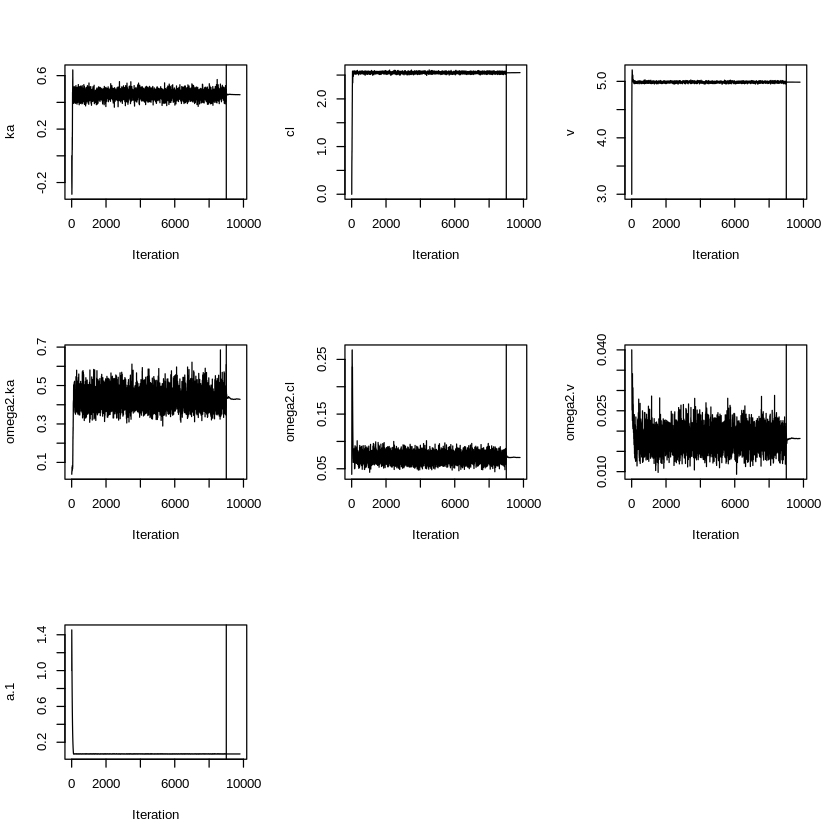


Model fitting completed

Back-transformed parameter estimates:
Ka: 1.58 hr^-1
CL: 12.8 L/hr
V: 146 L

Convergence information:
[1] "fitted"

NCA Analysis Results:
$result
# A tibble: 132 × 6
   ID    start   end PPTESTCD            PPORRES exclude
   <ord> <dbl> <dbl> <chr>                 <dbl> <chr>  
 1 6         0   Inf cmax                 6.44   NA     
 2 6         0   Inf tmax                 1.15   NA     
 3 6         0   Inf tlast               23.8    NA     
 4 6         0   Inf lambda.z             0.0878 NA     
 5 6         0   Inf r.squared            0.998  NA     
 6 6         0   Inf adj.r.squared        0.998  NA     
 7 6         0   Inf lambda.z.time.first  2.03   NA     
 8 6         0   Inf lambda.z.n.points    7      NA     
 9 6         0   Inf clast.pred           0.941  NA     
10 6         0   Inf half.life            7.89   NA     
# ℹ 122 more rows

$data
Formula for concentration:
 CONC ~ TIME | ID
Data are dense PK.
With 12 subjects defined in the 'ID

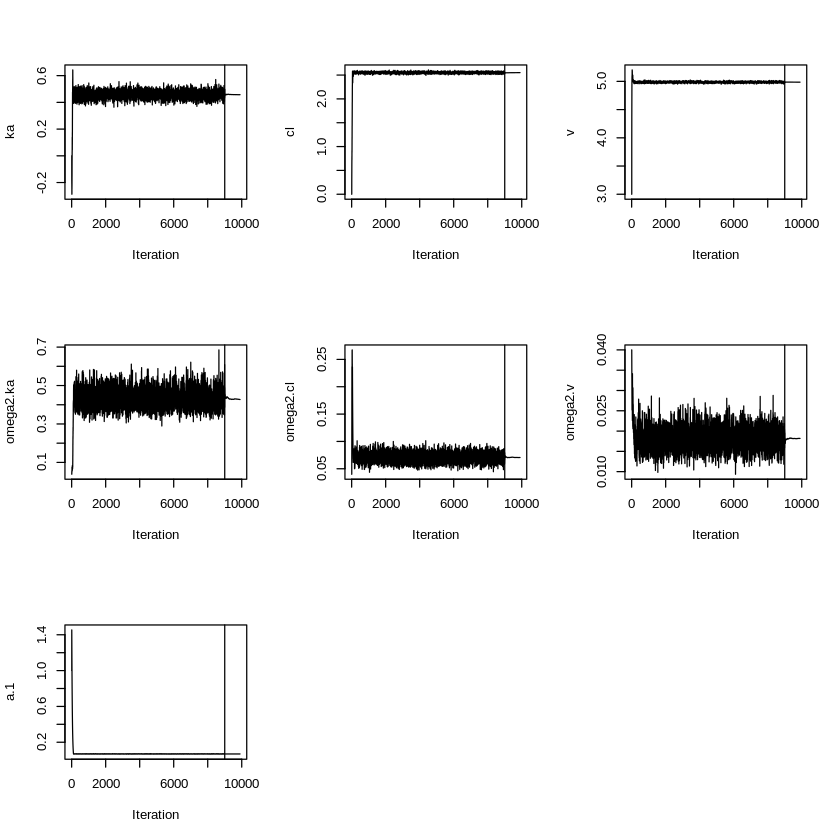

In [4]:
library(saemix)
library(PKNCA)
library(dplyr)

start_time <- proc.time()

# Load and prepare data
data(Theoph)

# Scale the concentrations
Theoph$conc_scaled <- Theoph$conc / 10

# Create the saemix data object
saemix.data <- saemixData(
  name.data = Theoph,
  name.group = "Subject",
  name.predictors = c("Dose", "Time"),
  name.response = "conc_scaled",
  units = list(x="hr", y="mg/L")
)

# Define the structural model
model.function <- function(psi, id, xidep) {
  ka <- exp(psi[id, 1])
  cl <- exp(psi[id, 2])
  v <- exp(psi[id, 3])

  dose <- xidep[, 1] * 32
  time <- xidep[, 2]

  k <- cl/v

  eps <- 1e-3
  ka_adj <- pmax(ka, k + eps)

  conc <- dose/v * ka_adj/(ka_adj - k) * (exp(-k * time) - exp(-ka_adj * time))

  return(conc)
}

# Define the model structure
model <- saemixModel(
  model = model.function,
  description = "One-compartment model with first-order absorption",
  psi0 = matrix(c(0, 0, 3), ncol=3,
                dimnames=list(NULL, c("ka", "cl", "v"))),
  transform.par = c(0, 0, 0),
  covariance.model = matrix(c(1,0,0,
                             0,1,0,
                             0,0,1), ncol=3, byrow=TRUE),
  omega.init = diag(c(0.04, 0.04, 0.04)),
  error.model = "constant"
)

# Fit the model with extended iterations
fit <- saemix(
  model = model,
  data = saemix.data,
  control = list(
    seed = 123456,
    nbiter.saemix = c(9000, 999),
    displayProgress = TRUE,
    save = FALSE,
    print = FALSE
  )
)

# Print model-based analysis results
cat("\nModel fitting completed\n")
cat("\nBack-transformed parameter estimates:\n")
cat("Ka:", format(exp(fit@results@fixed.effects[1]), digits=3), "hr^-1\n")
cat("CL:", format(exp(fit@results@fixed.effects[2]), digits=3), "L/hr\n")
cat("V:", format(exp(fit@results@fixed.effects[3]), digits=3), "L\n")

# Print convergence information
cat("\nConvergence information:\n")
print(fit@results@status)

# Perform NCA analysis
# Prepare concentration data
theoph_conc <- Theoph %>%
  select(Subject, Time, conc) %>%
  rename(ID = Subject,
         CONC = conc,
         TIME = Time)

# Prepare dosing data
theoph_dose <- data.frame(
  ID = unique(Theoph$Subject),
  TIME = 0,
  AMT = 320,
  ROUTE = "Oral"
)

# Define intervals for NCA
intervals <- data.frame(
  start = 0,
  end = Inf,
  cmax = TRUE,
  tmax = TRUE,
  aucinf = TRUE,
  half.life = TRUE,
  lambda.z = TRUE,
  clast = TRUE,
  vz = TRUE
)

# Create NCA data object with both formulas
nca.data <- PKNCAdata(
  data.conc = theoph_conc,
  data.dose = theoph_dose,
  intervals = intervals,
  formula.conc = CONC ~ TIME | ID,
  formula.dose = AMT ~ TIME | ID
)

# Perform NCA calculations
nca.results <- pk.nca(nca.data)

# Print NCA results
cat("\nNCA Analysis Results:\n")
print(nca.results)


# Print total runtime
cat("\nTotal runtime:\n")
print(proc.time() - start_time)



The following SaemixData object was successfully created:

Object of class SaemixData
    longitudinal data for use with the SAEM algorithm
Dataset Theoph 
    Structured data: conc_scaled ~ Dose + Time | Subject 
    X variable for graphs: Dose (hr) 


The following SaemixModel object was successfully created:

Nonlinear mixed-effects model
  Model function:  One-compartment model with first-order absorption
  Model type:  structural
function (psi, id, xidep) 
{
    ka <- exp(psi[id, 1])
    cl <- exp(psi[id, 2])
    v <- exp(psi[id, 3])
    dose <- xidep[, 1] * 32
    time <- xidep[, 2]
    k <- cl/v
    eps <- 0.001
    ka_adj <- pmax(ka, k + eps)
    conc <- dose/v * ka_adj/(ka_adj - k) * (exp(-k * time) - 
        exp(-ka_adj * time))
    return(conc)
}
  Nb of parameters: 3 
      parameter names:  ka cl v 
      distribution:
     Parameter Distribution Estimated
[1,] ka        normal       Estimated
[2,] cl        normal       Estimated
[3,] v         normal       Estimated
 

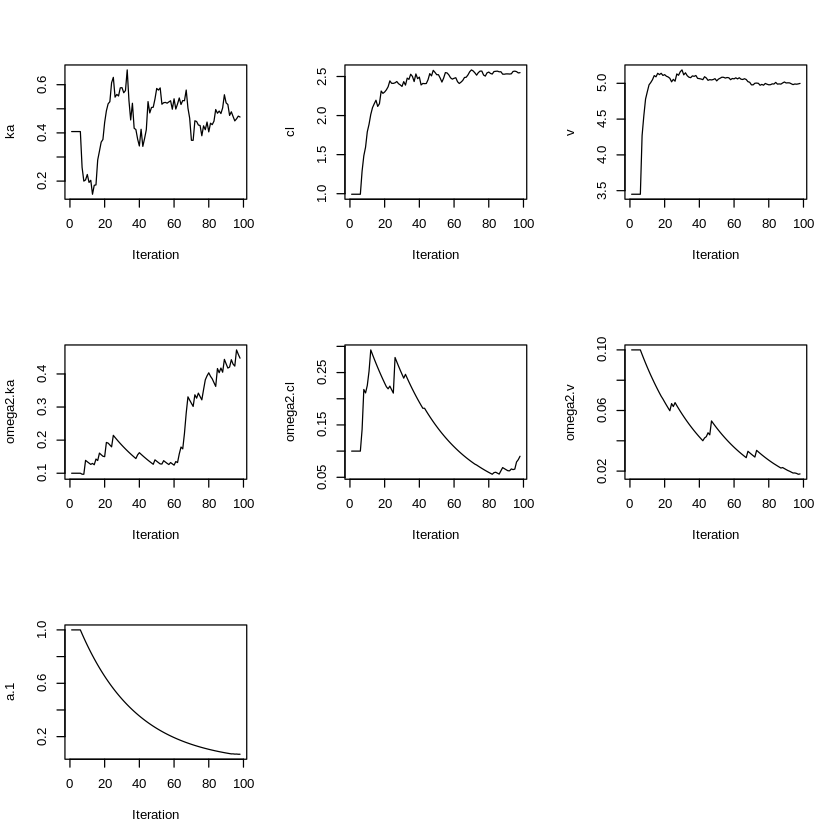

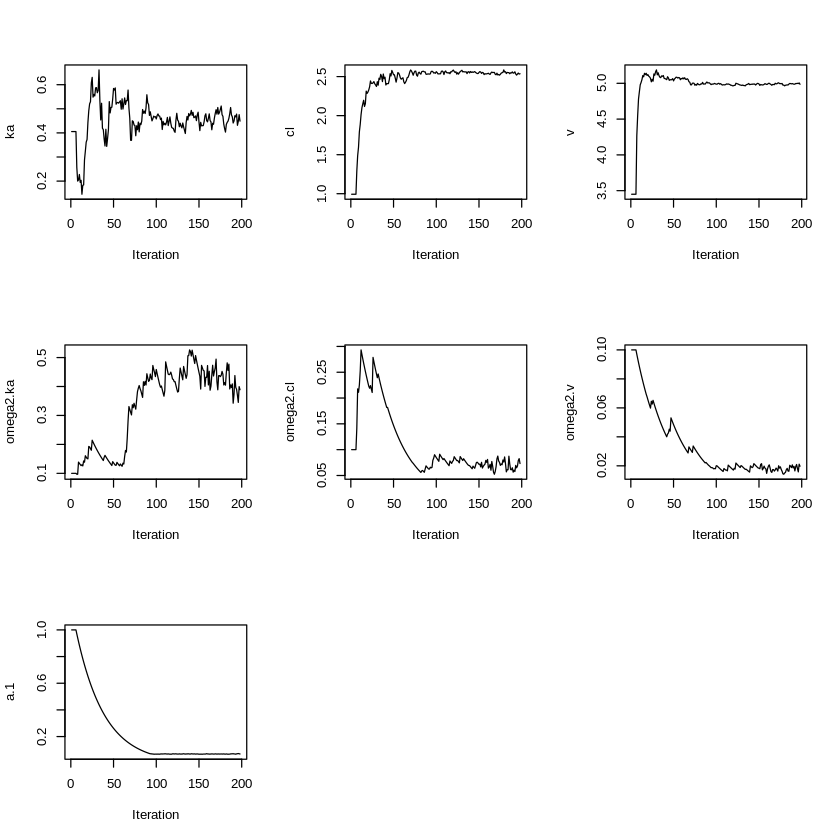

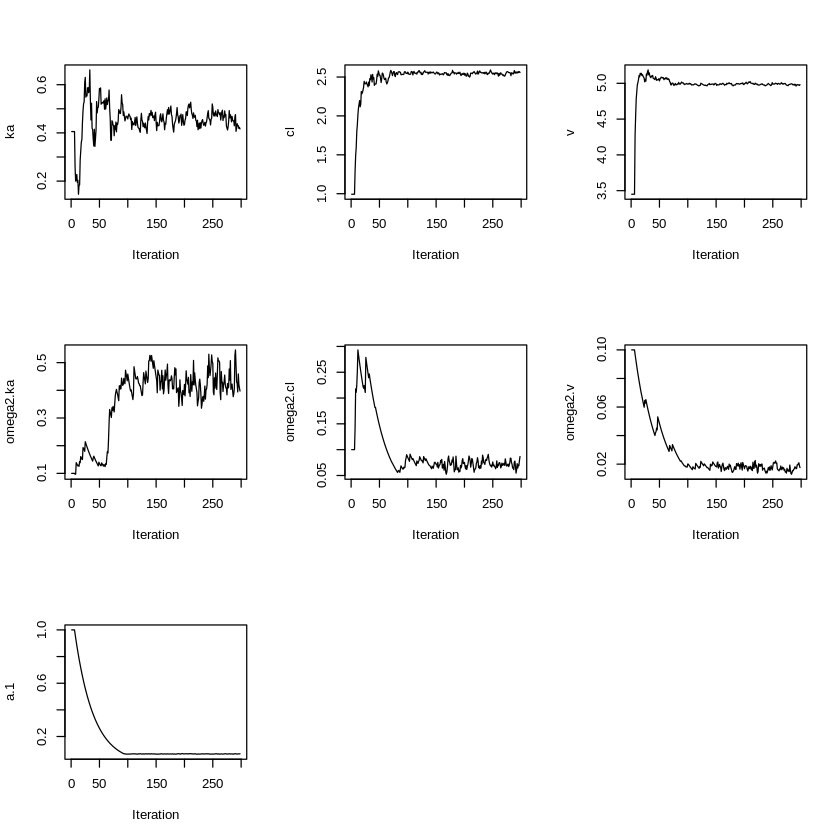

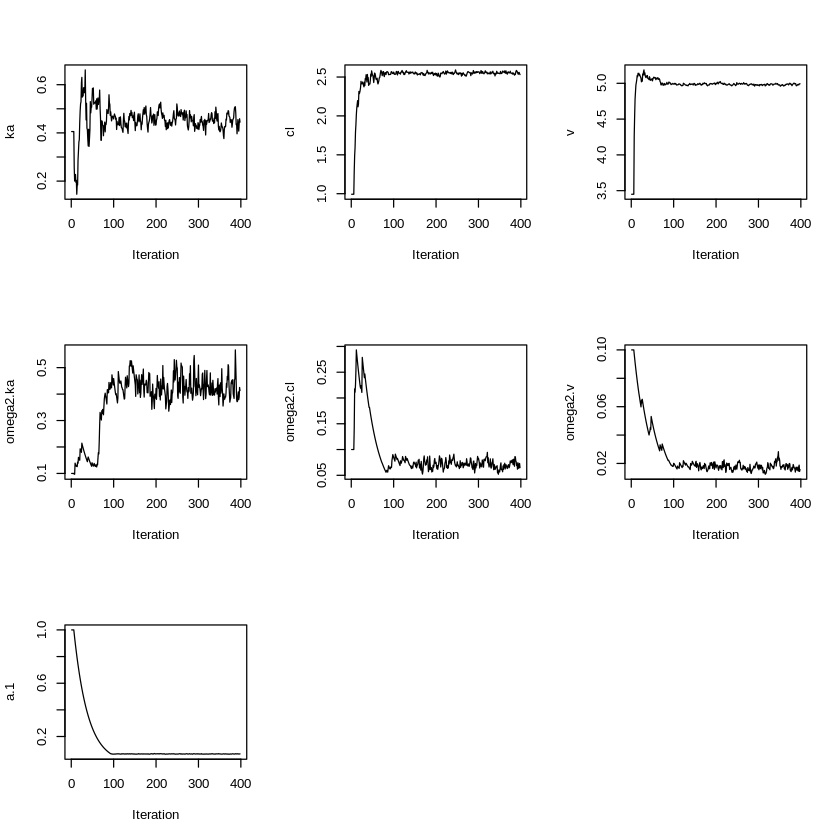

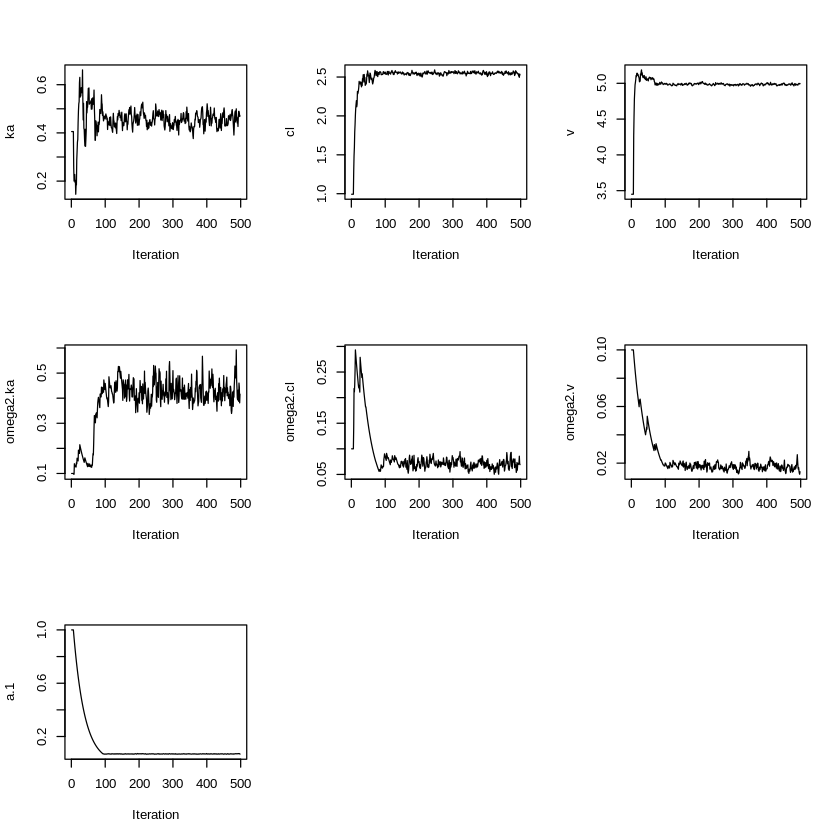

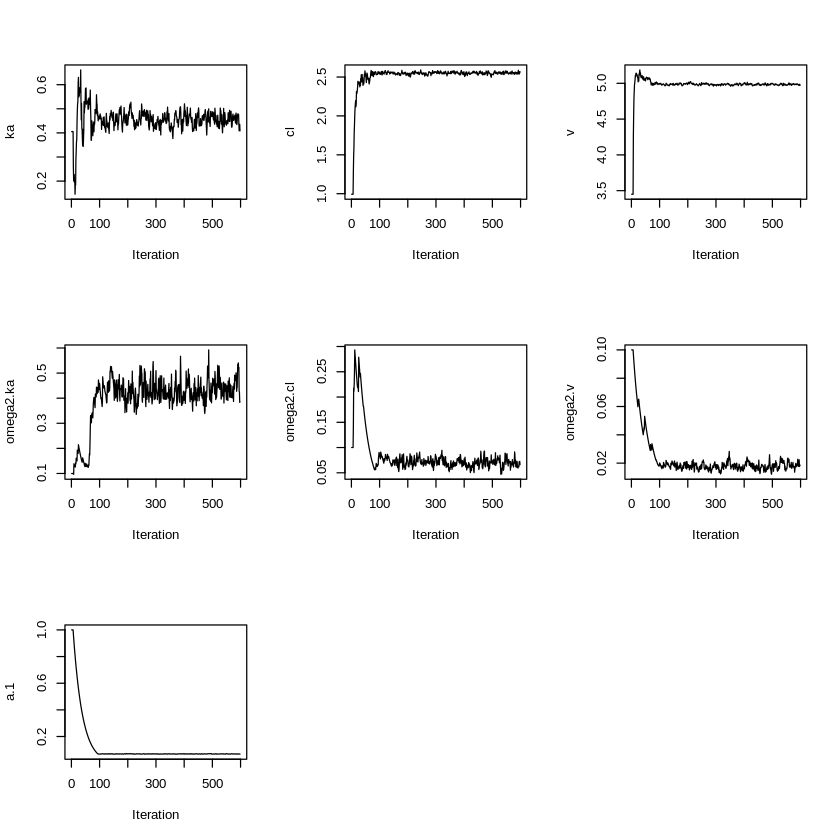

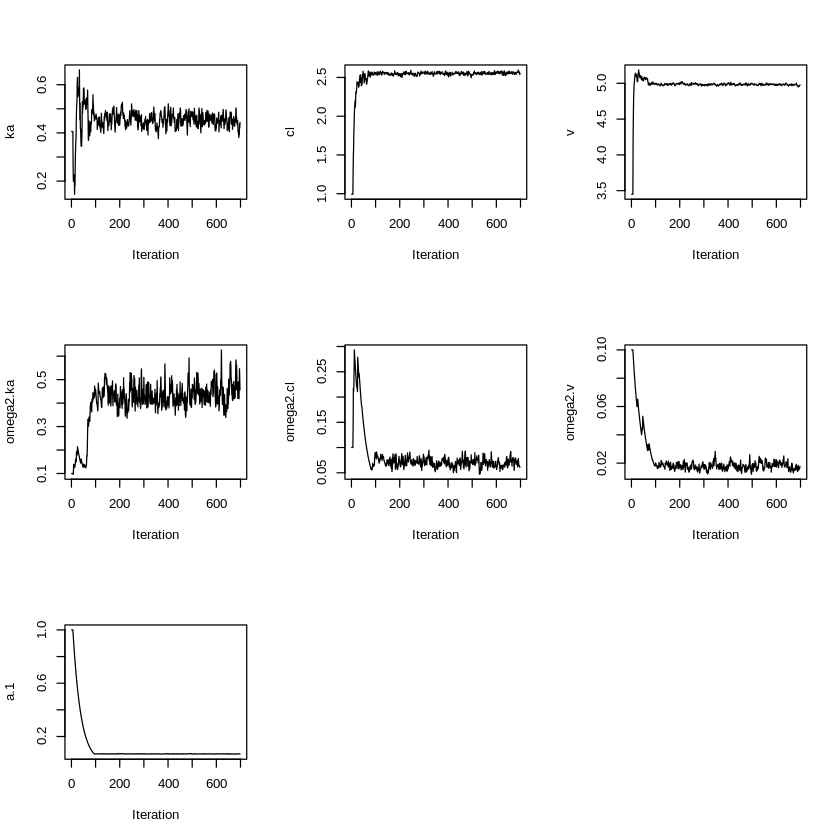

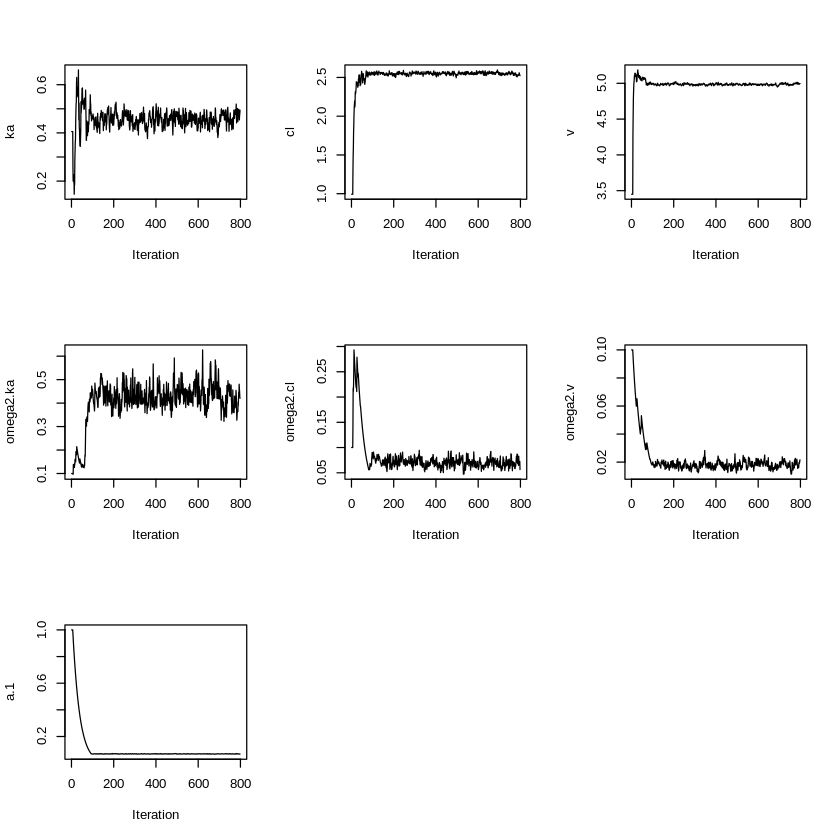

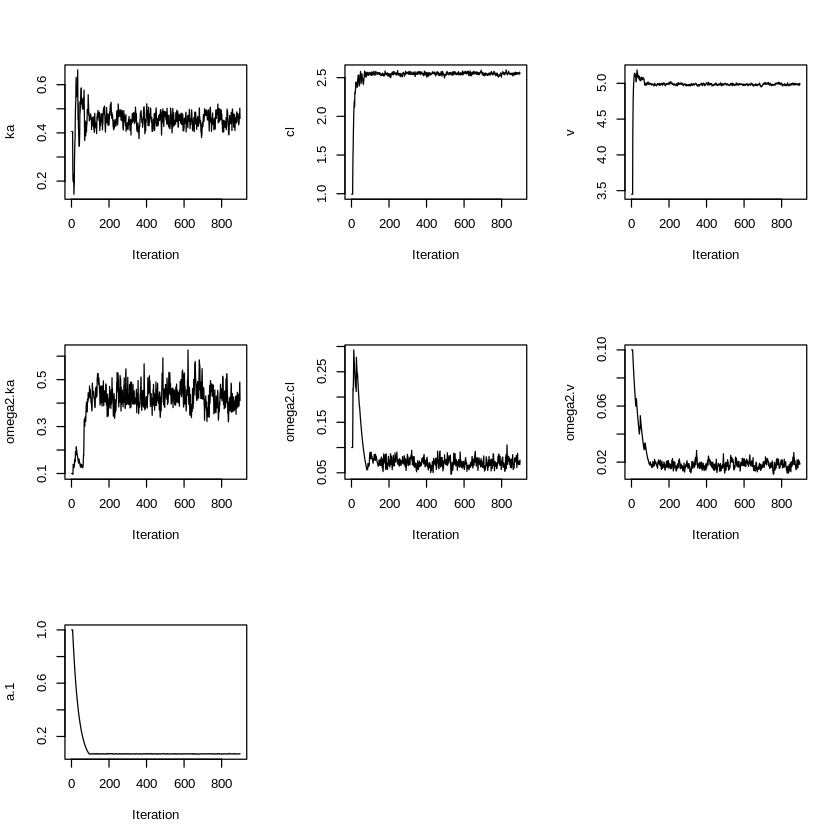

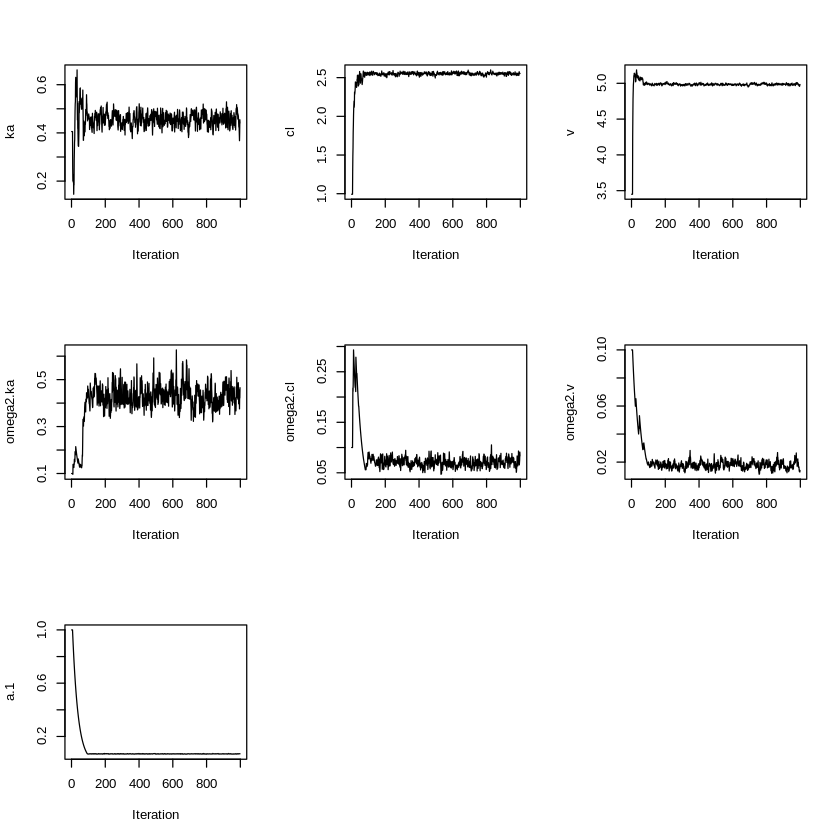

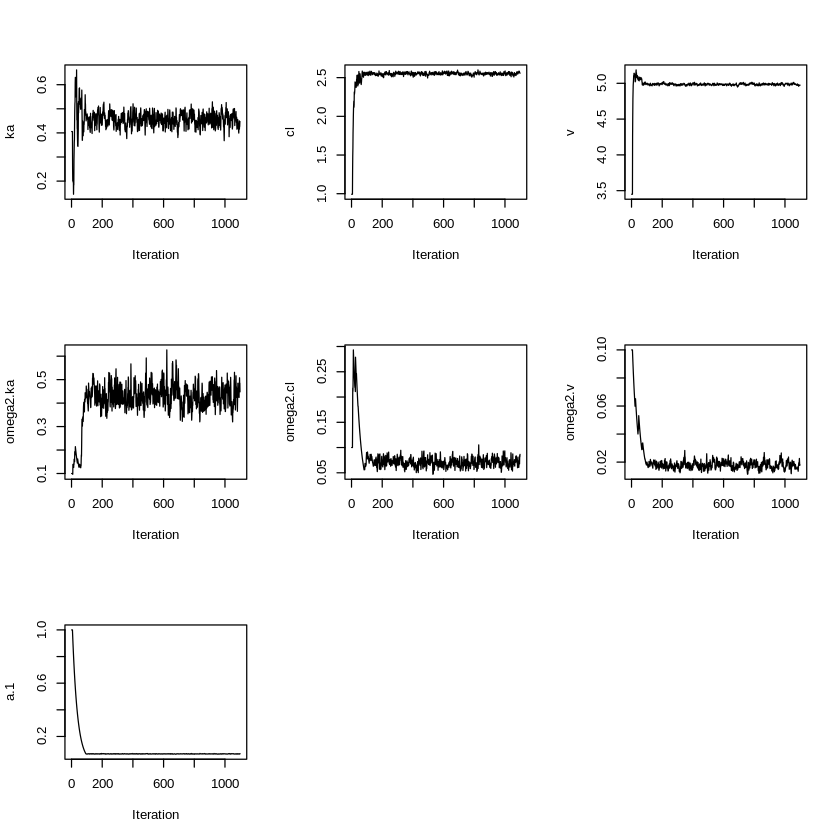

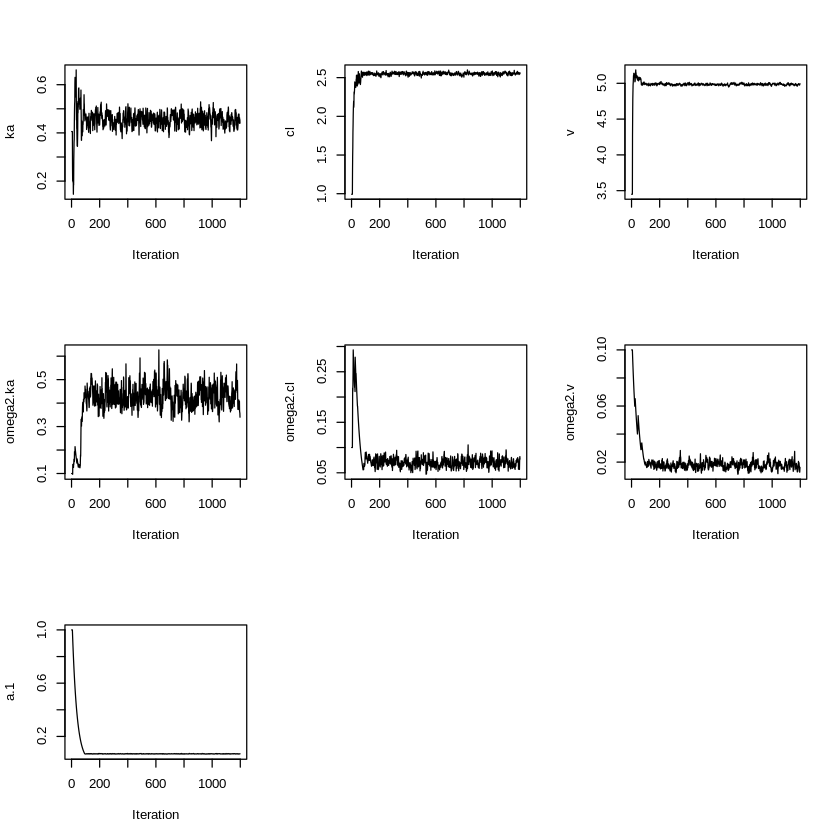

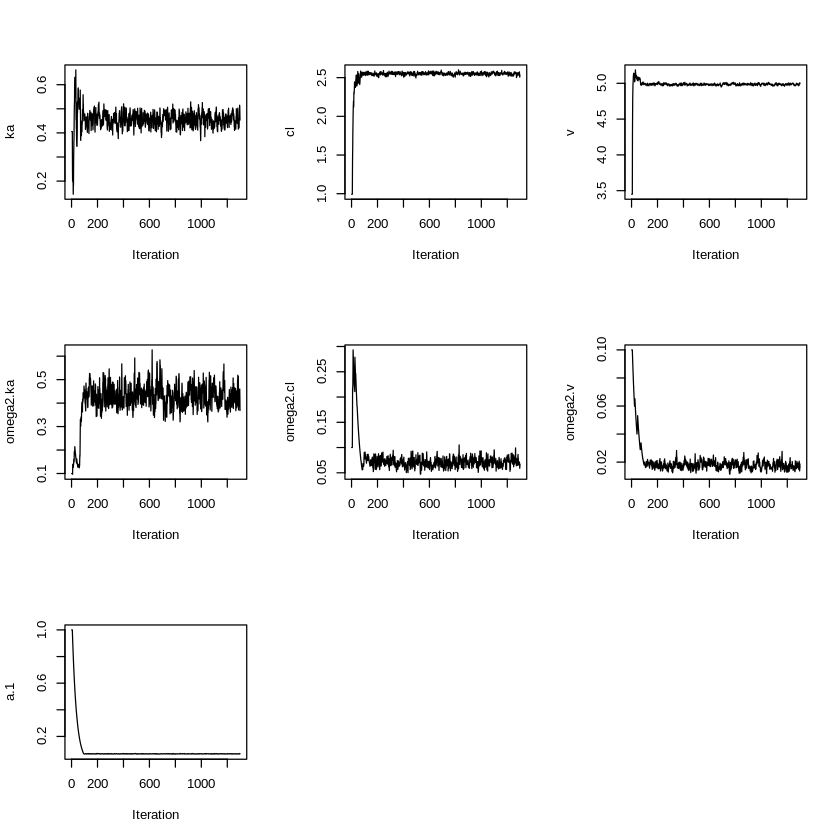

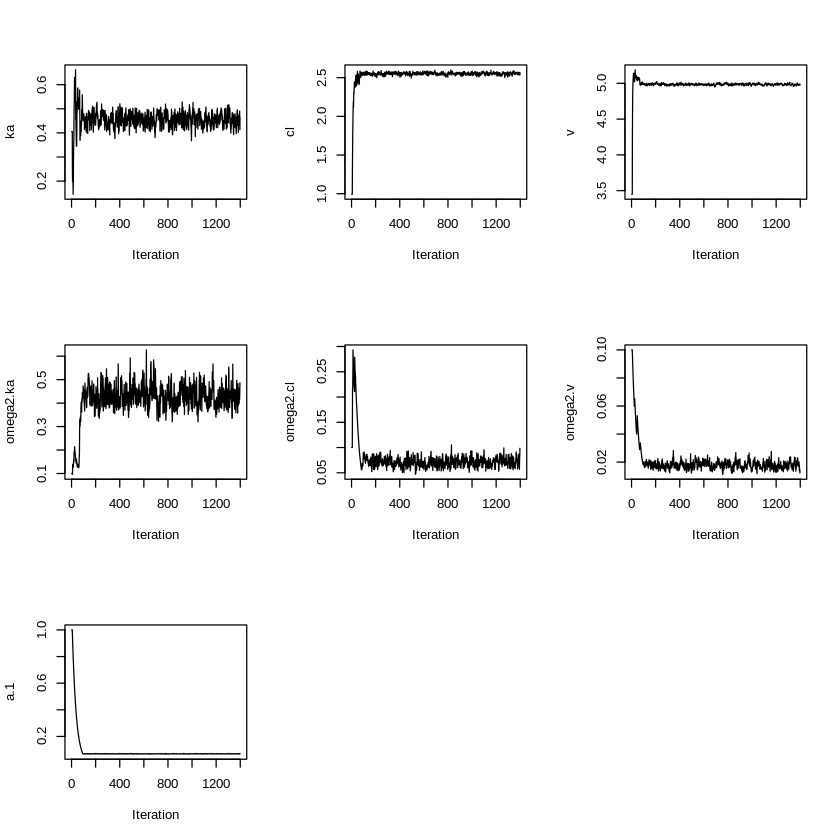

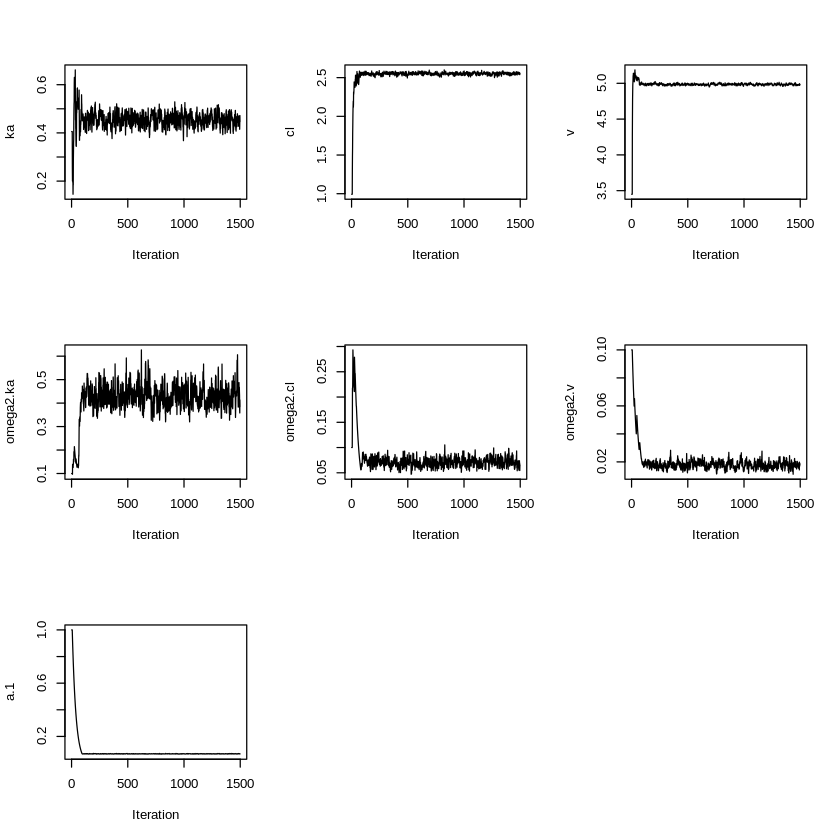

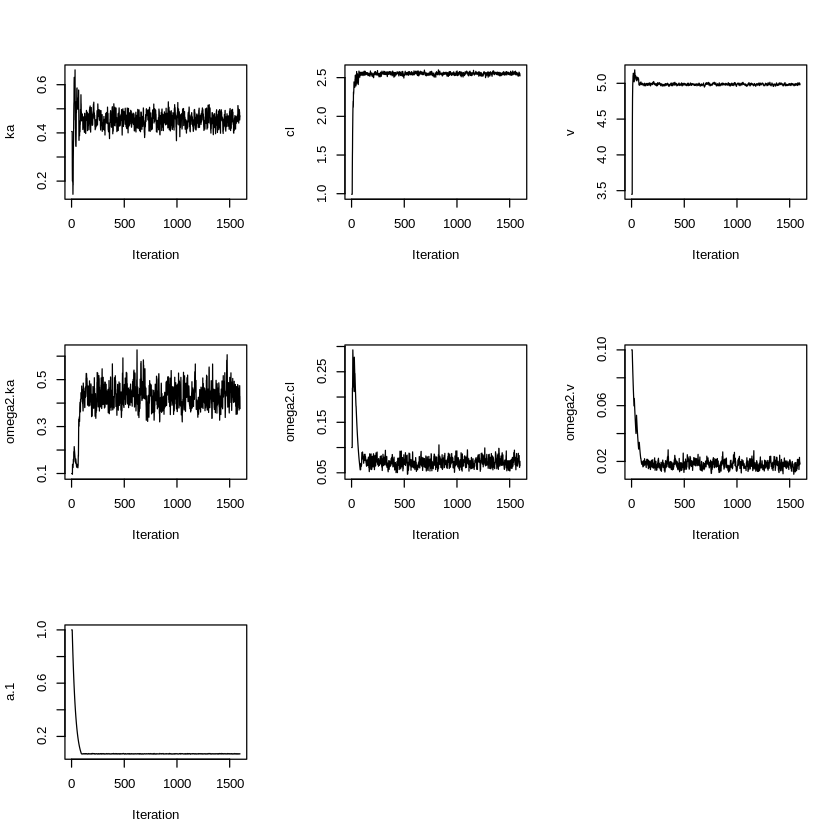

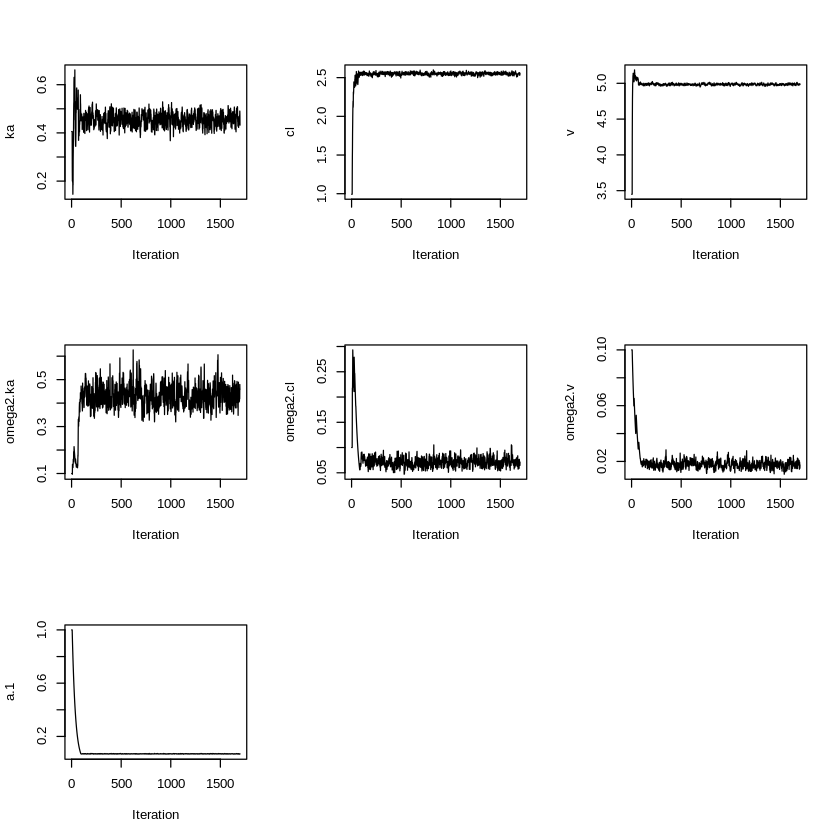

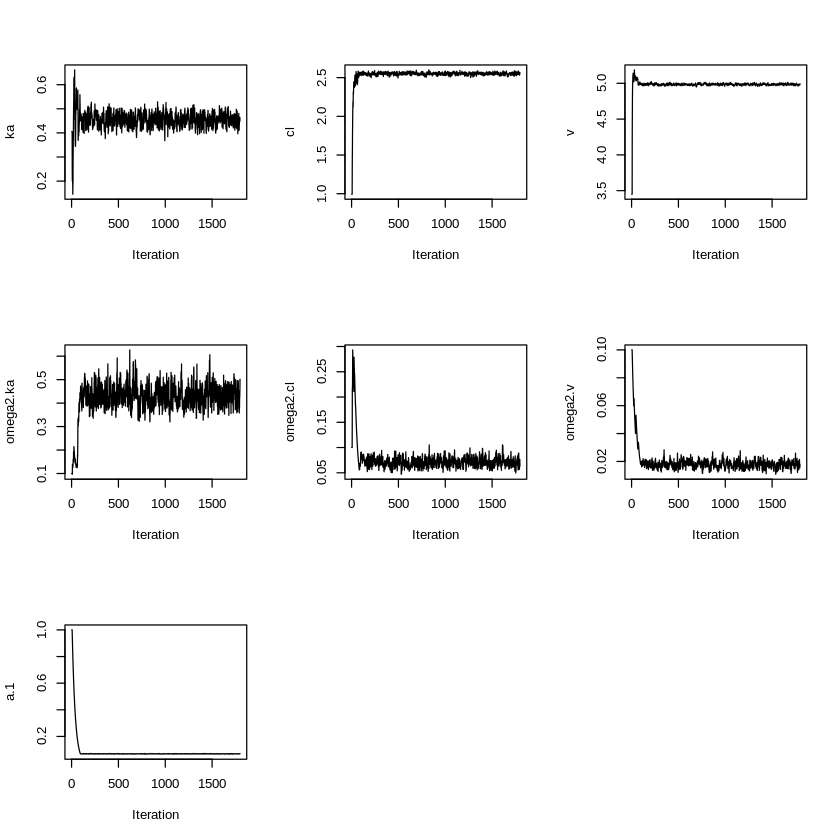

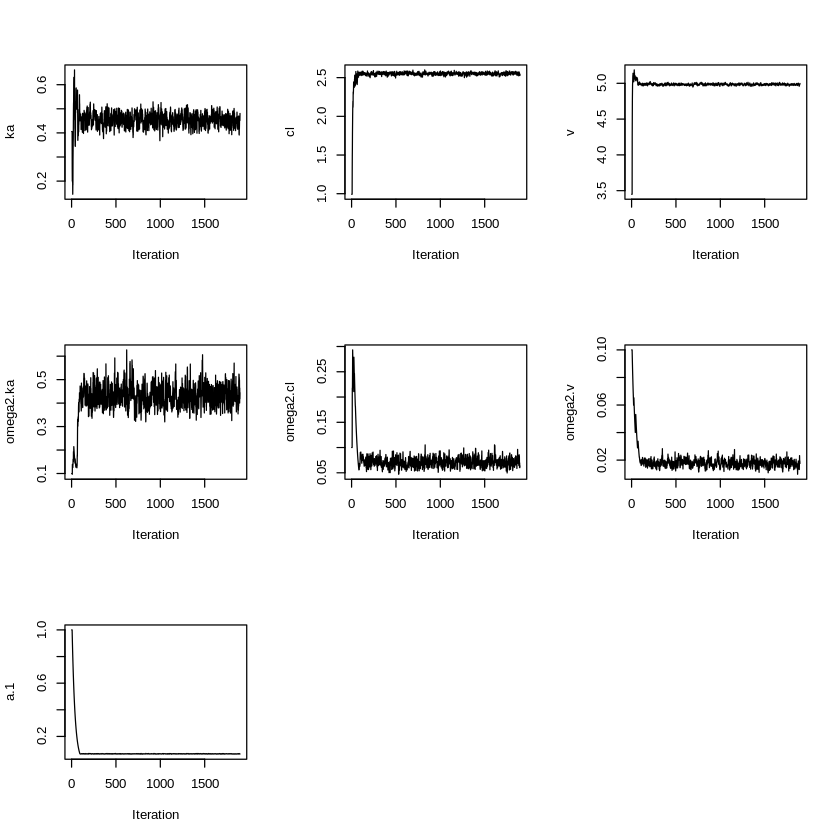

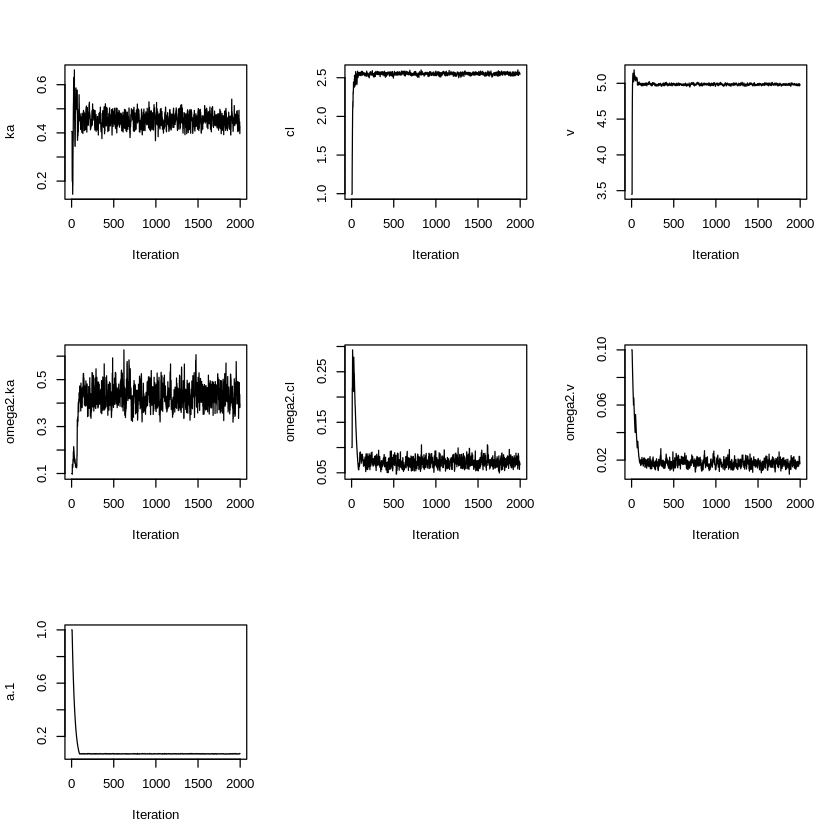

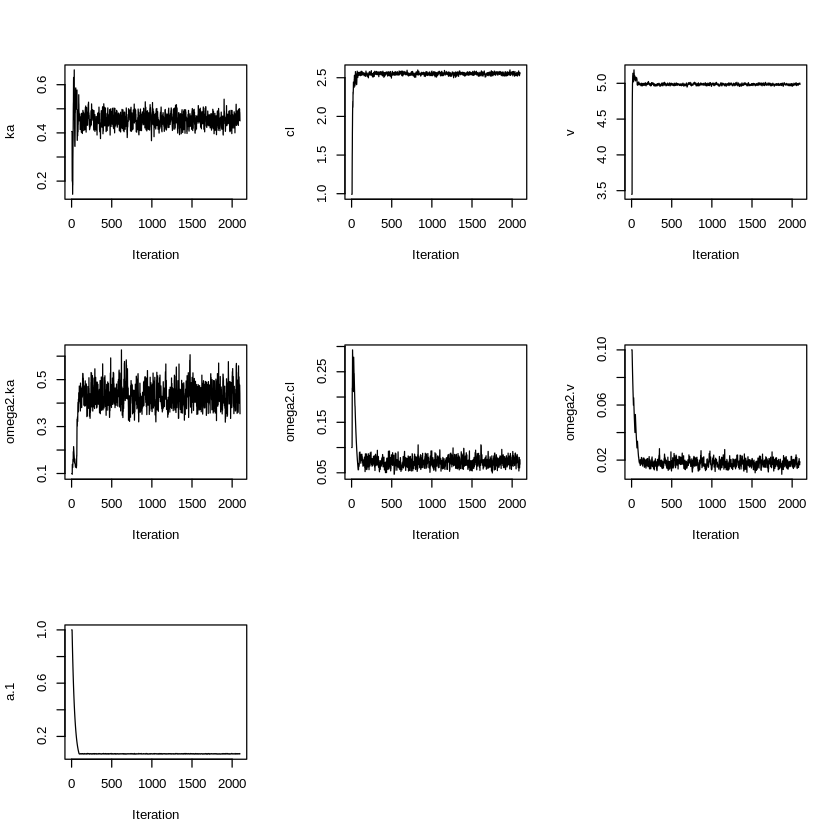

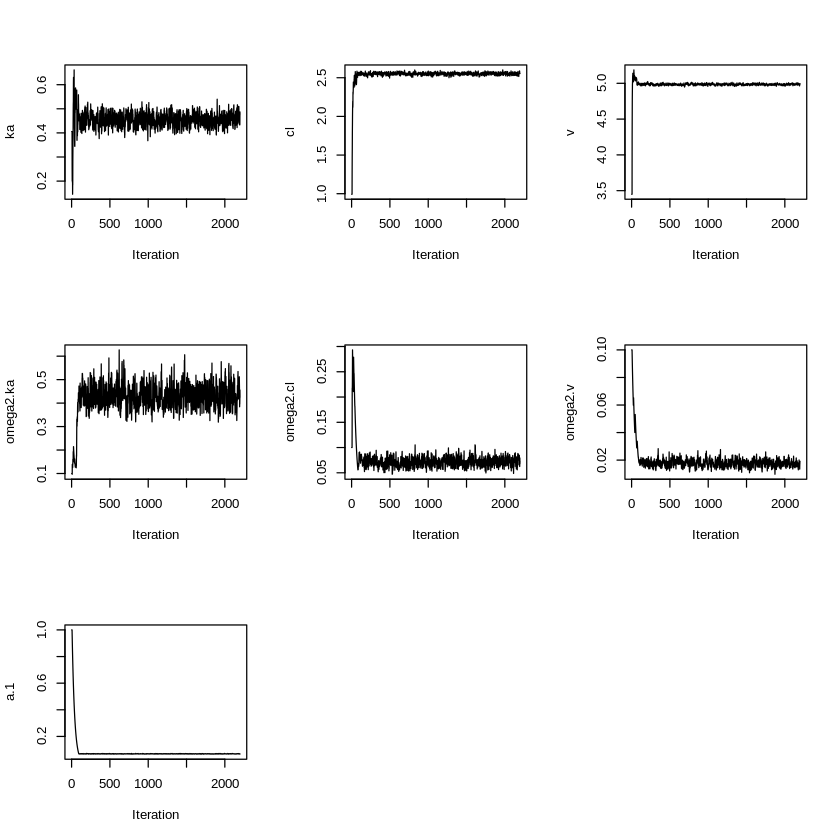

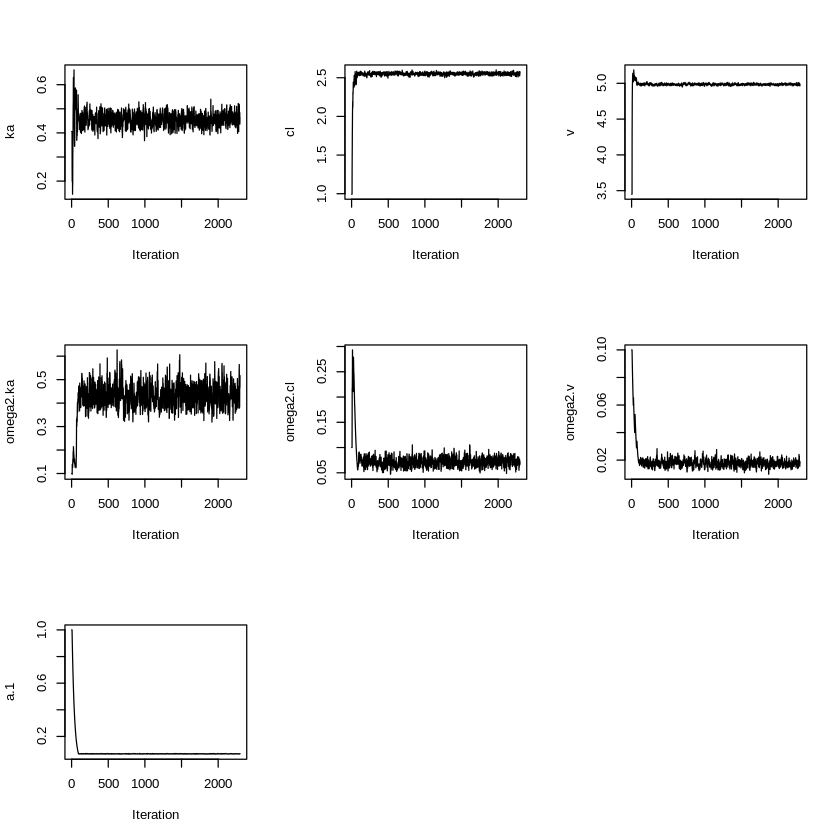

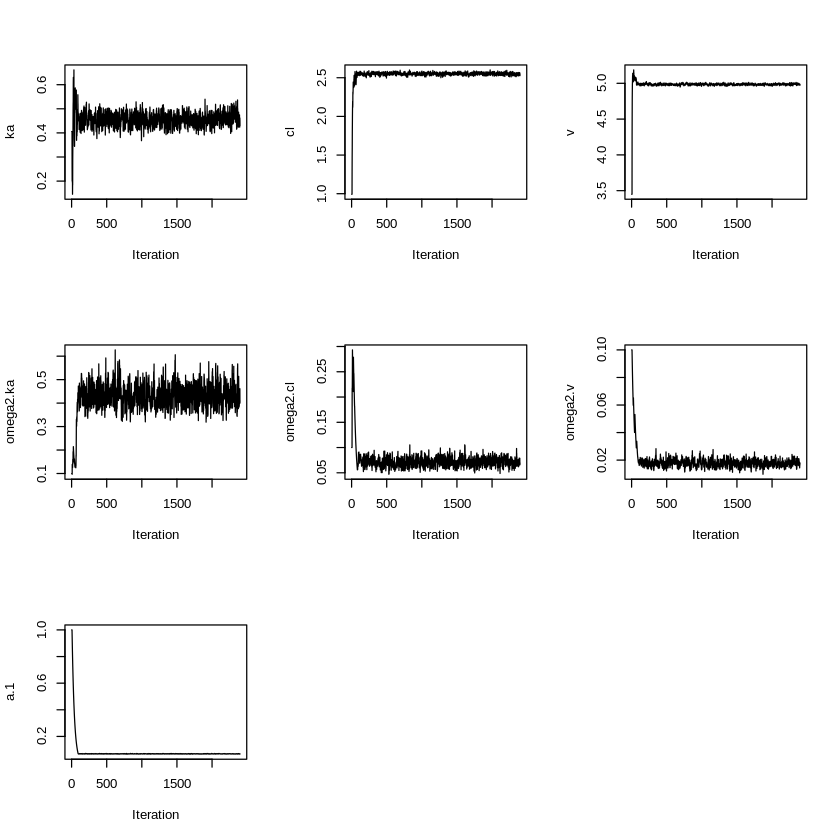

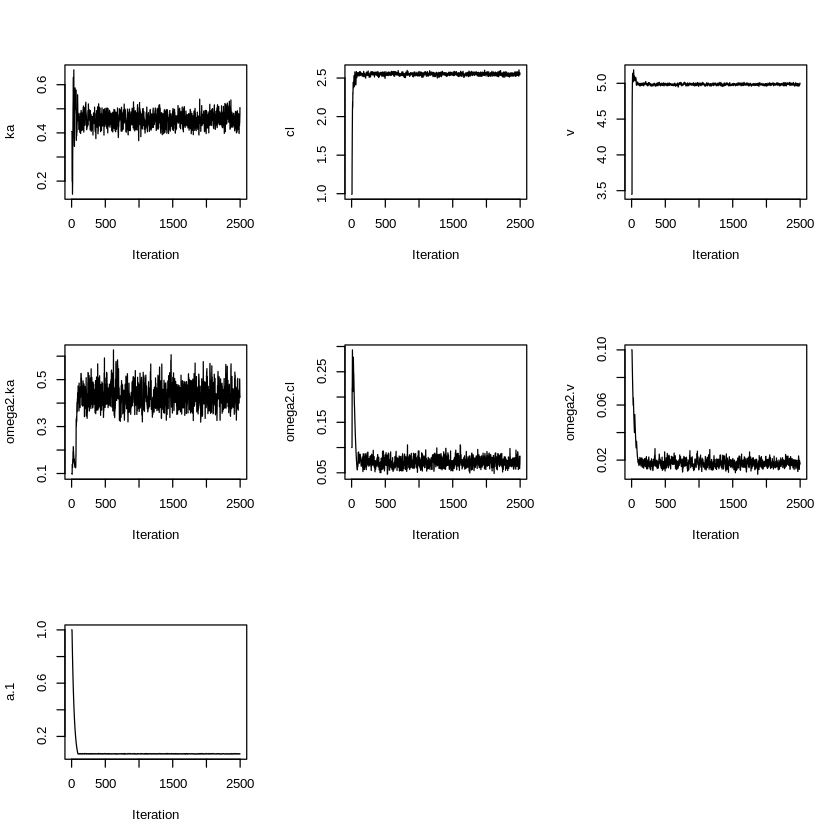

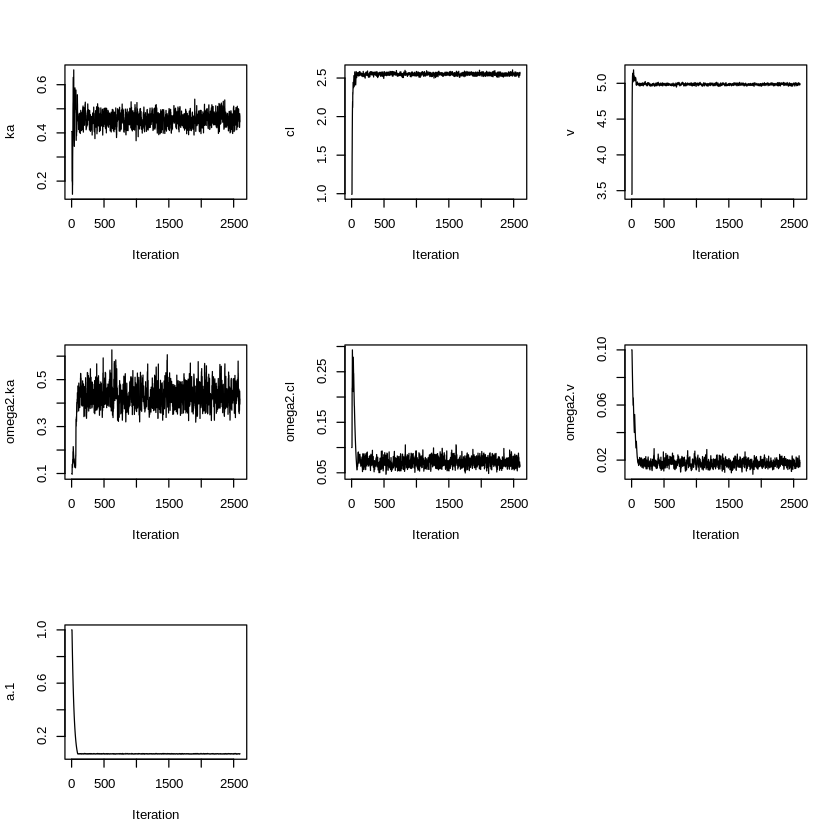

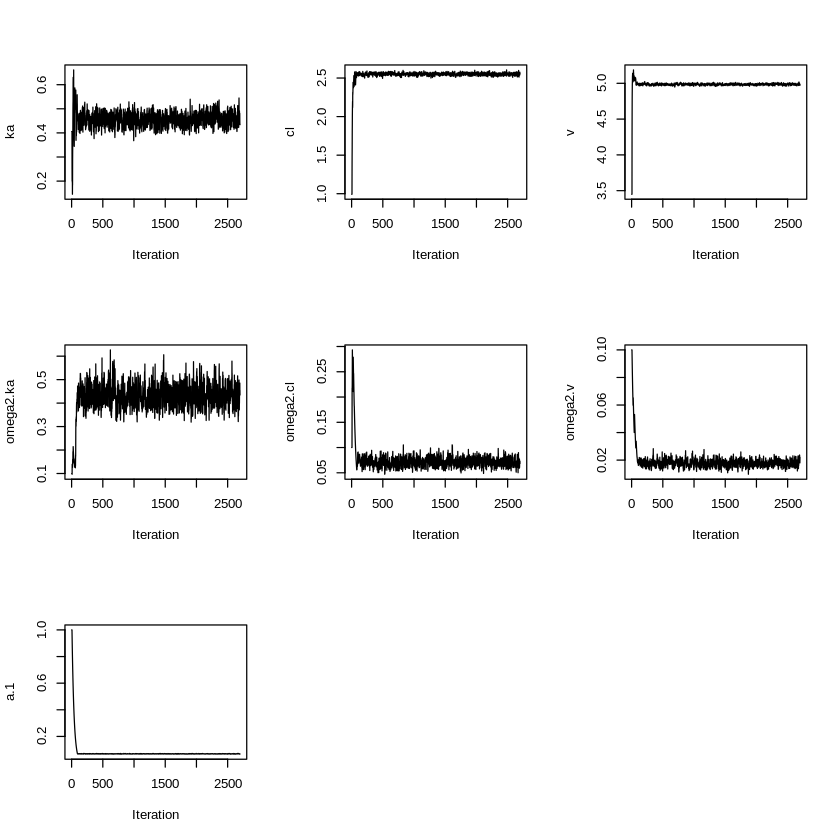

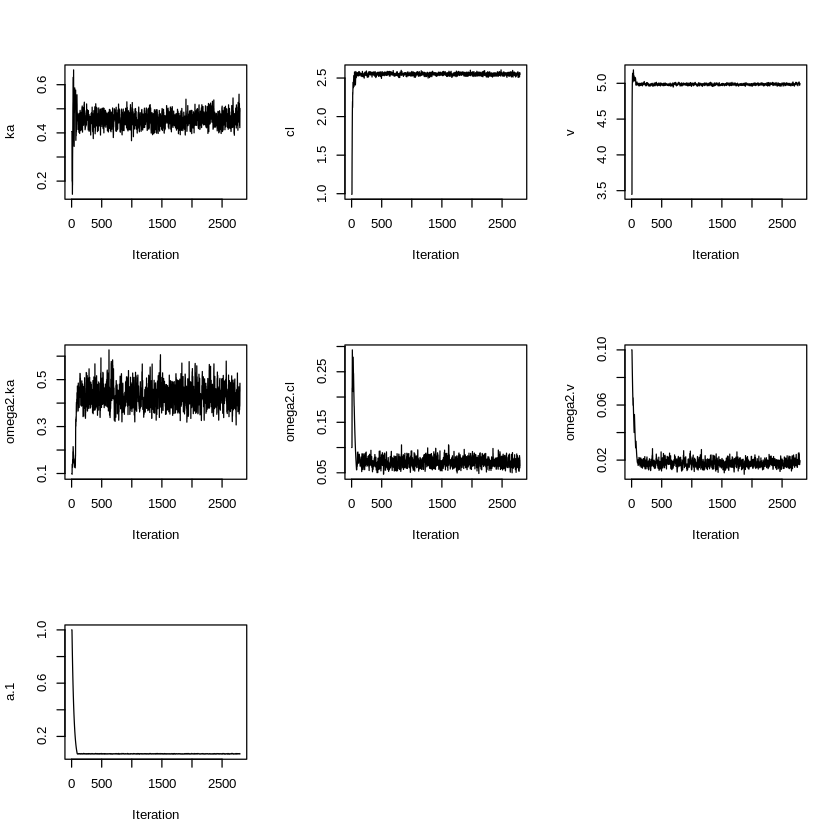

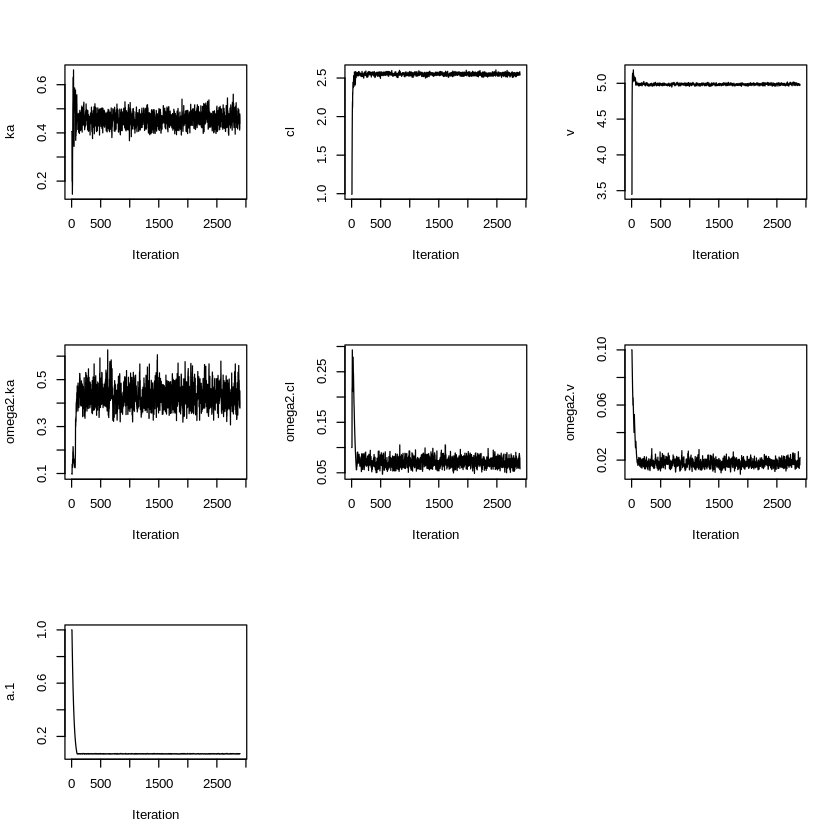

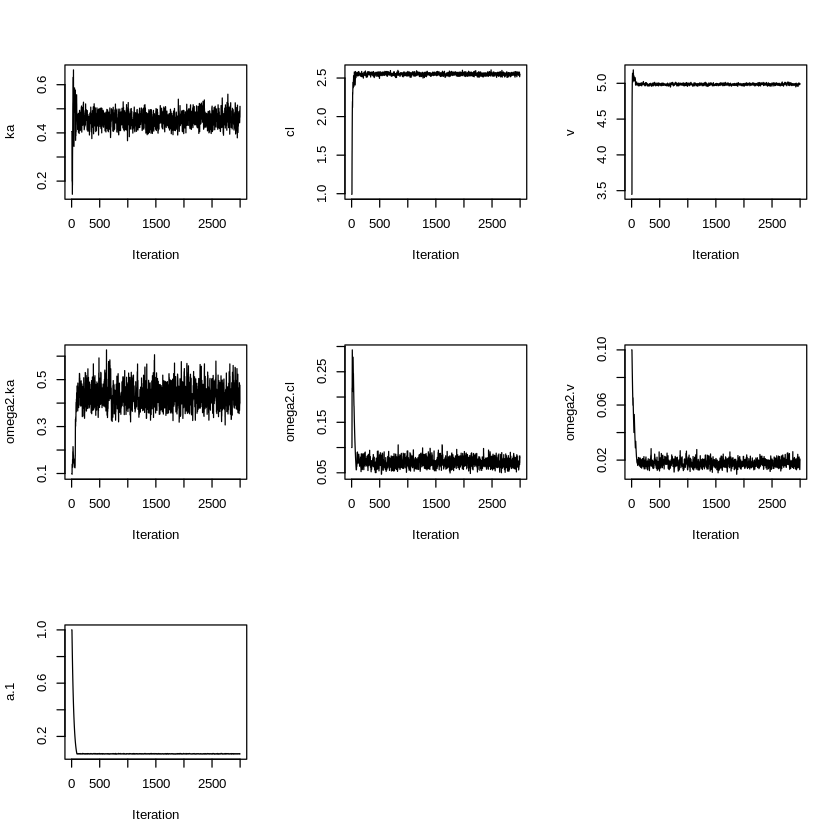

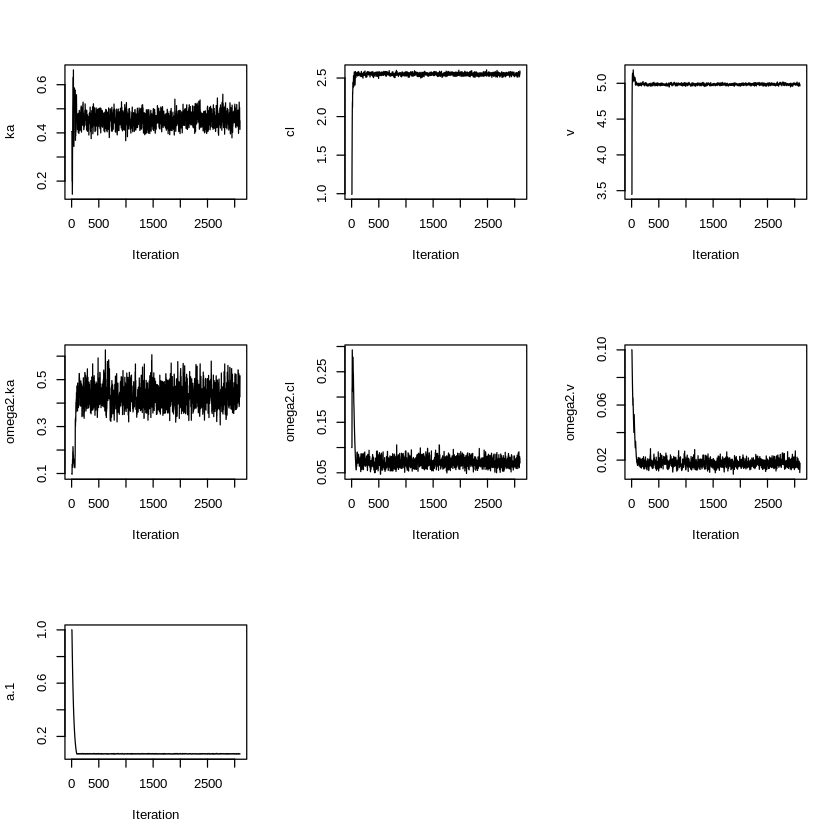

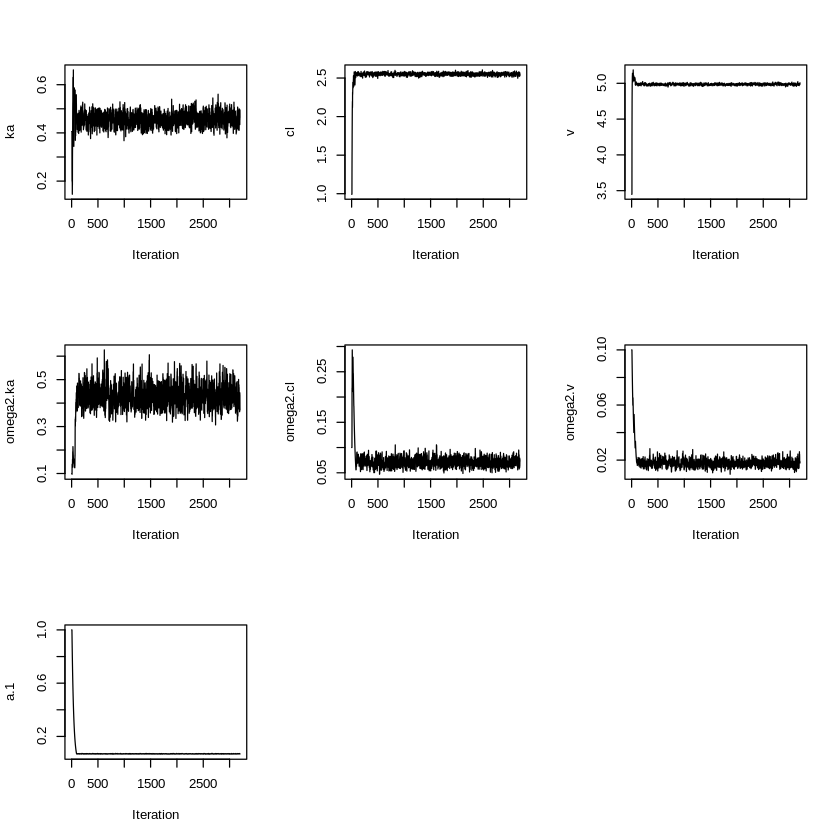

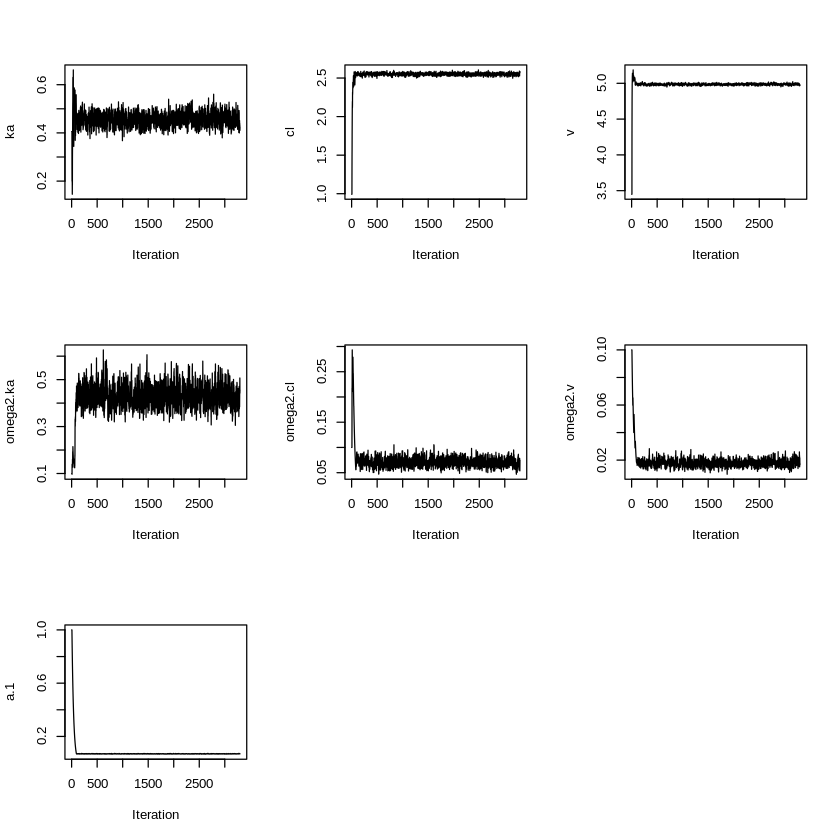

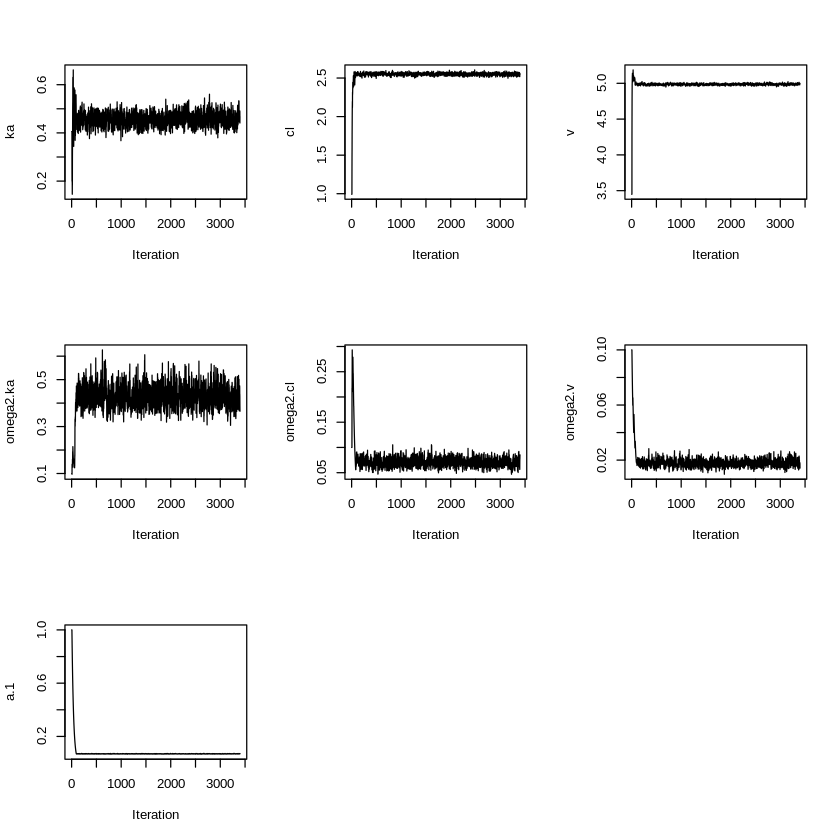

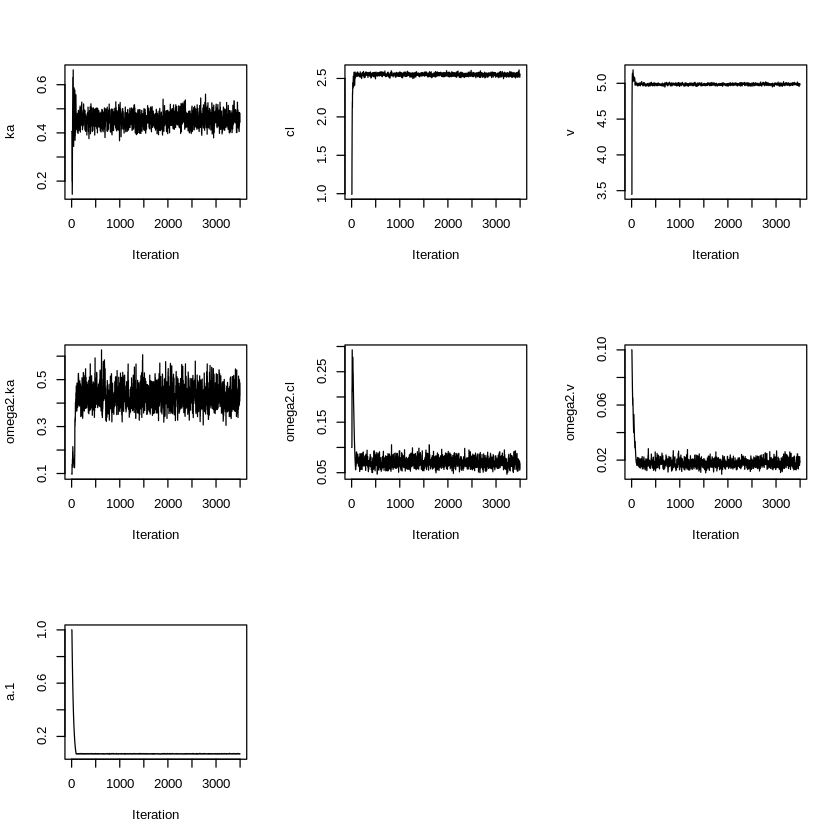

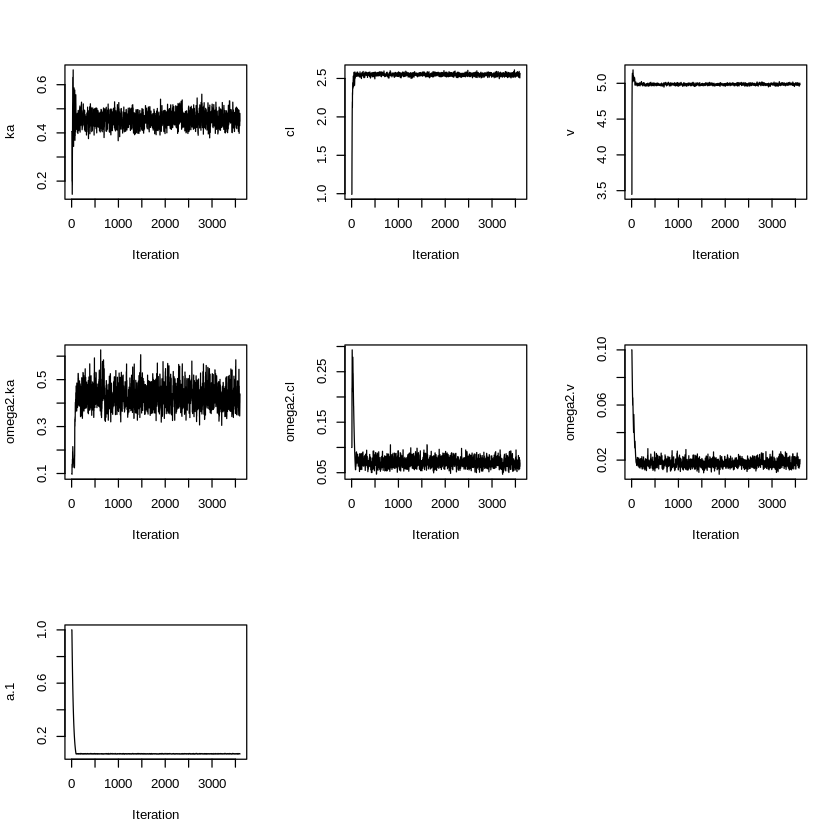

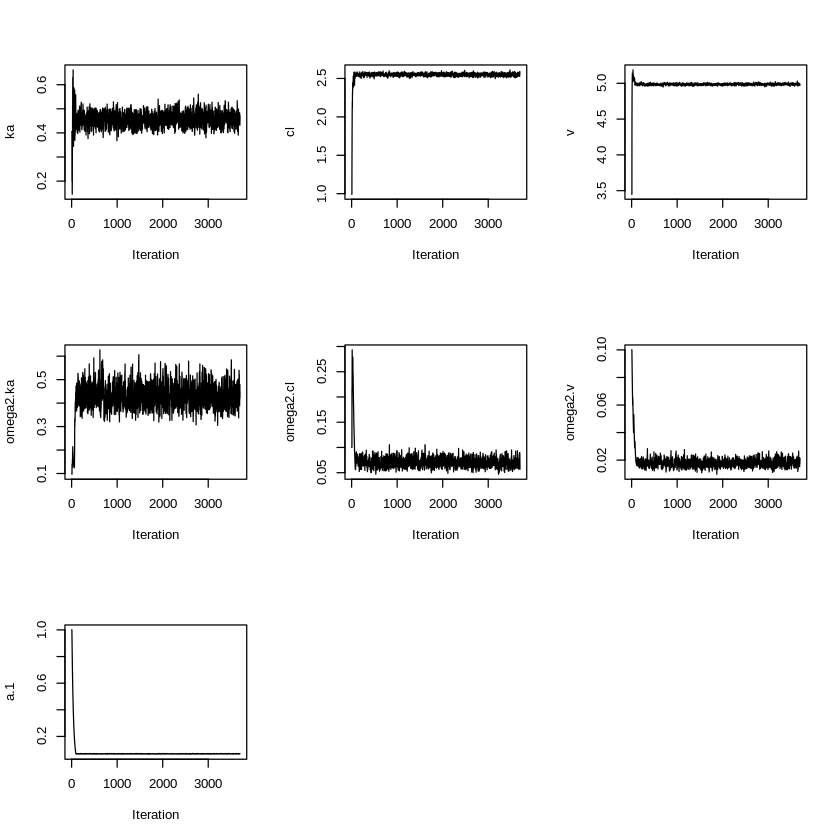

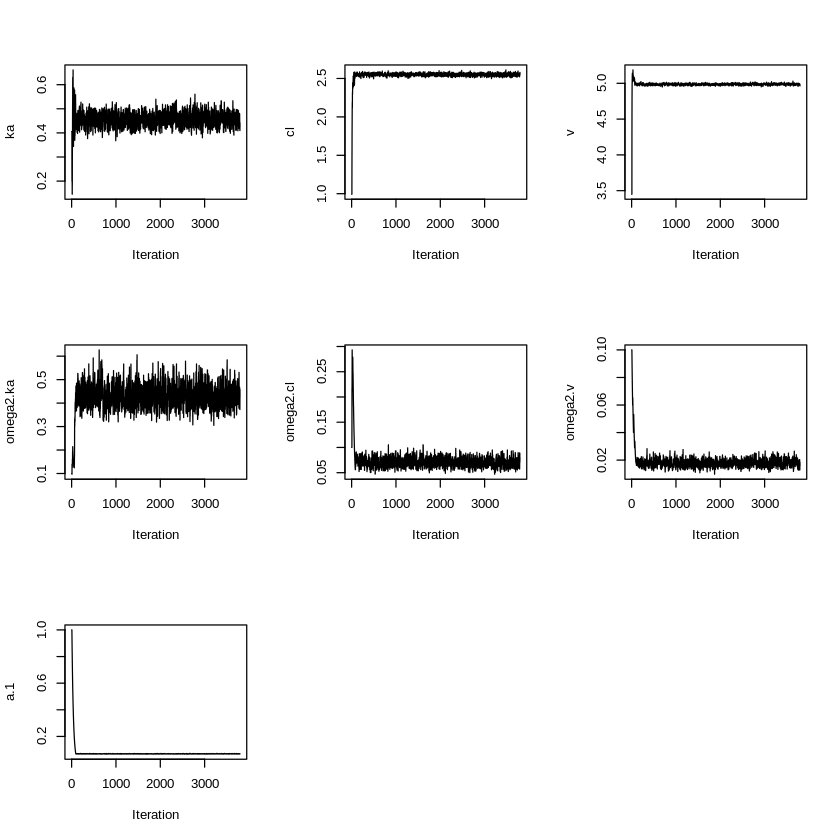

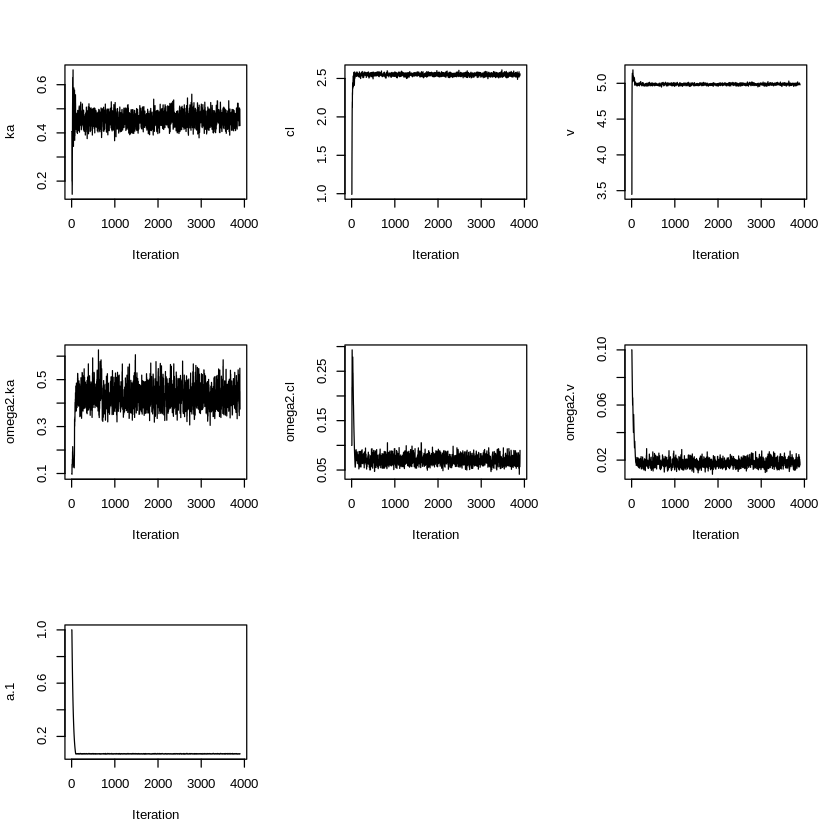

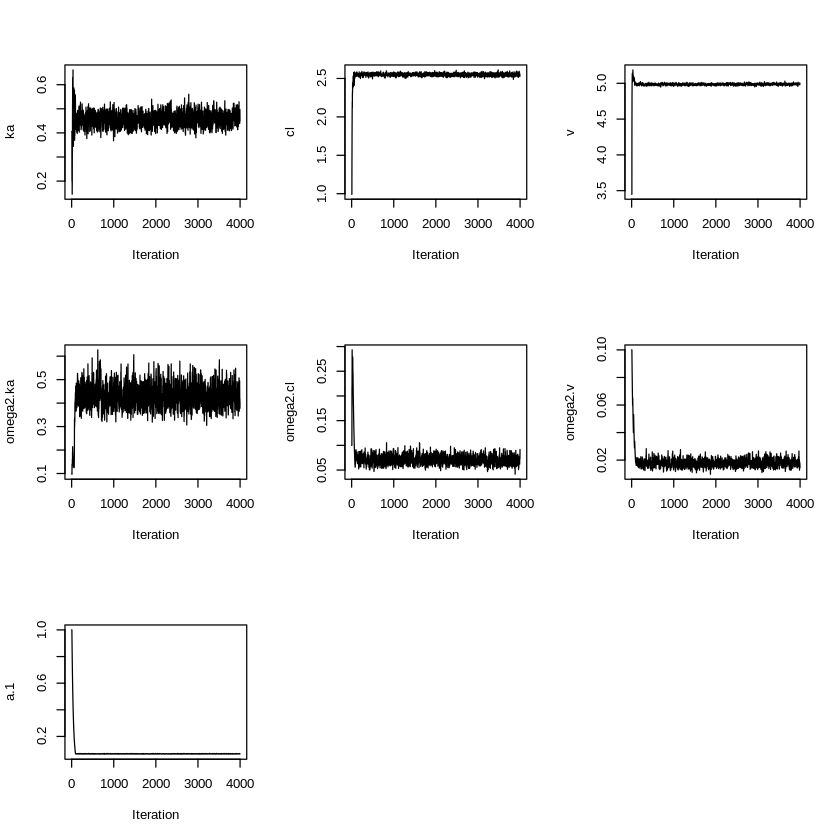

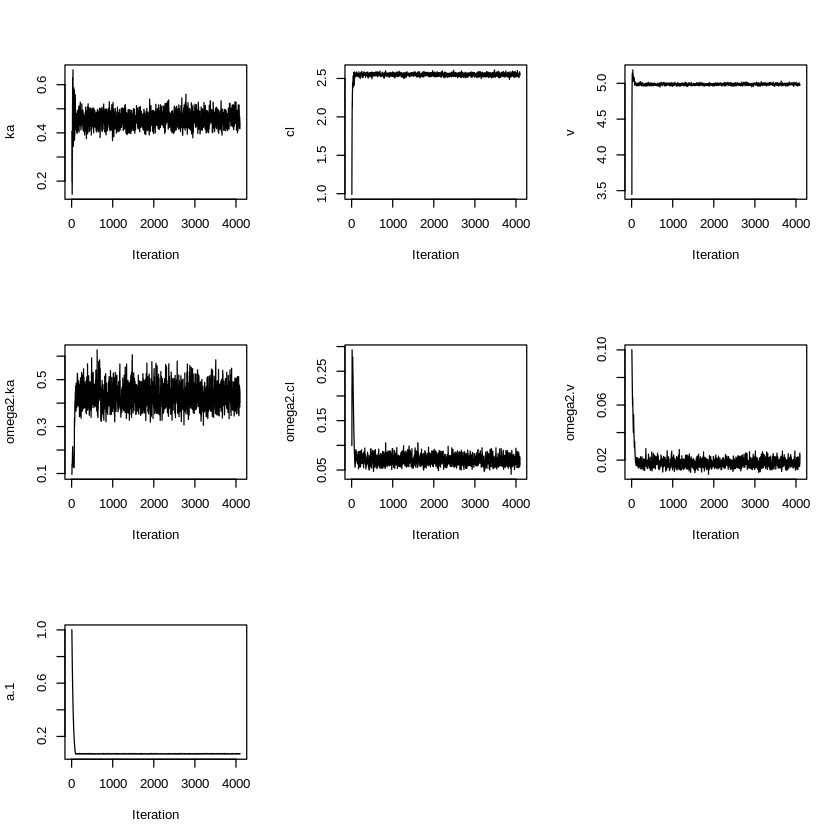

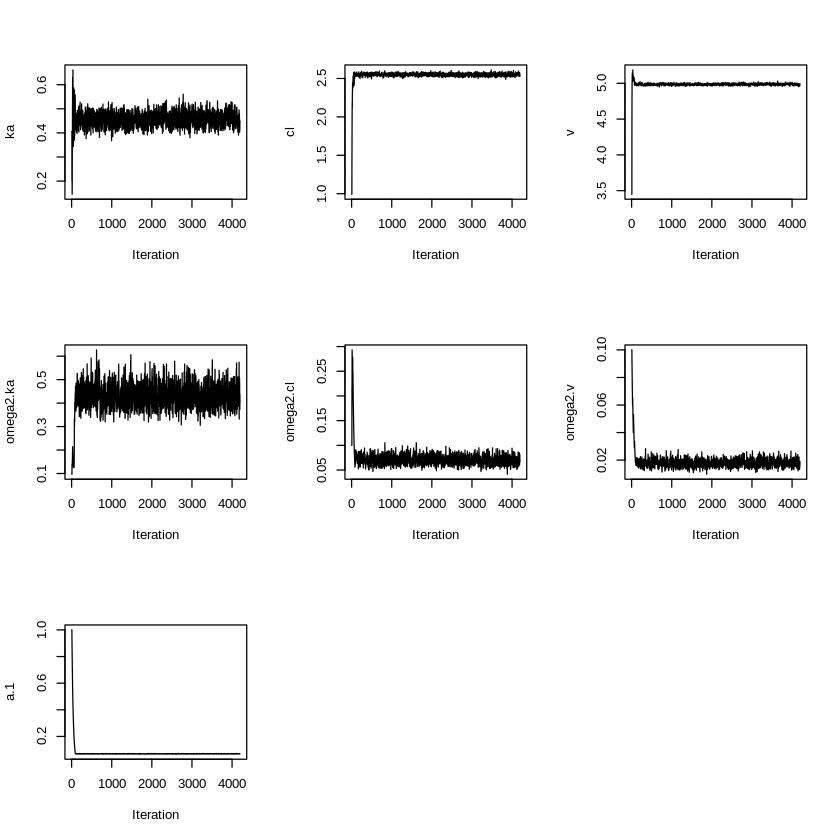

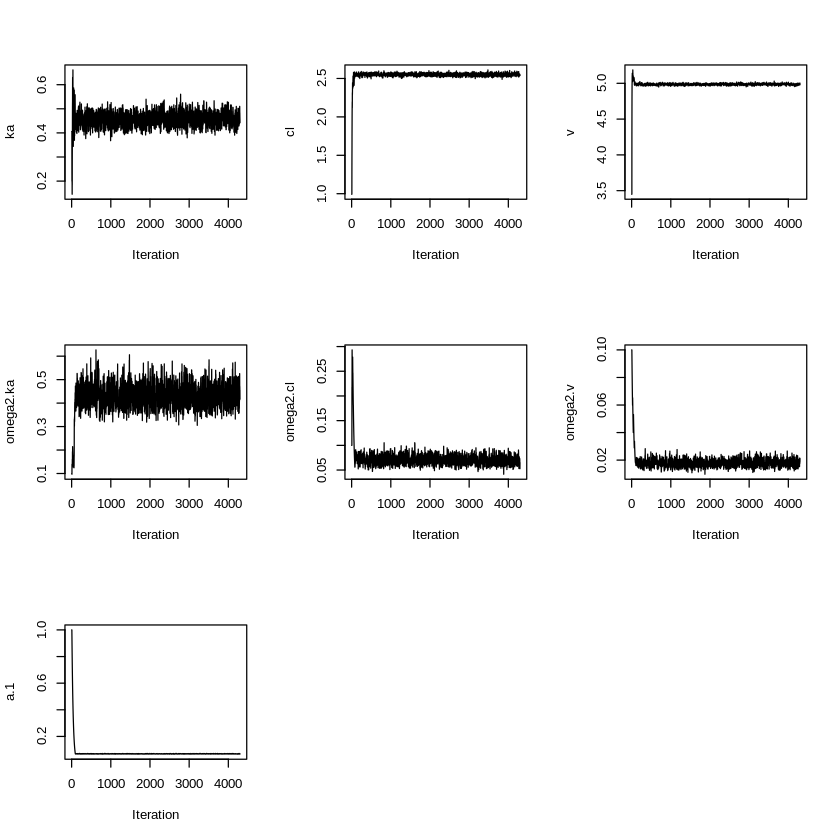

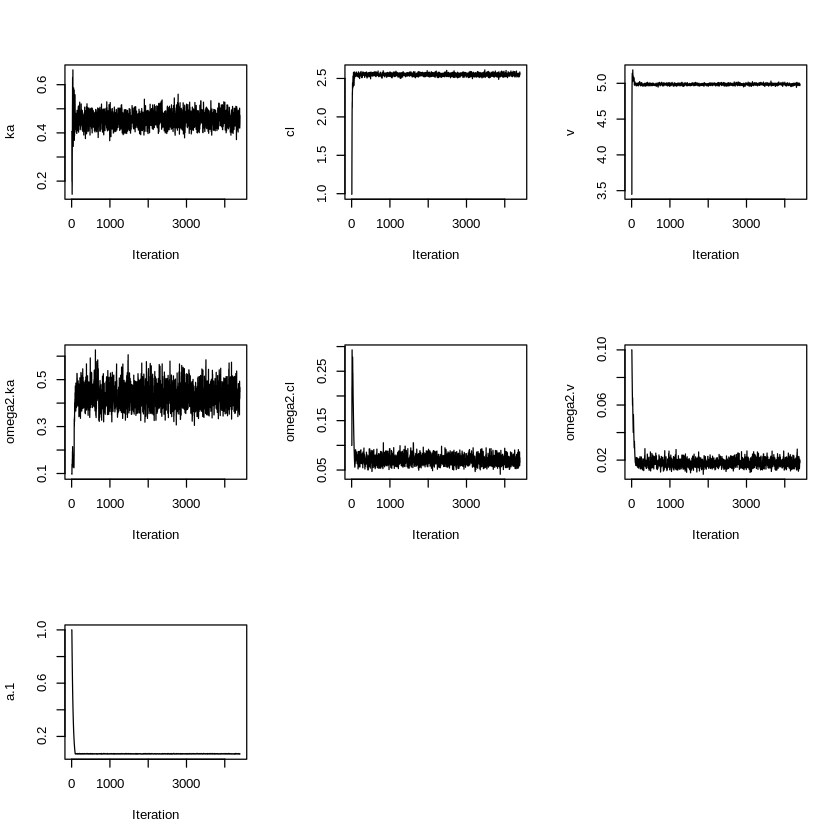

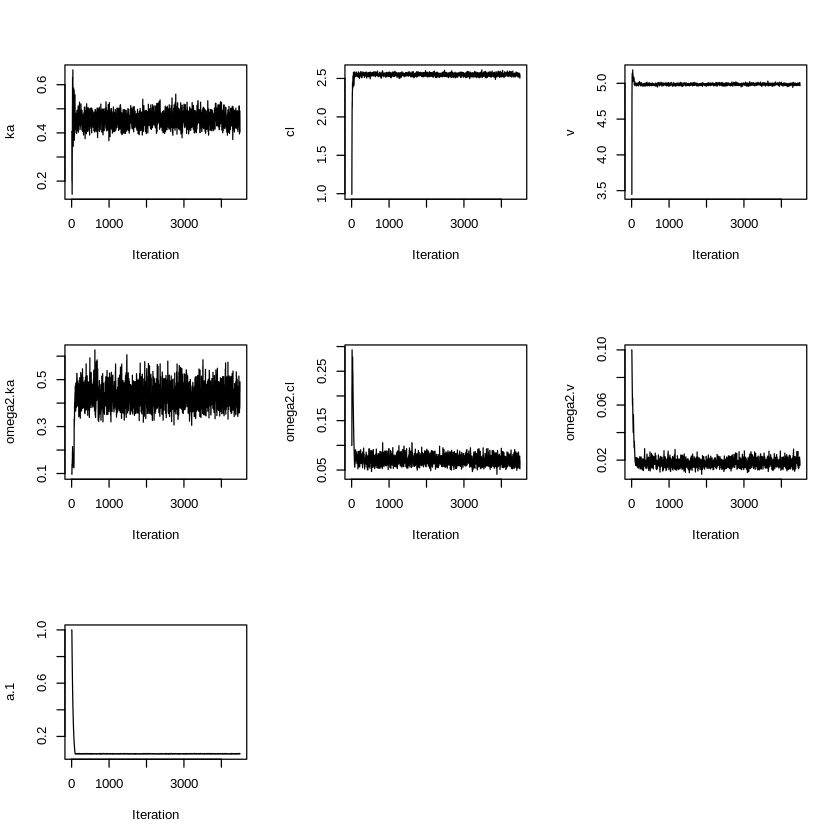

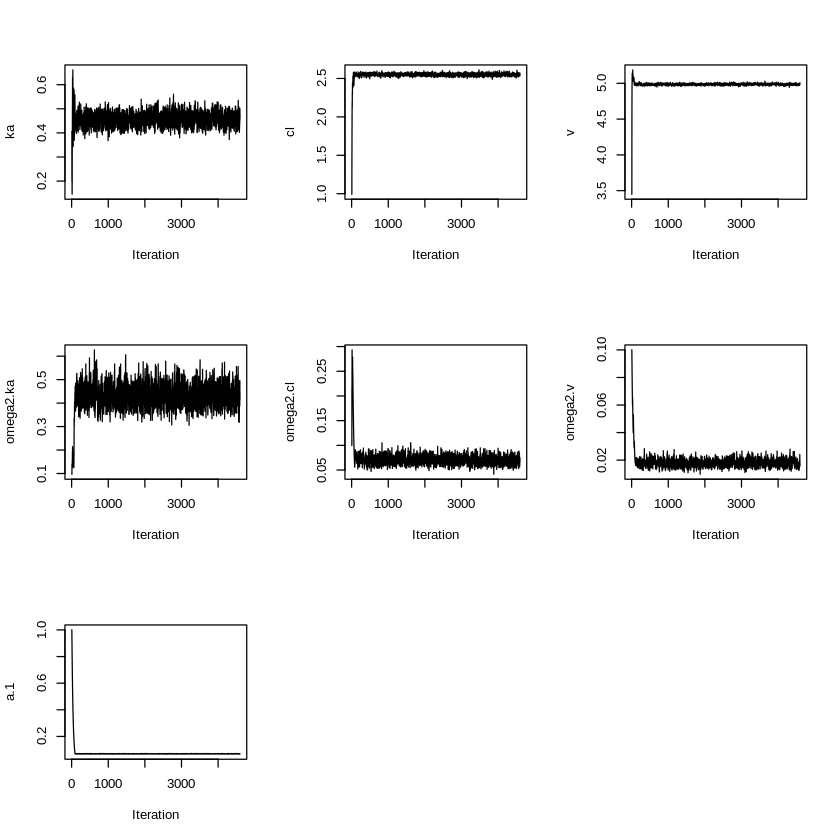

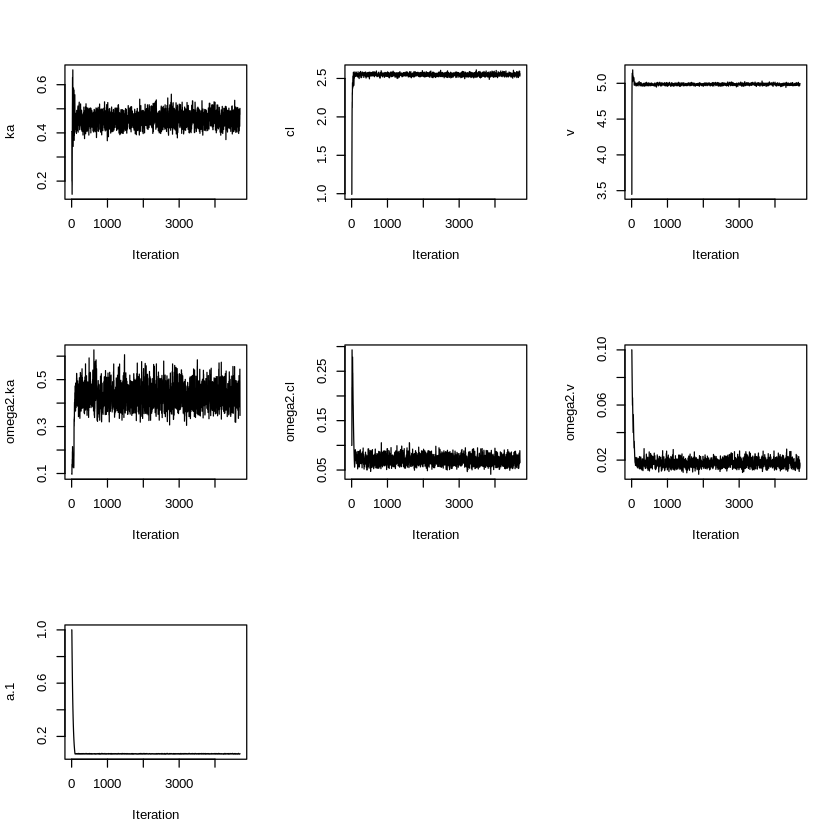

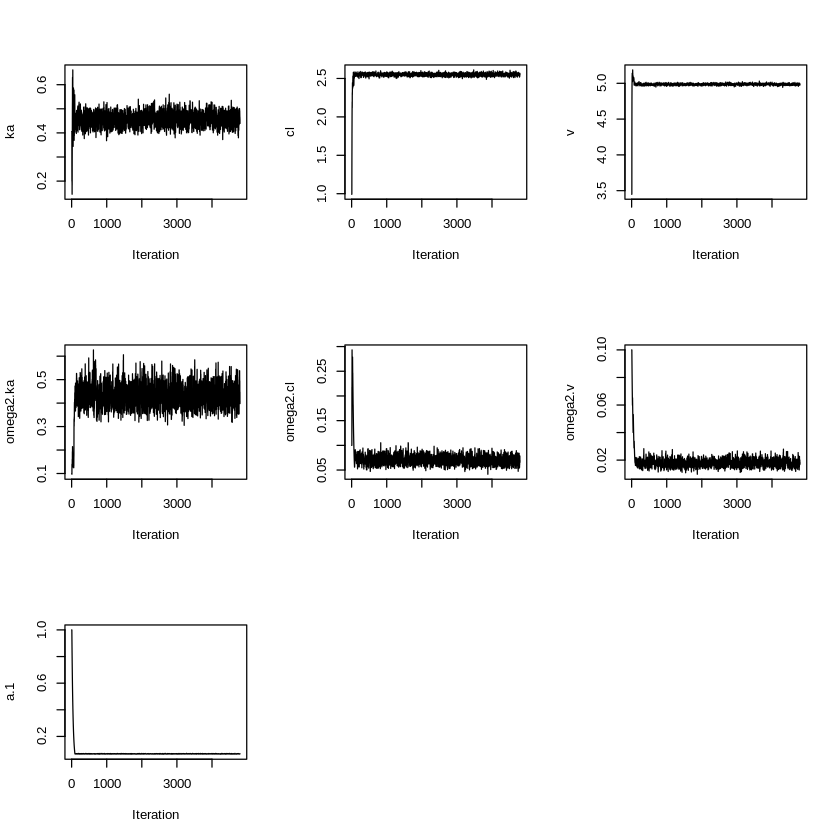

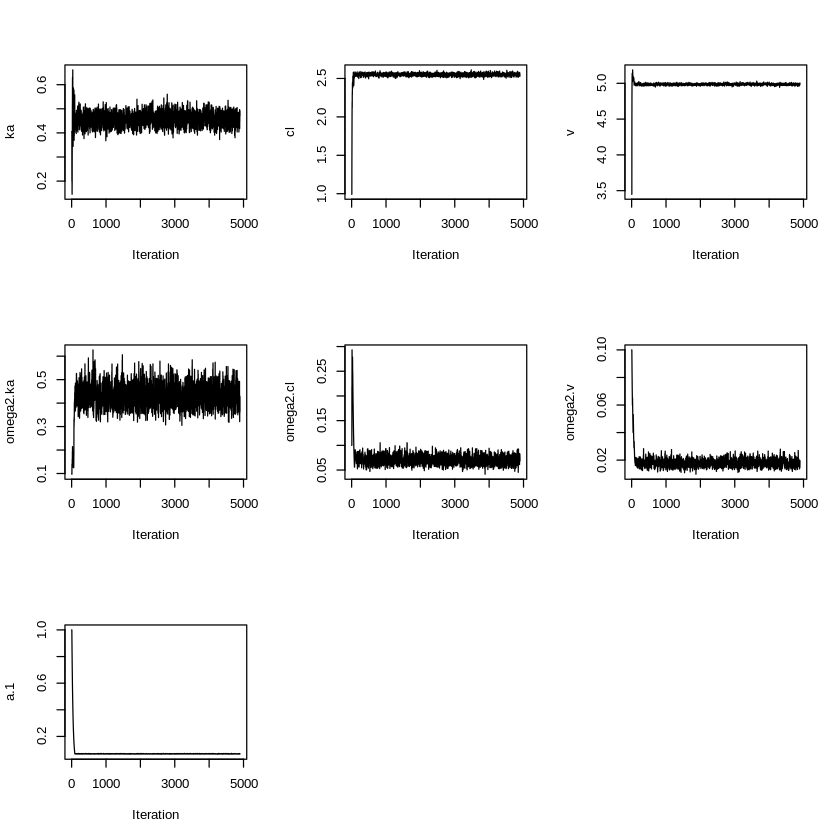

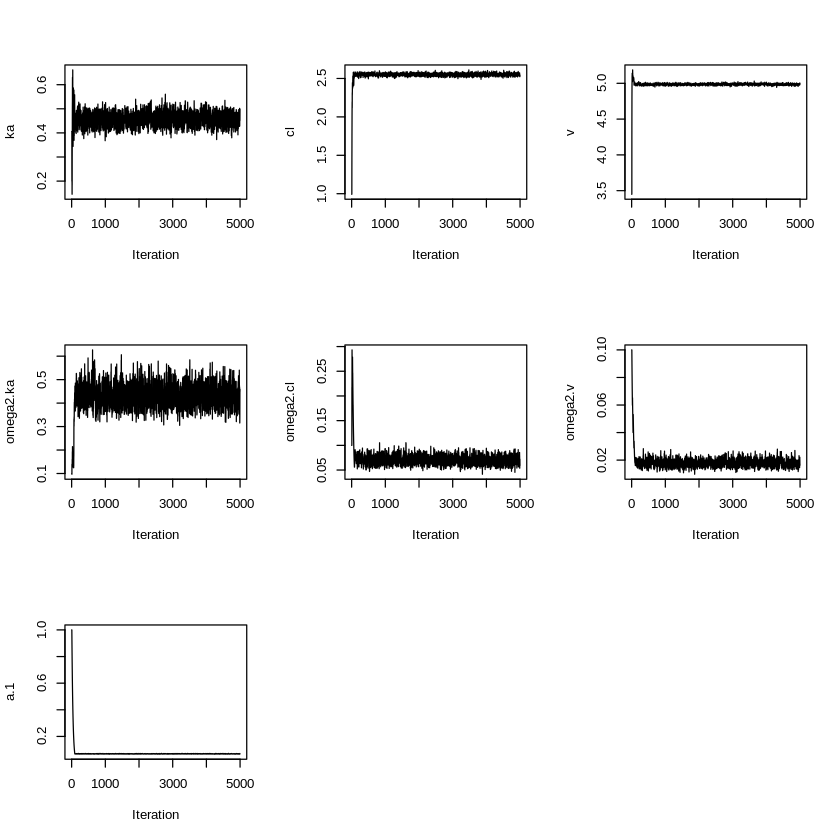

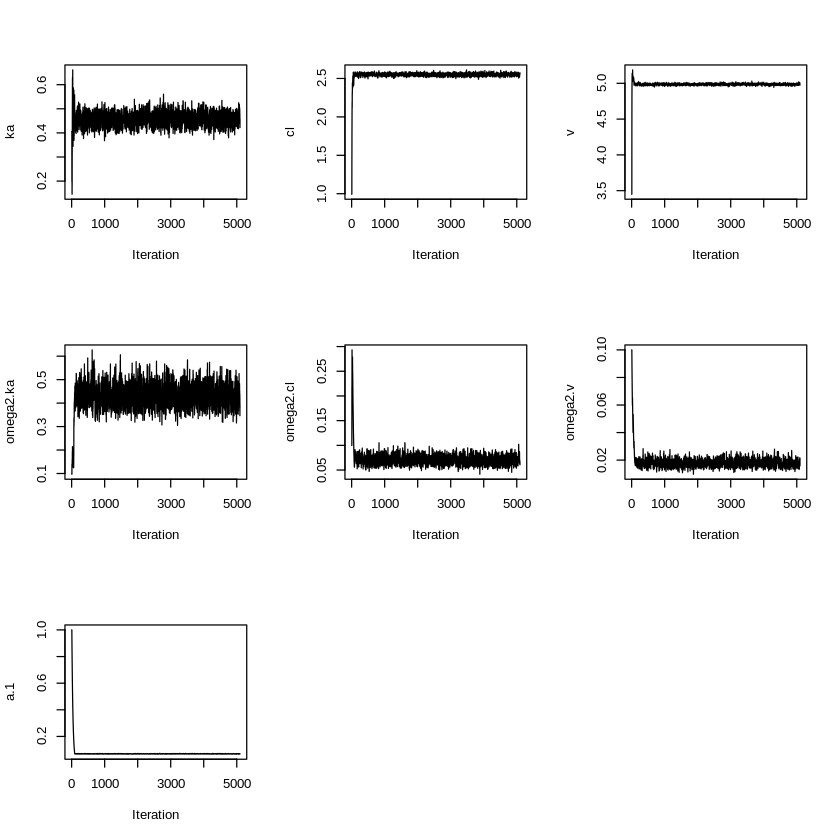

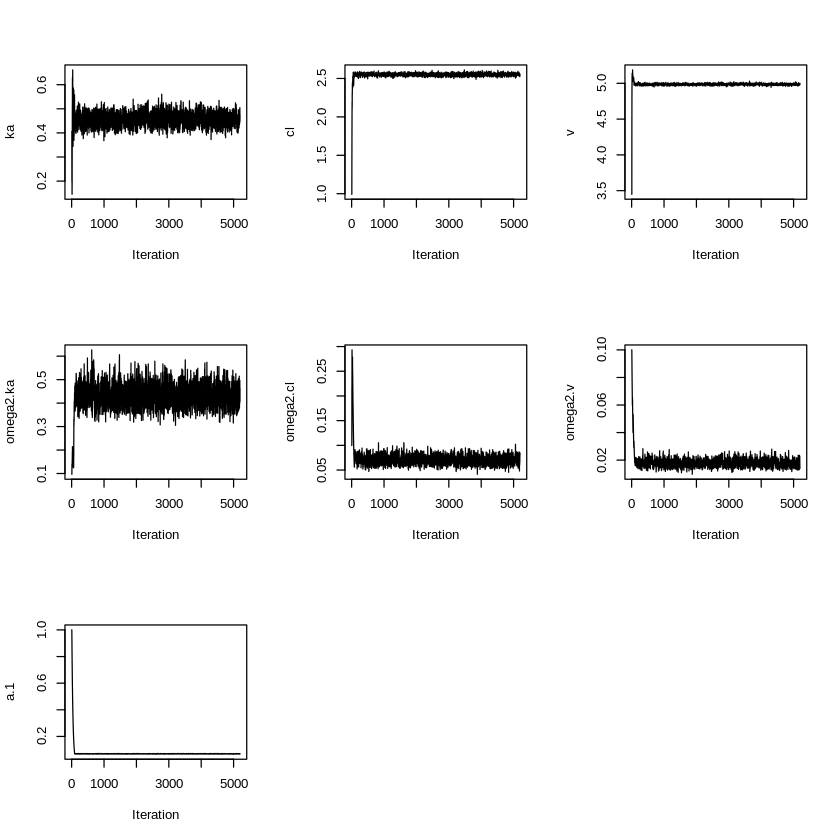

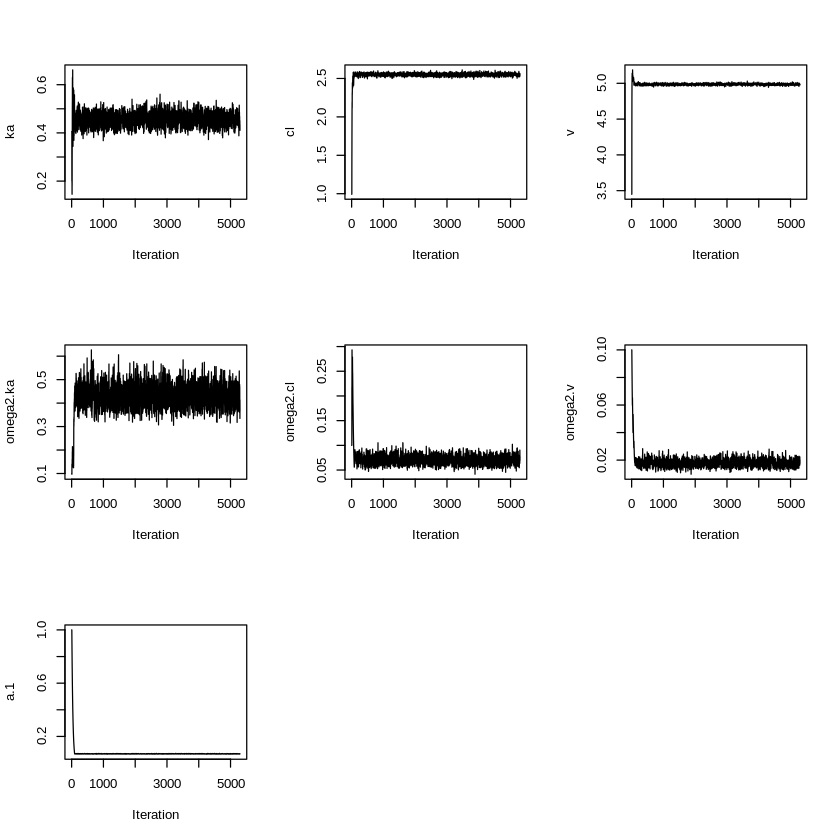

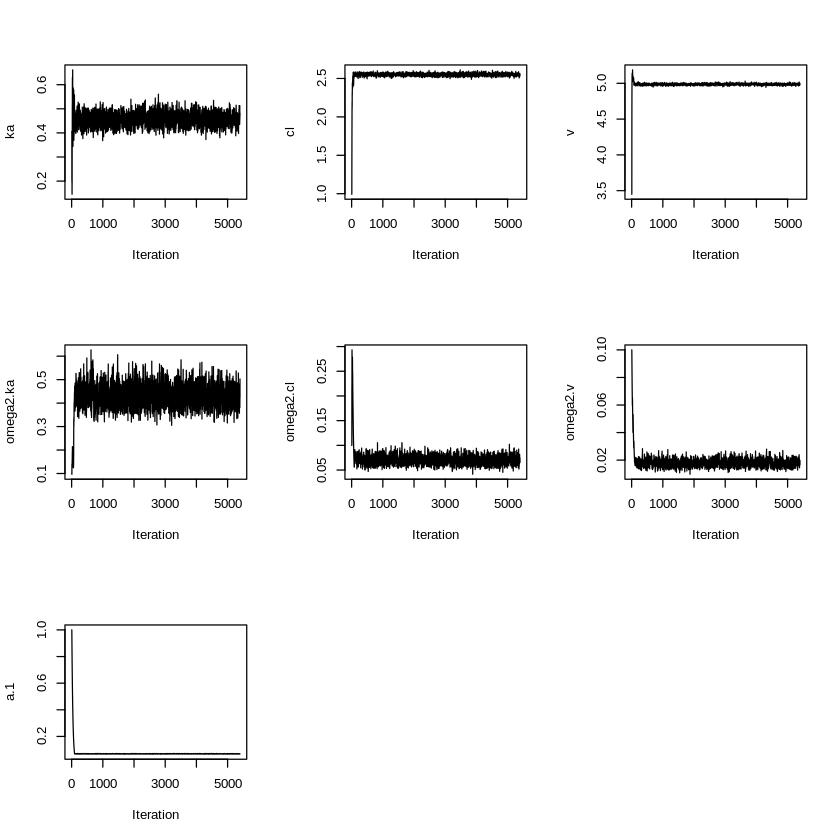

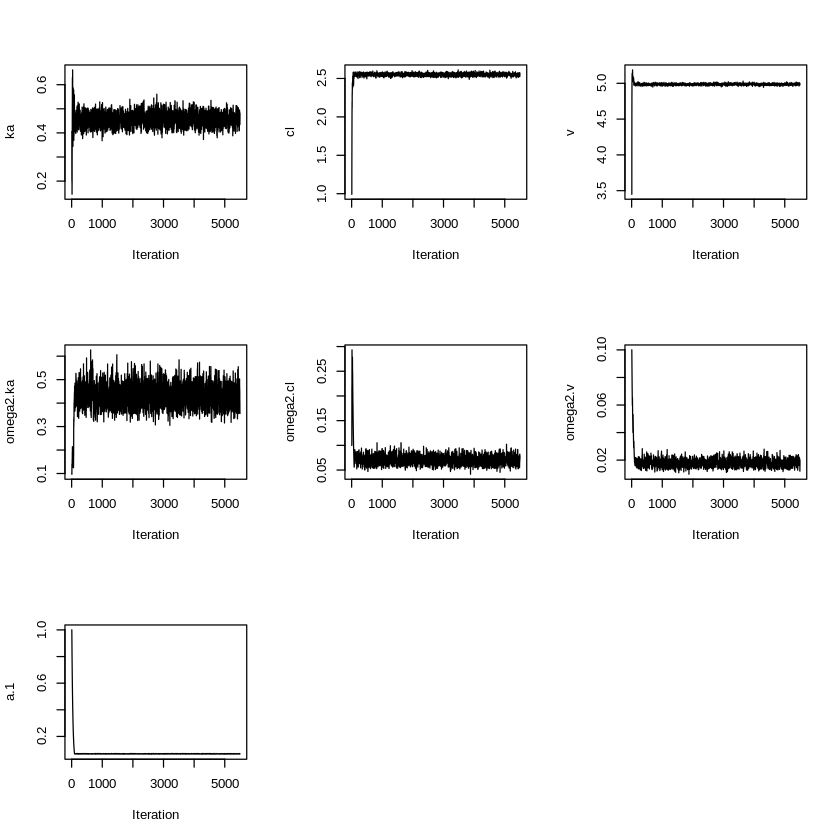

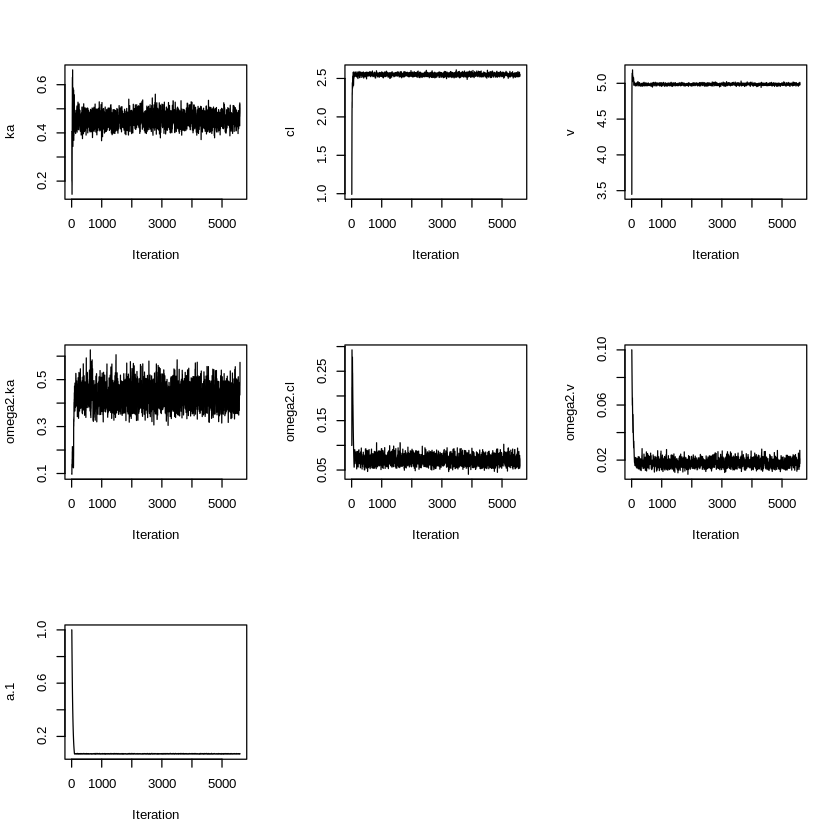

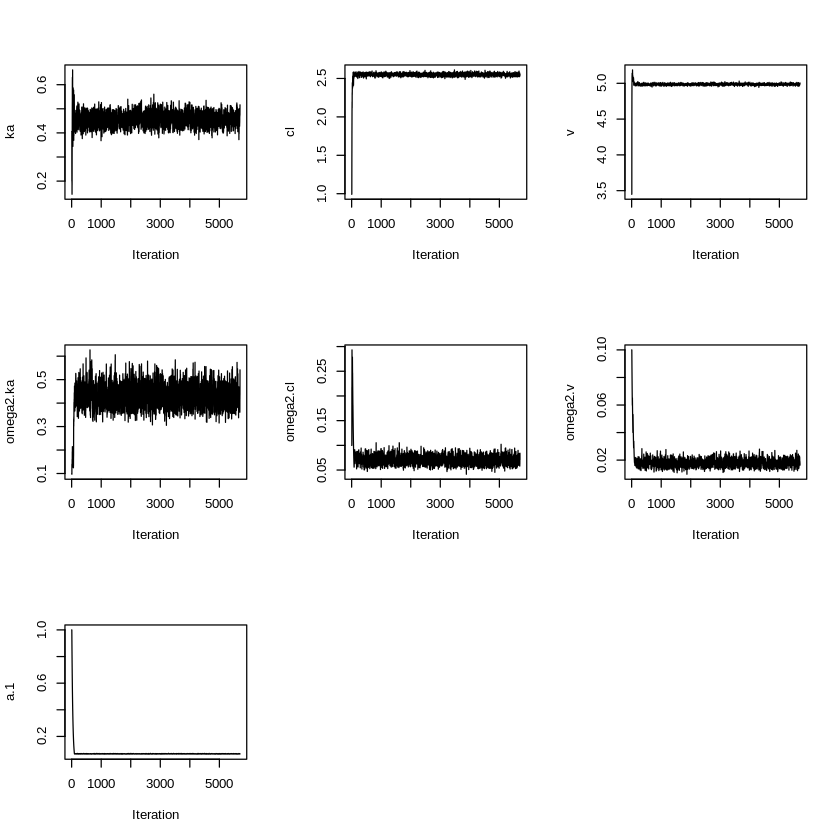

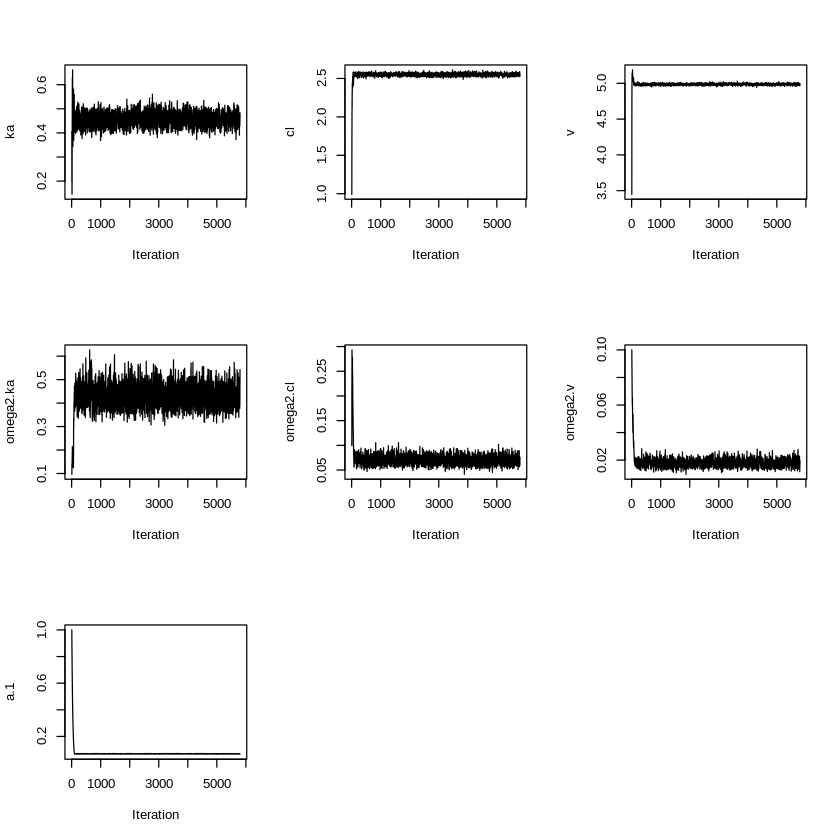

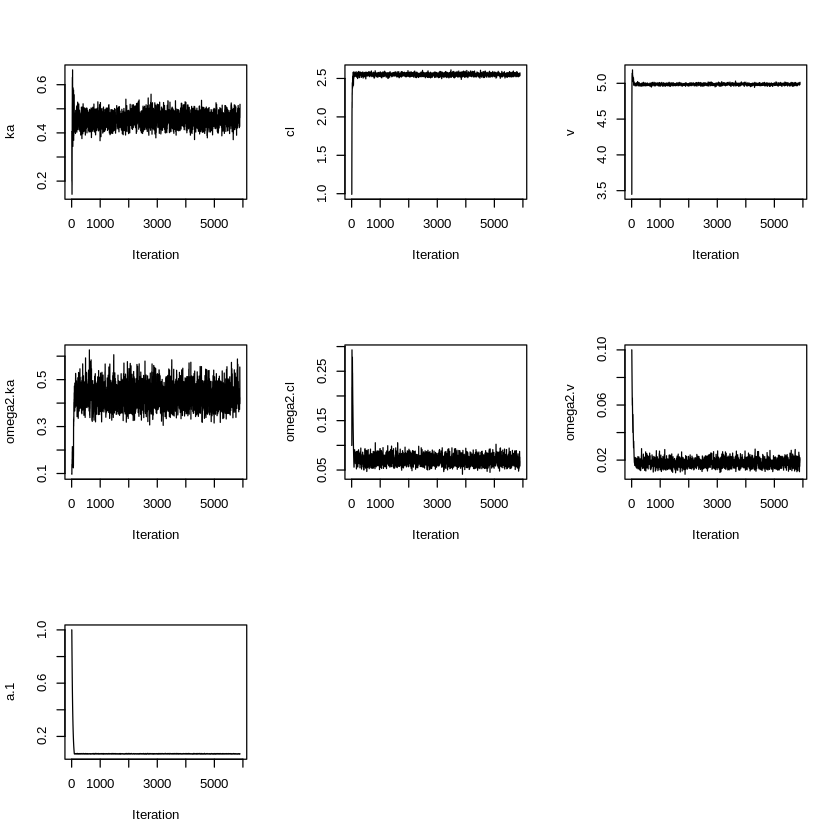

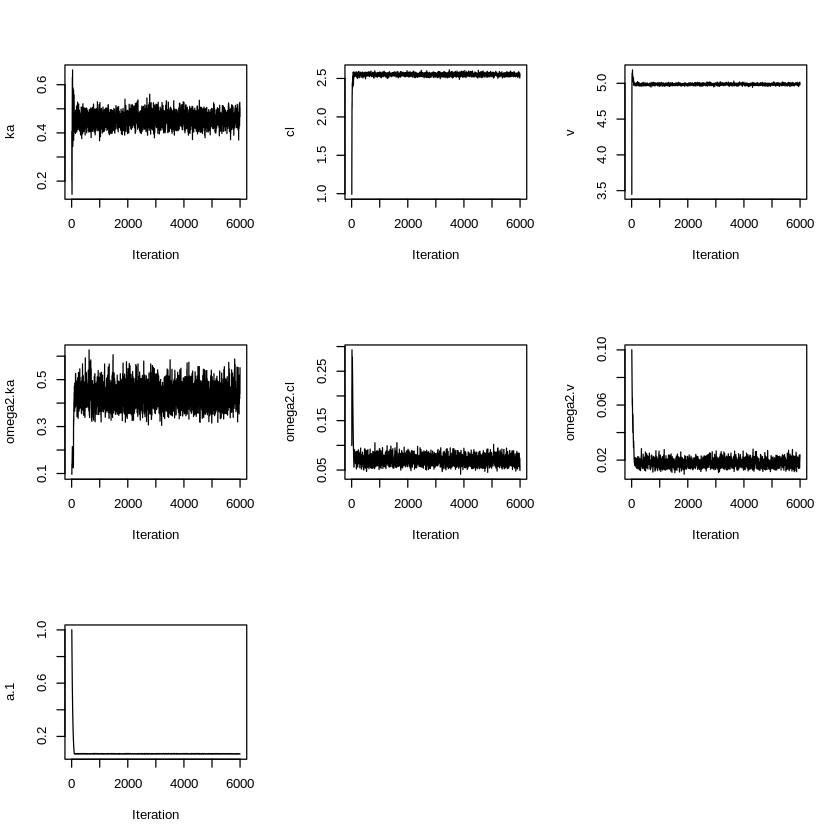

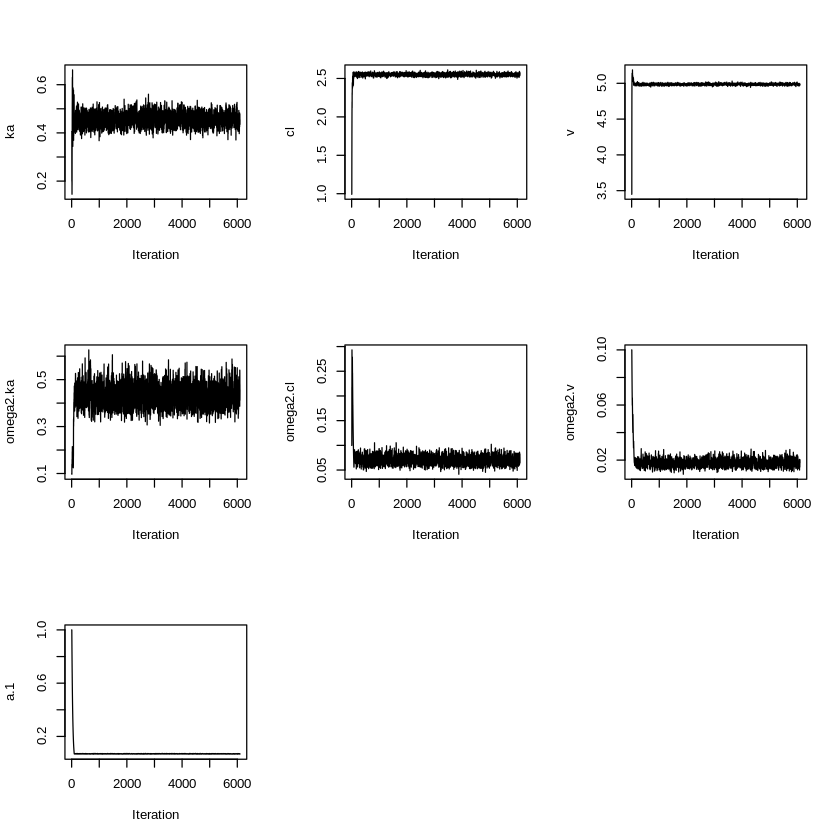

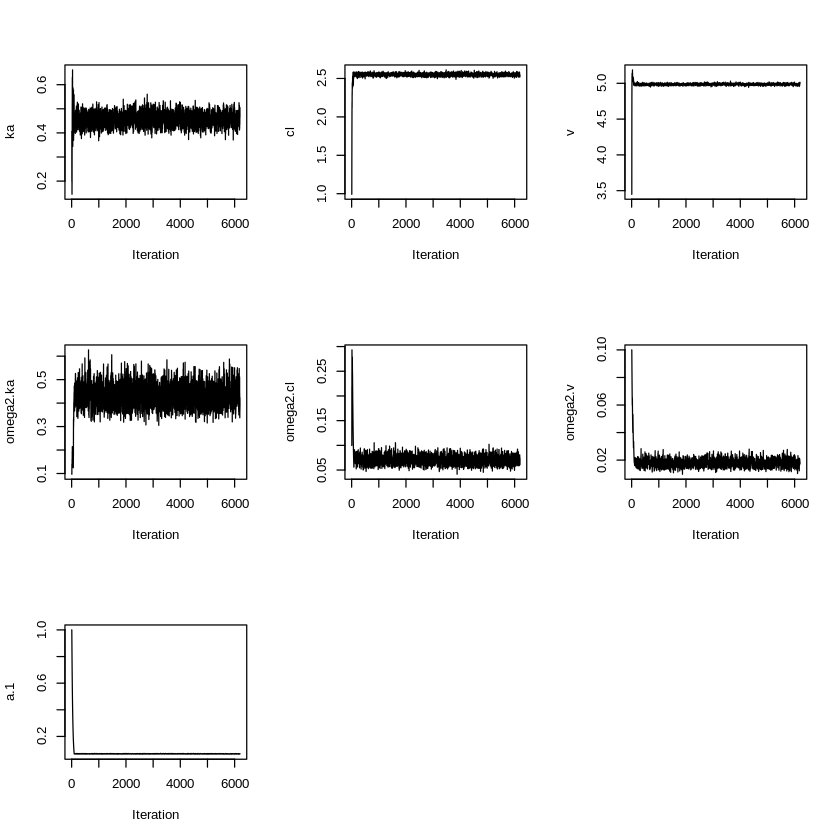

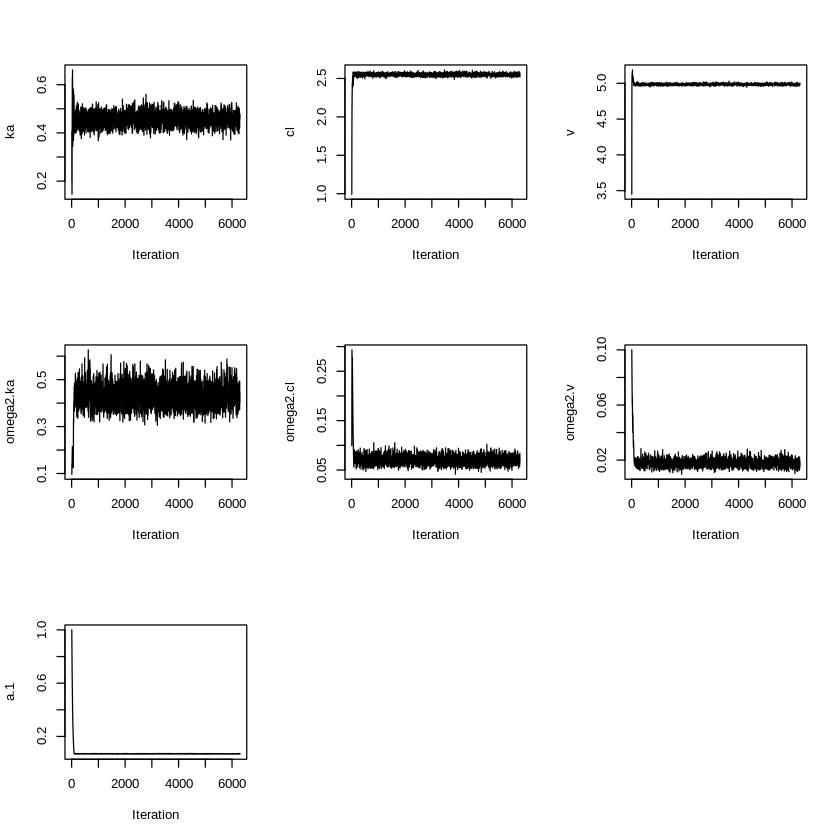

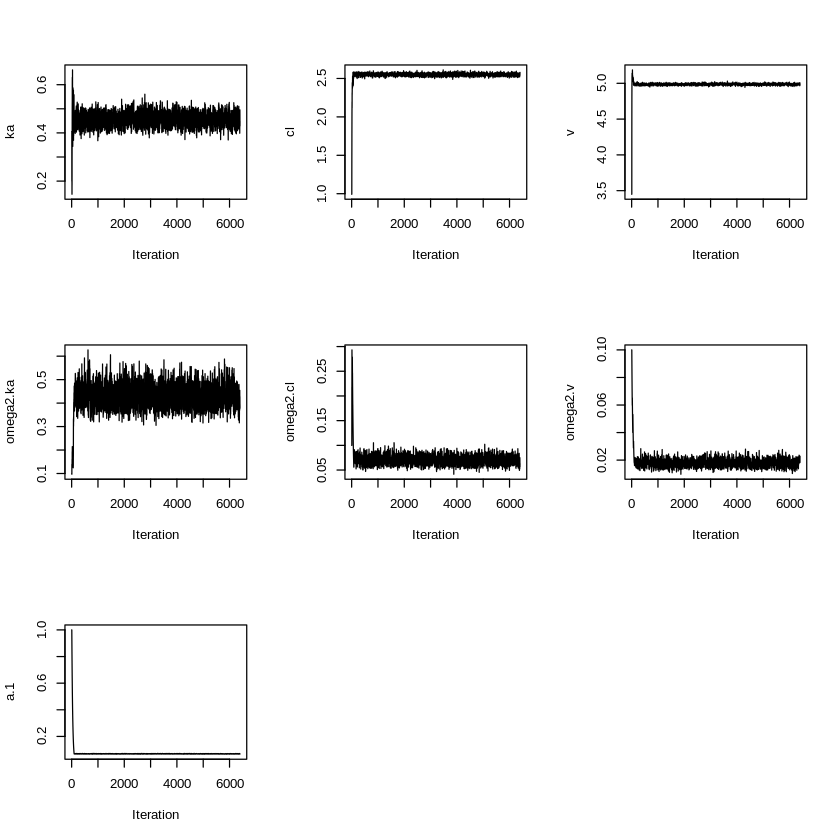

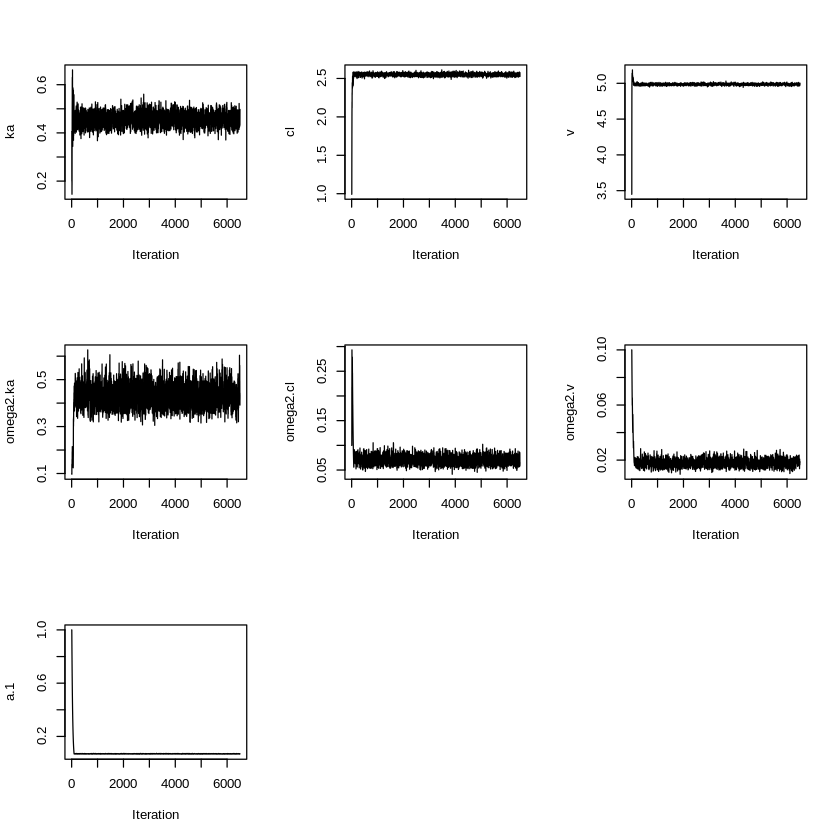

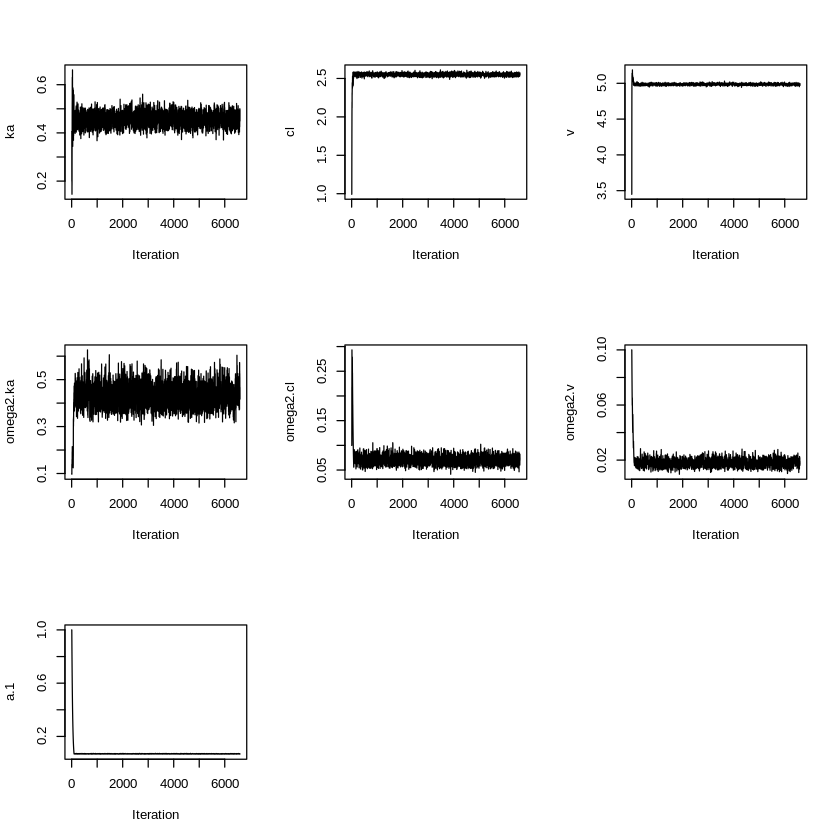

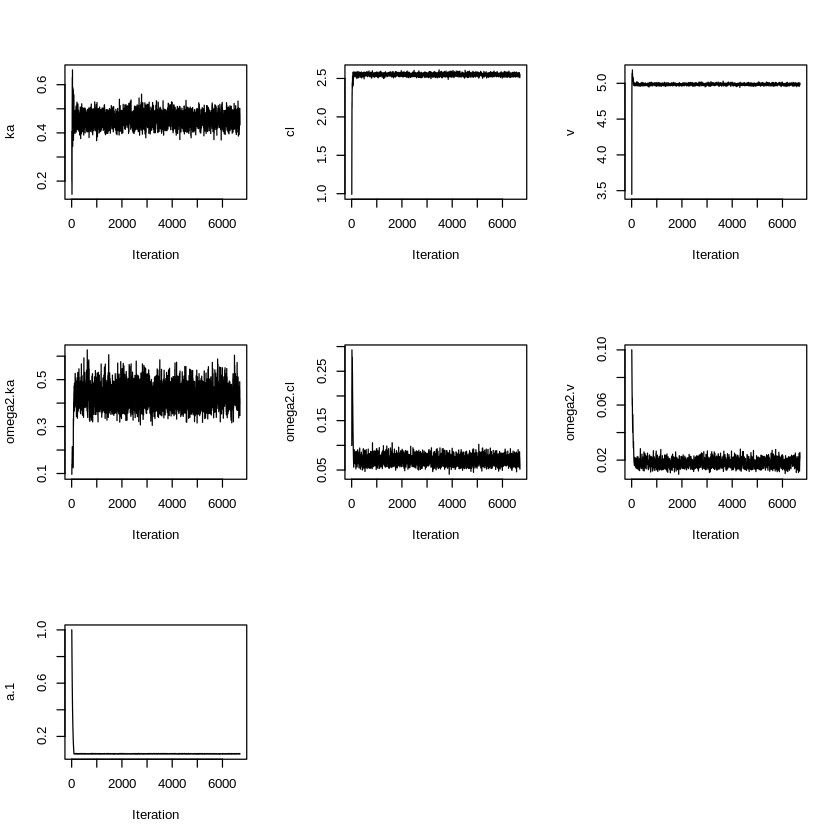

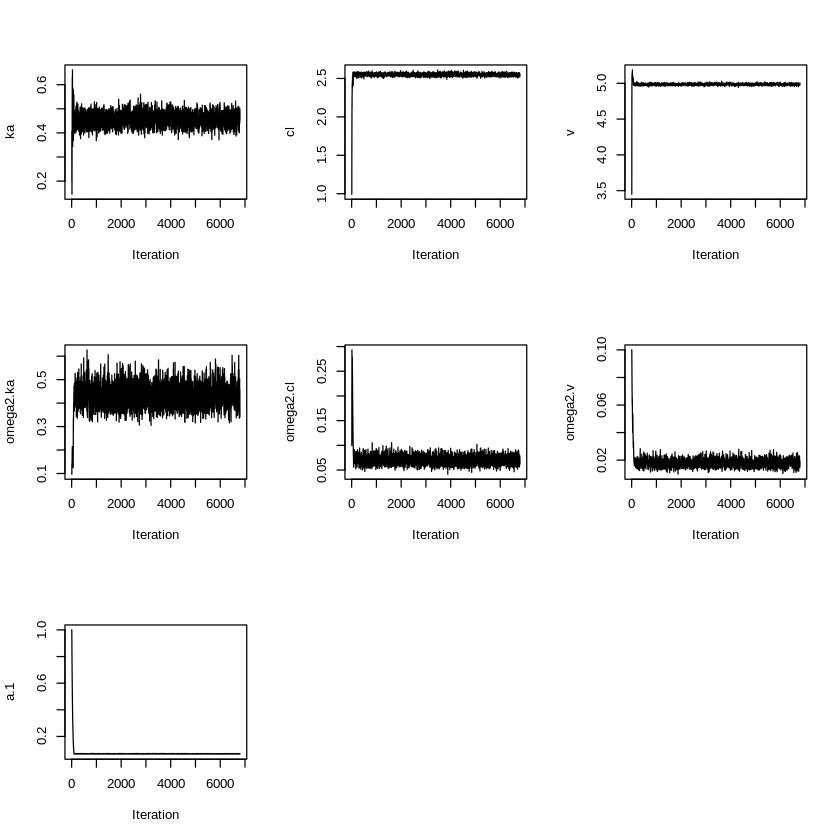

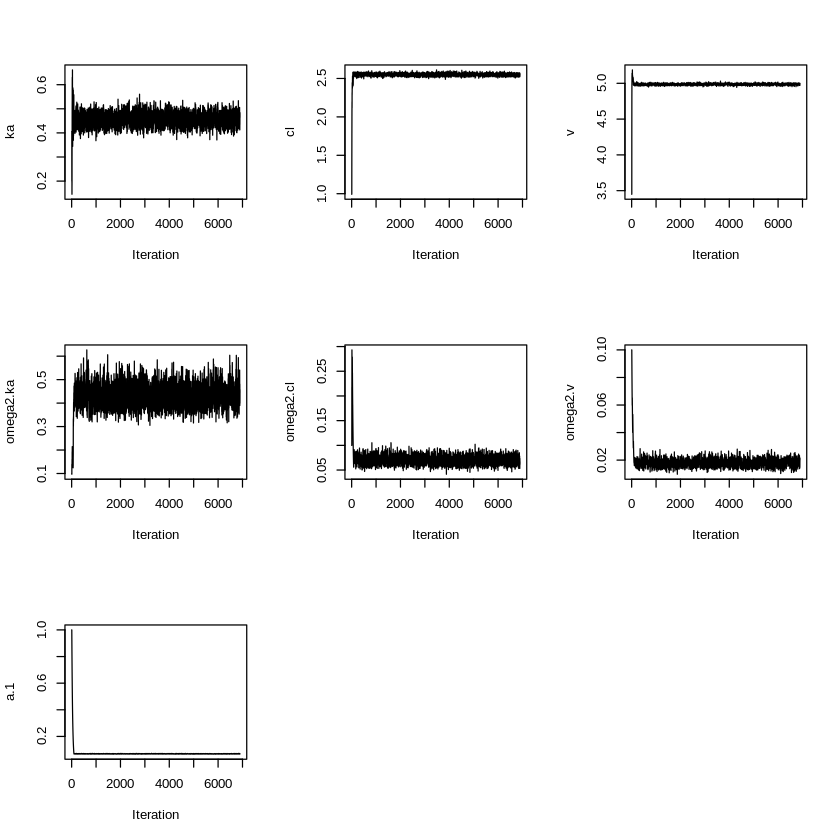

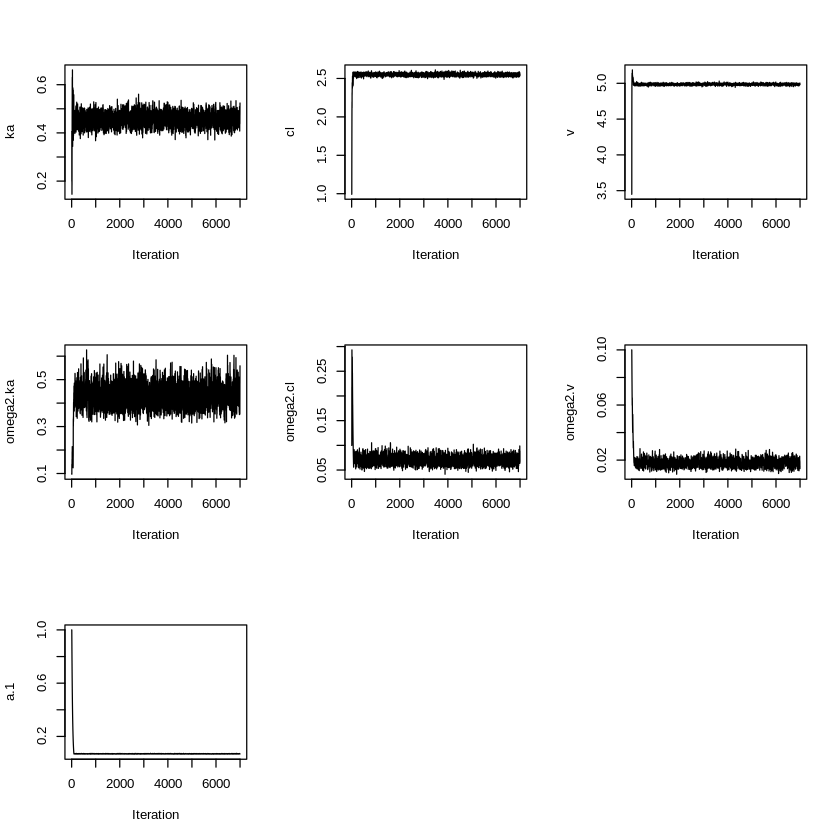

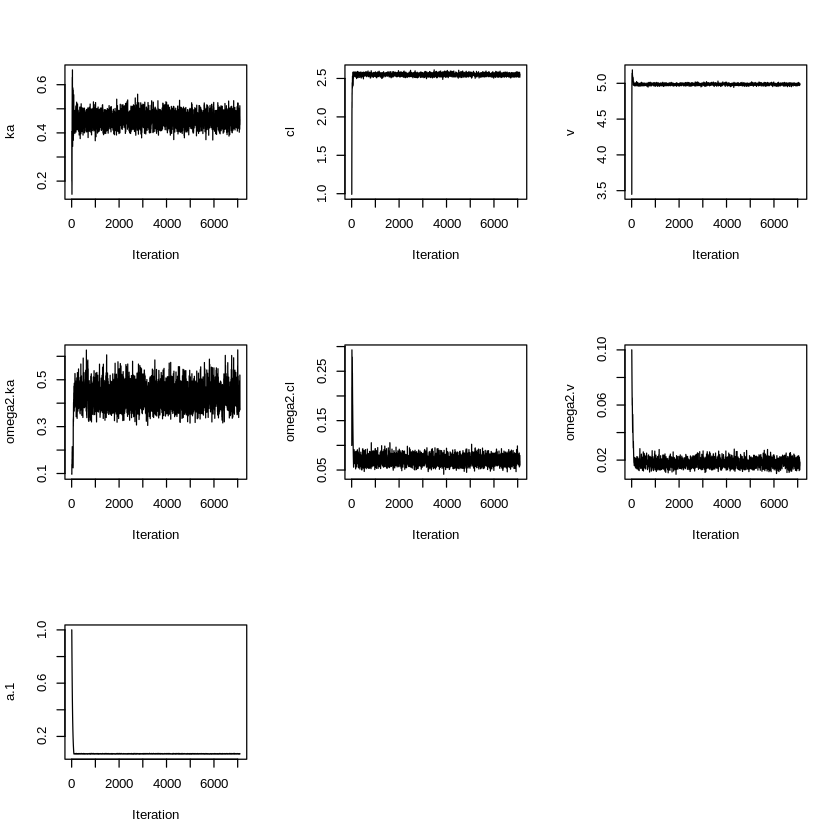

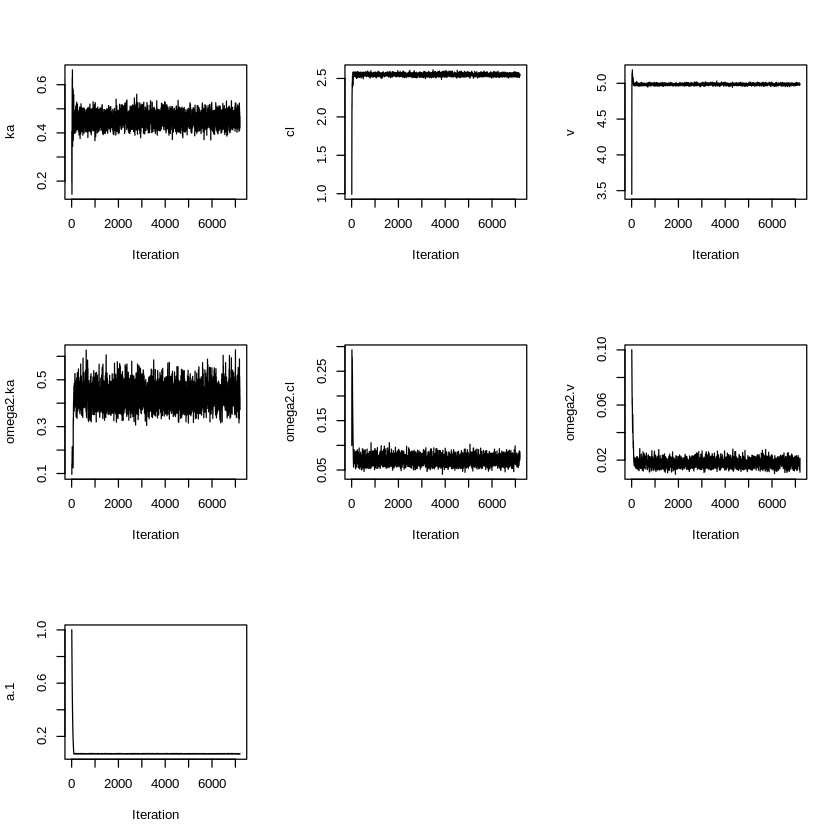

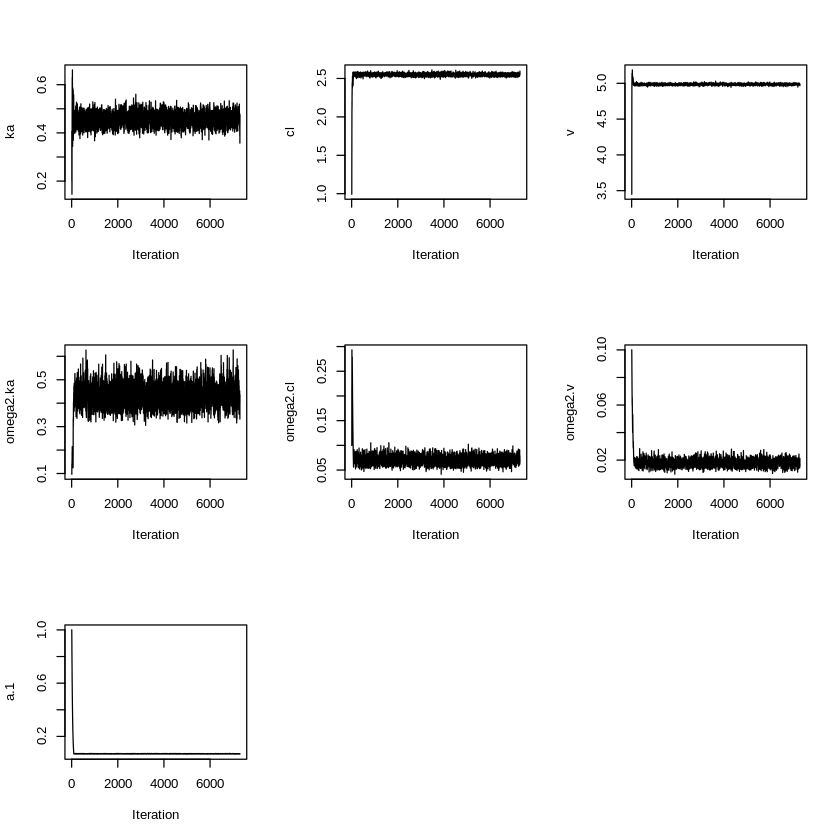

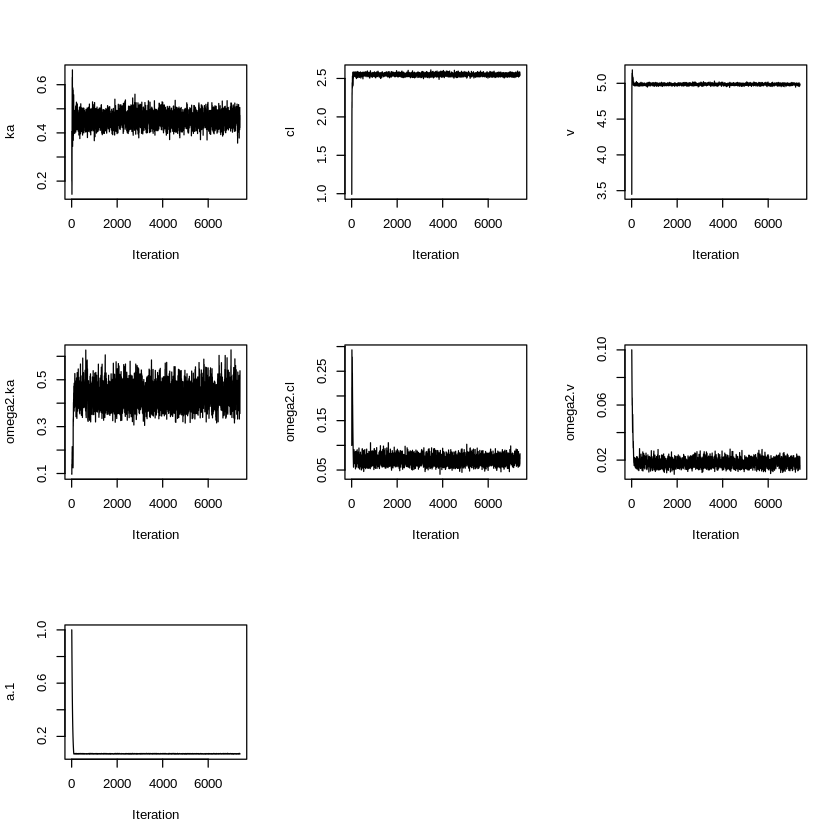

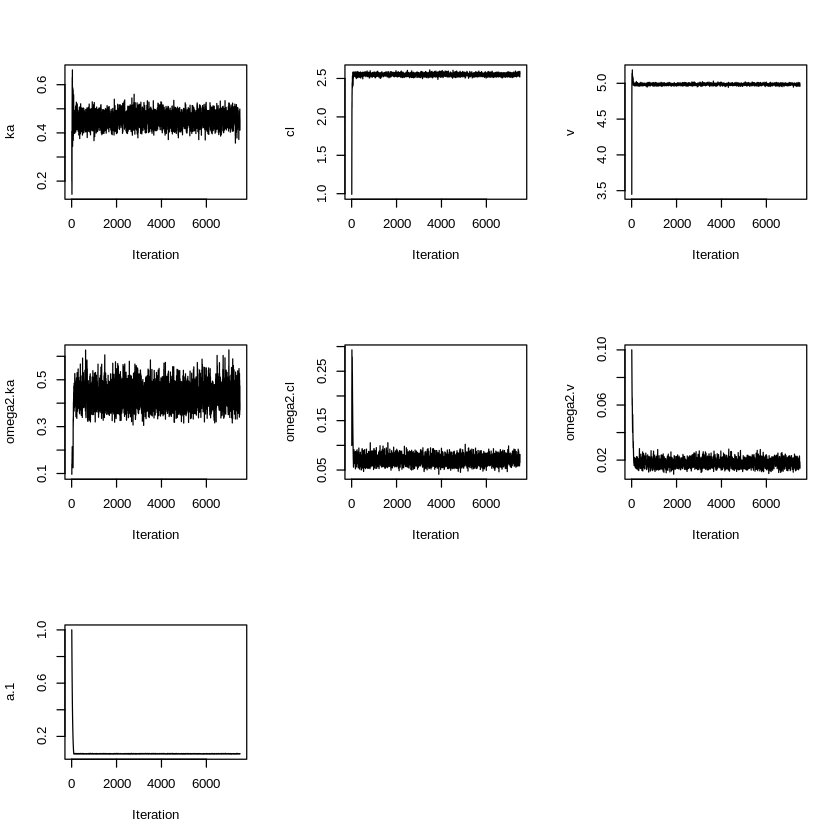

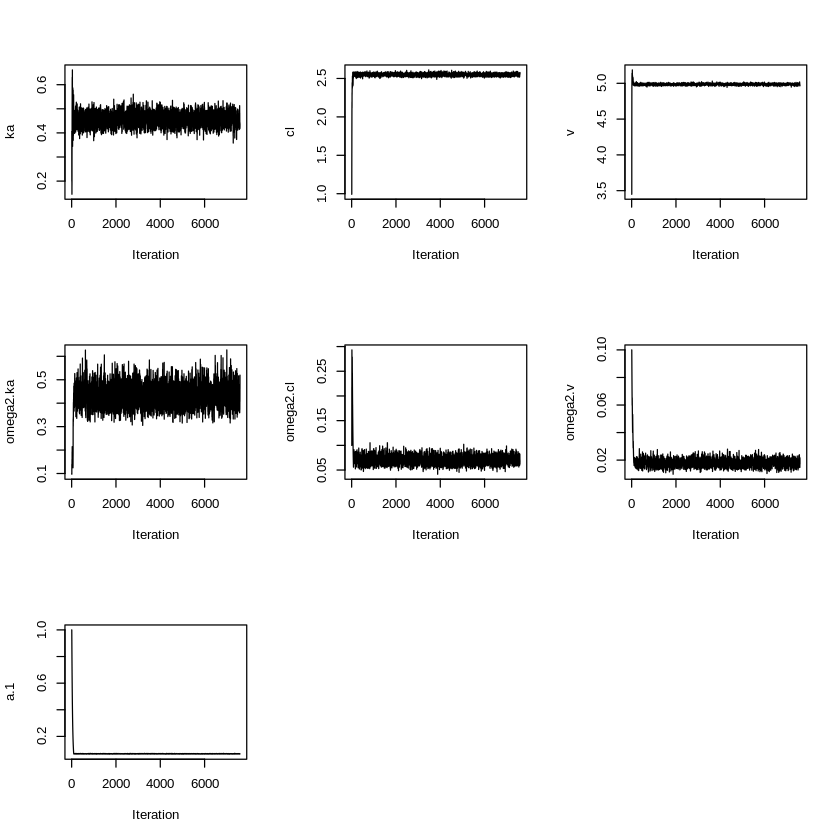

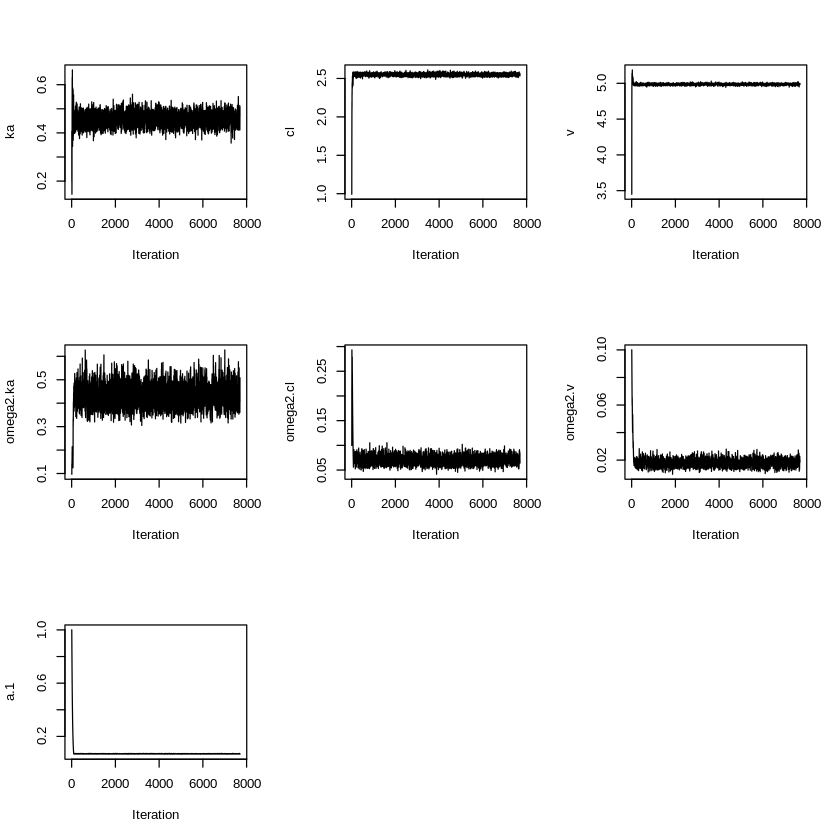

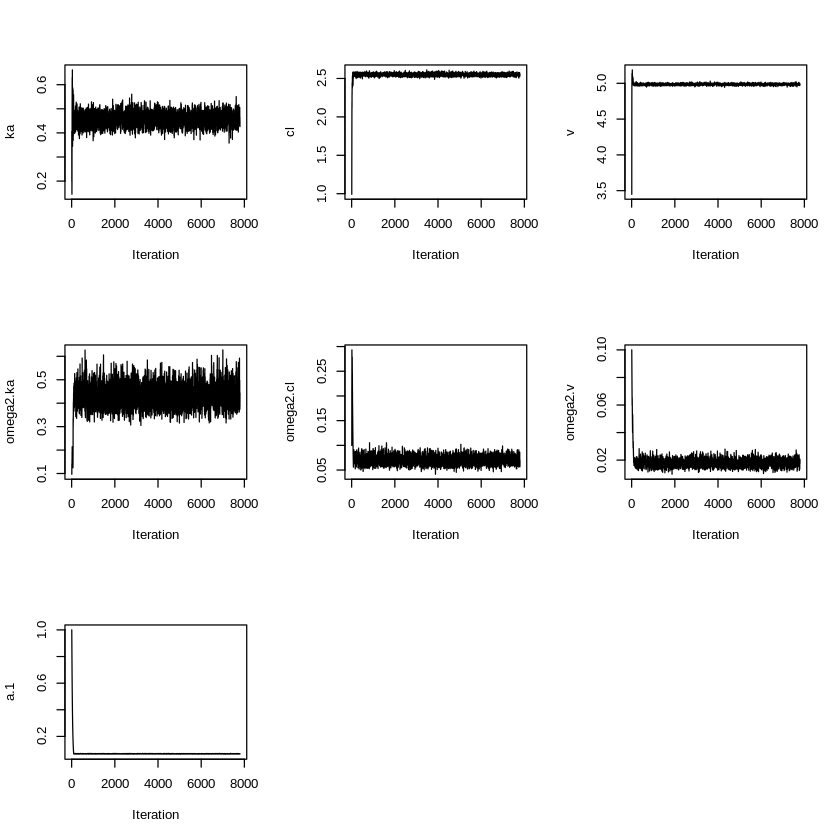

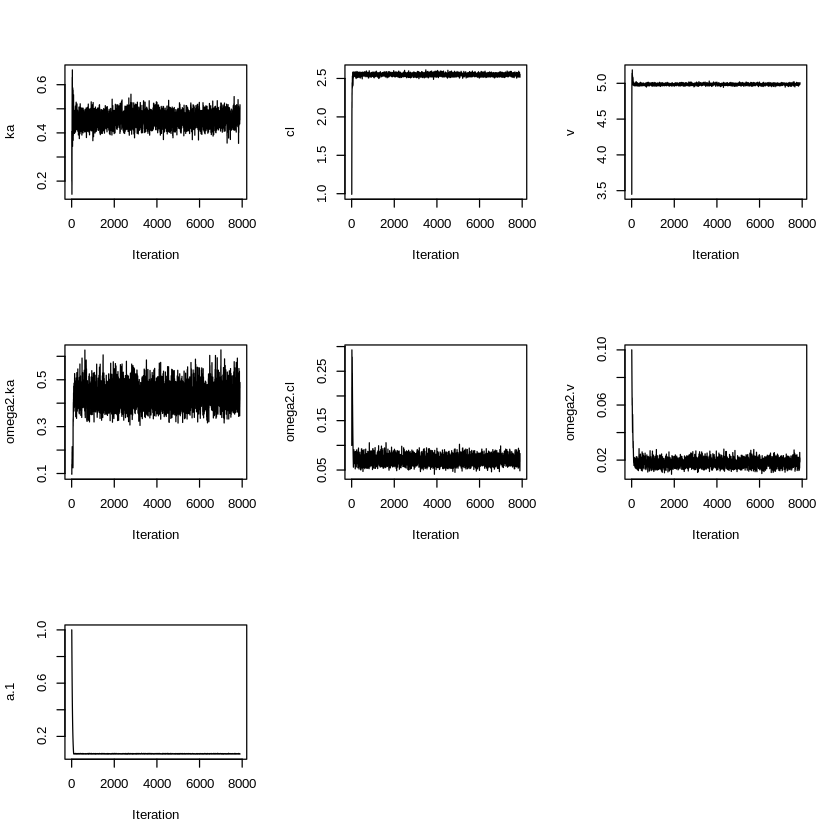

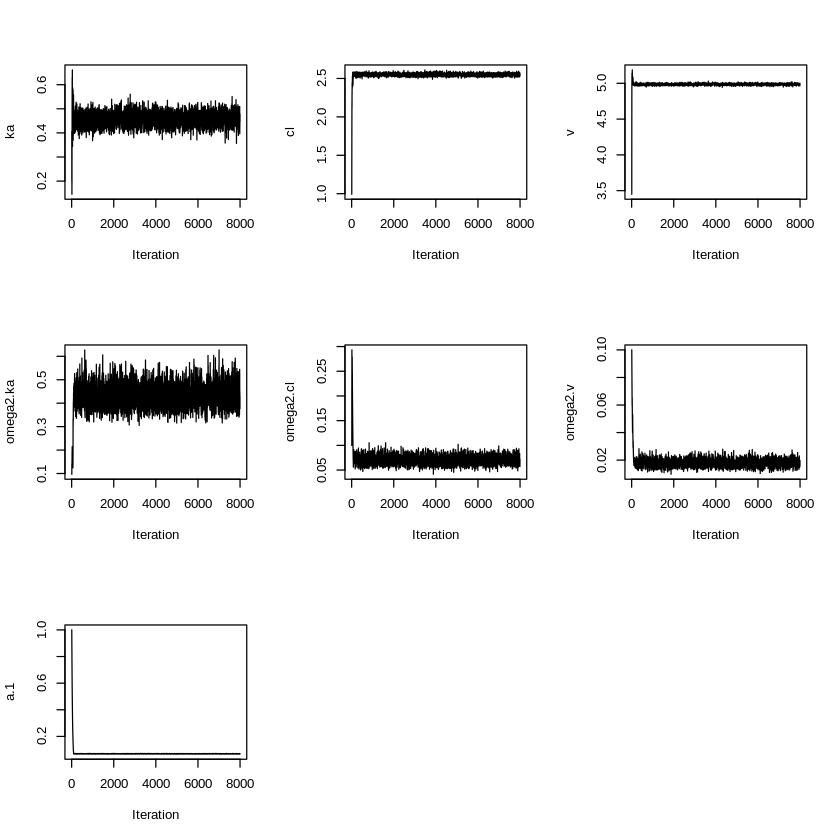

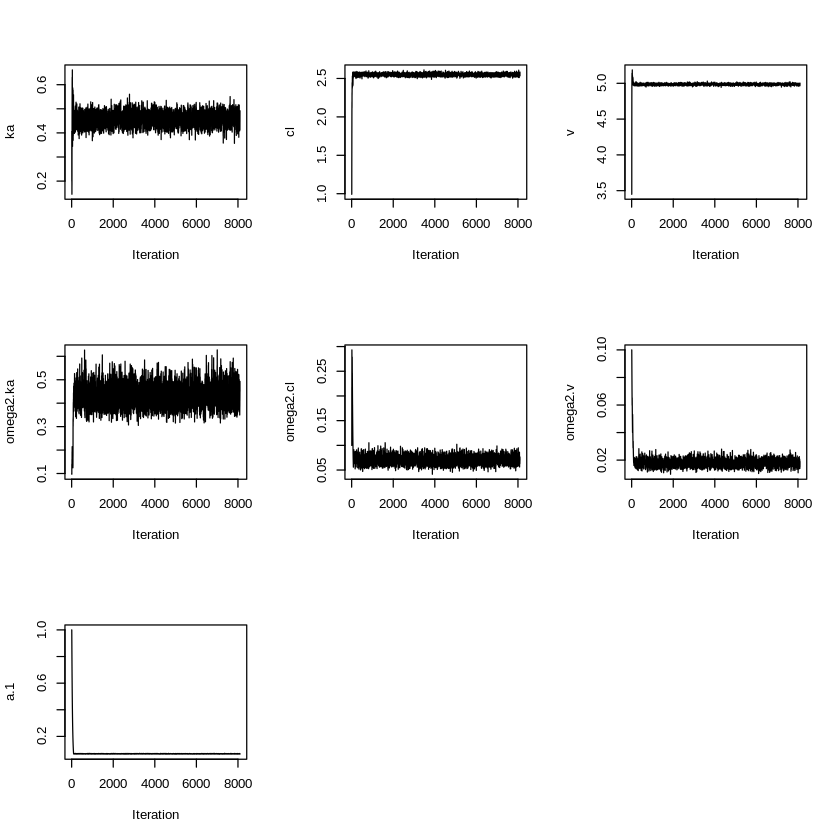

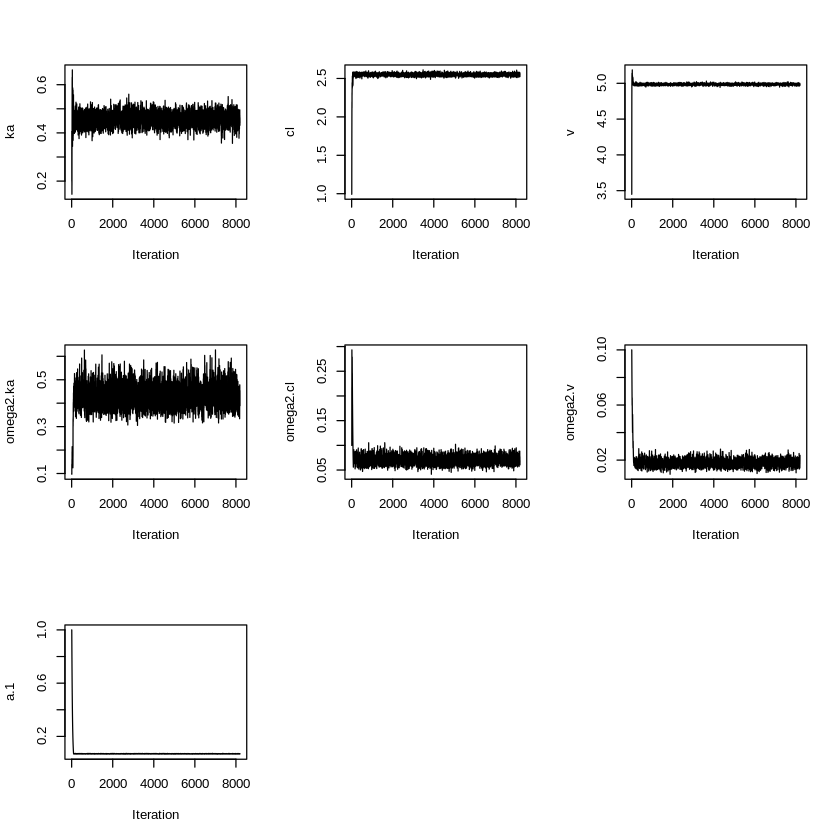

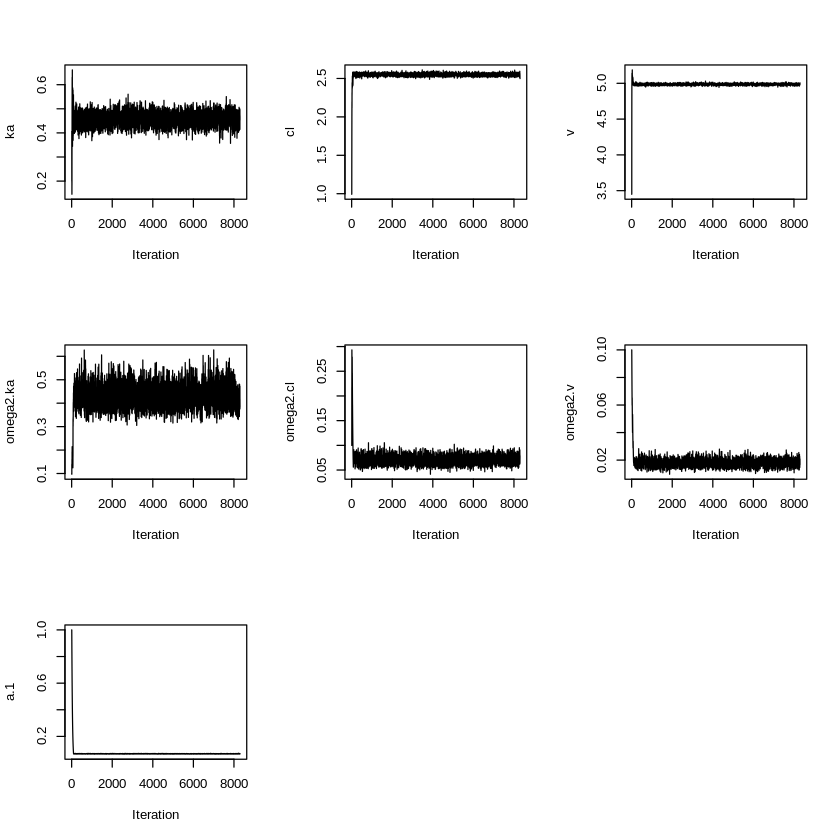

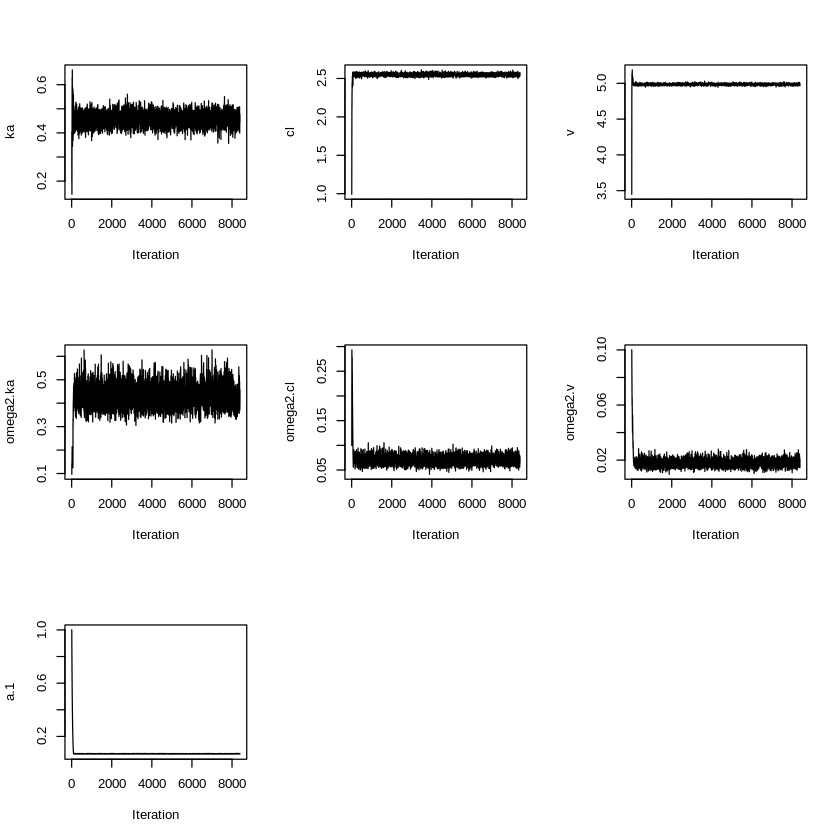

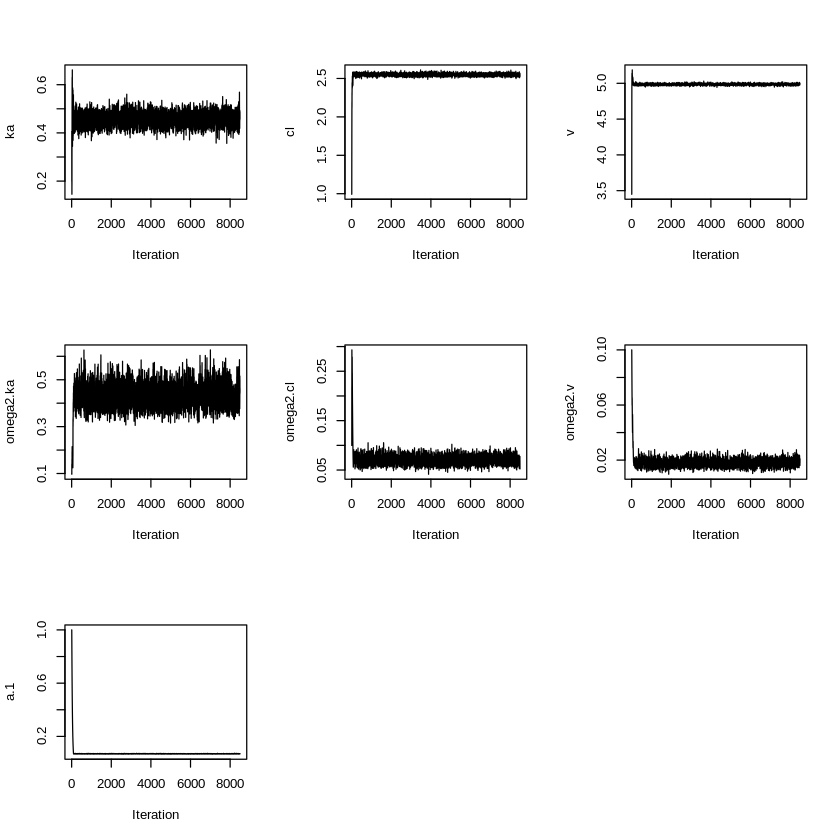

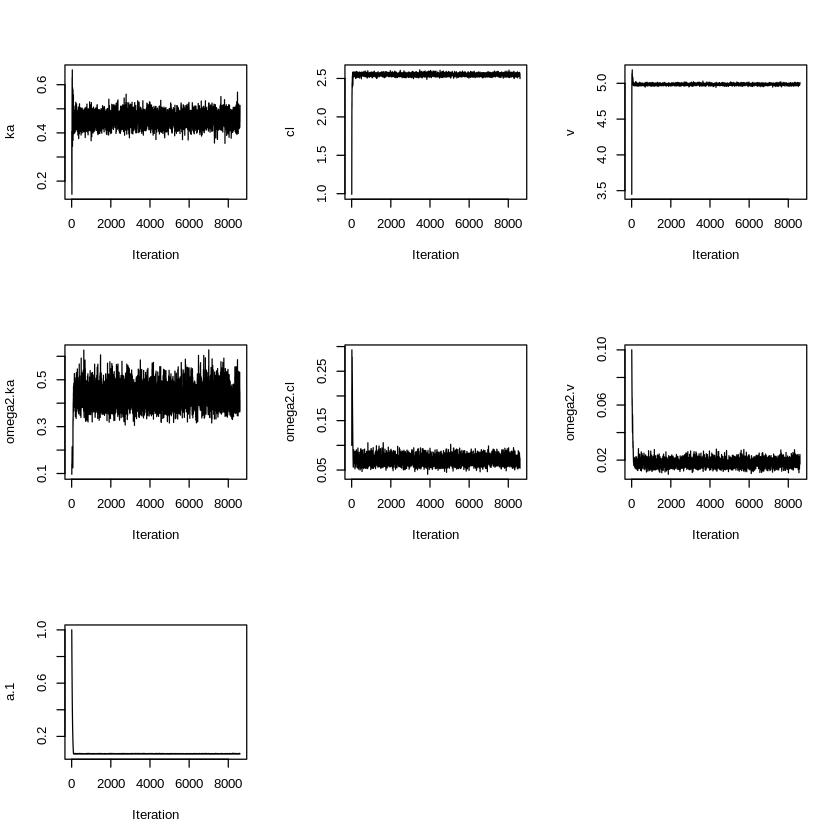

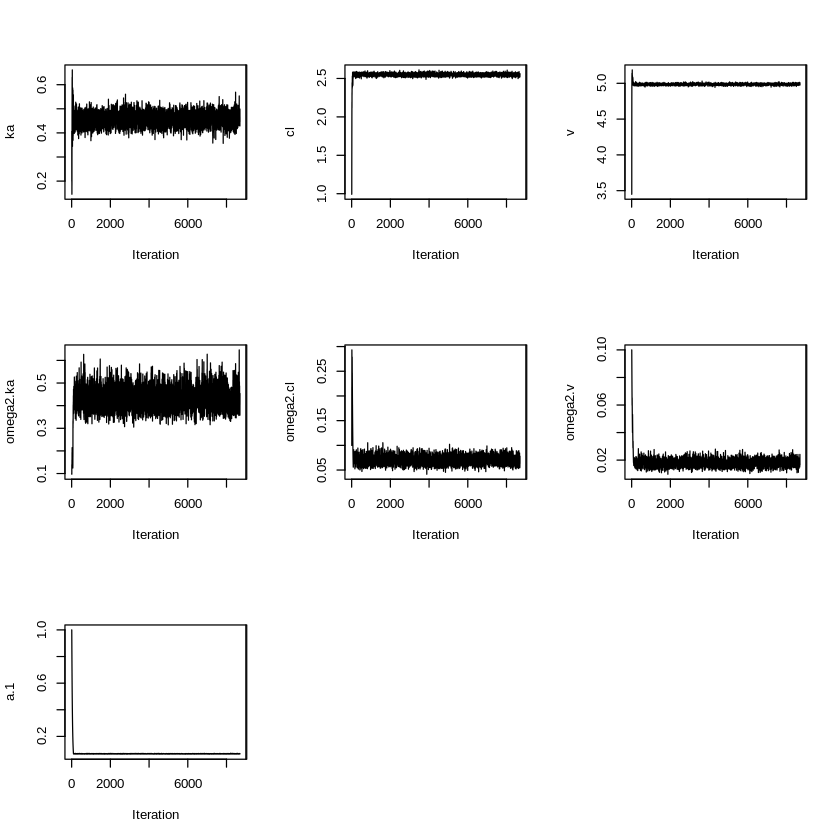

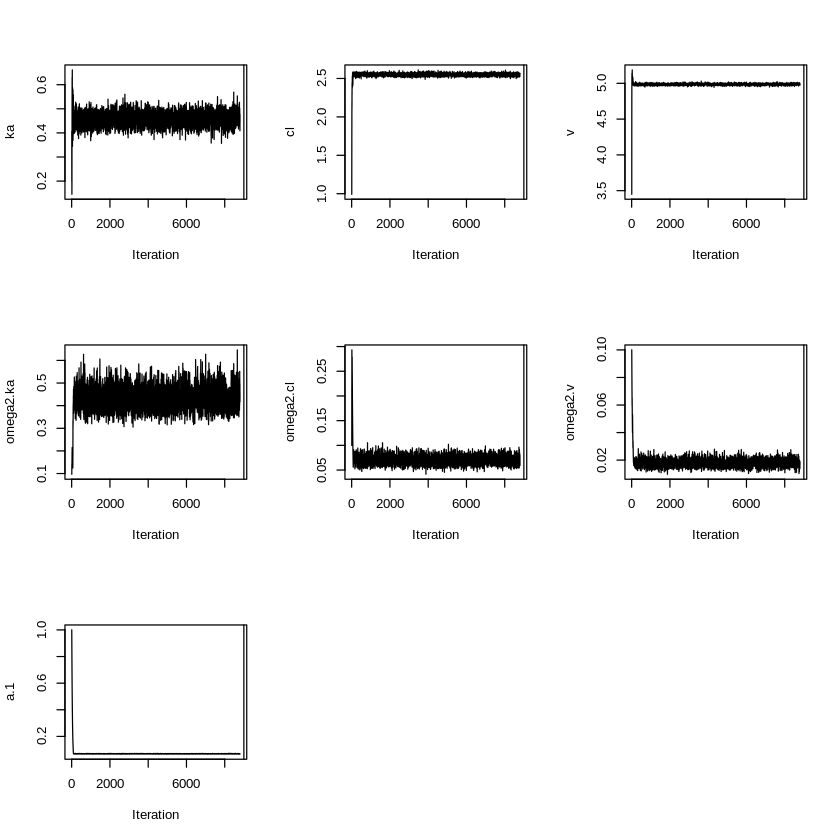

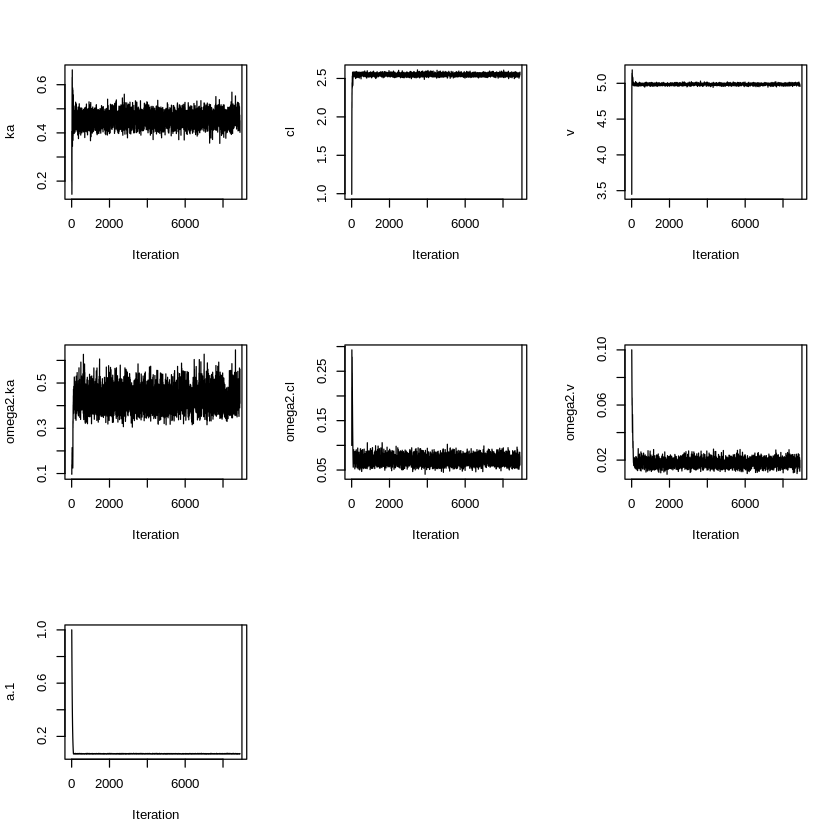

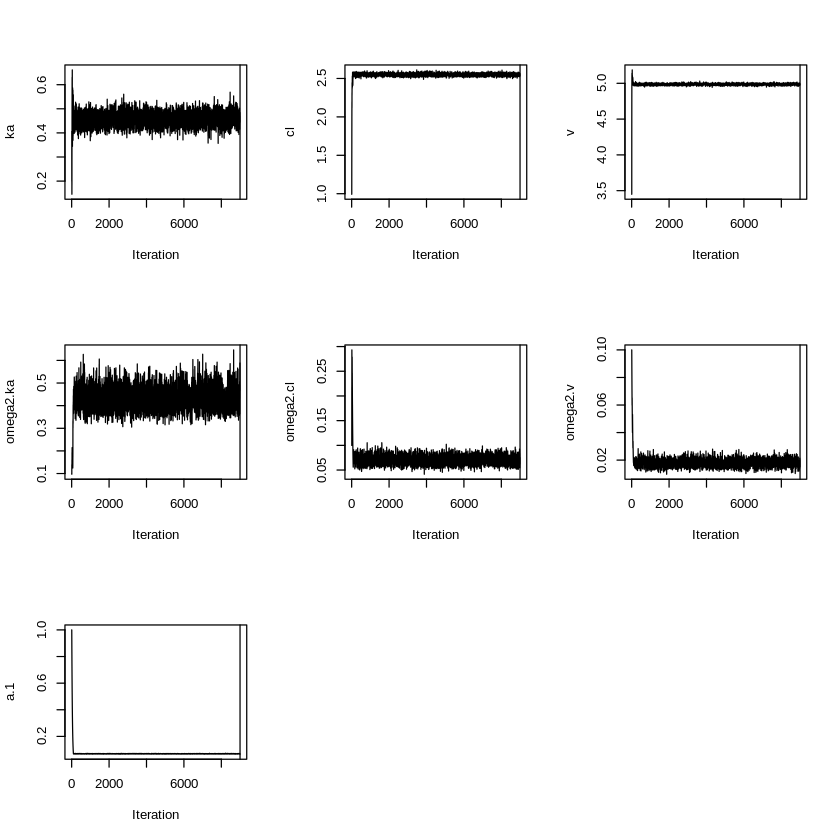

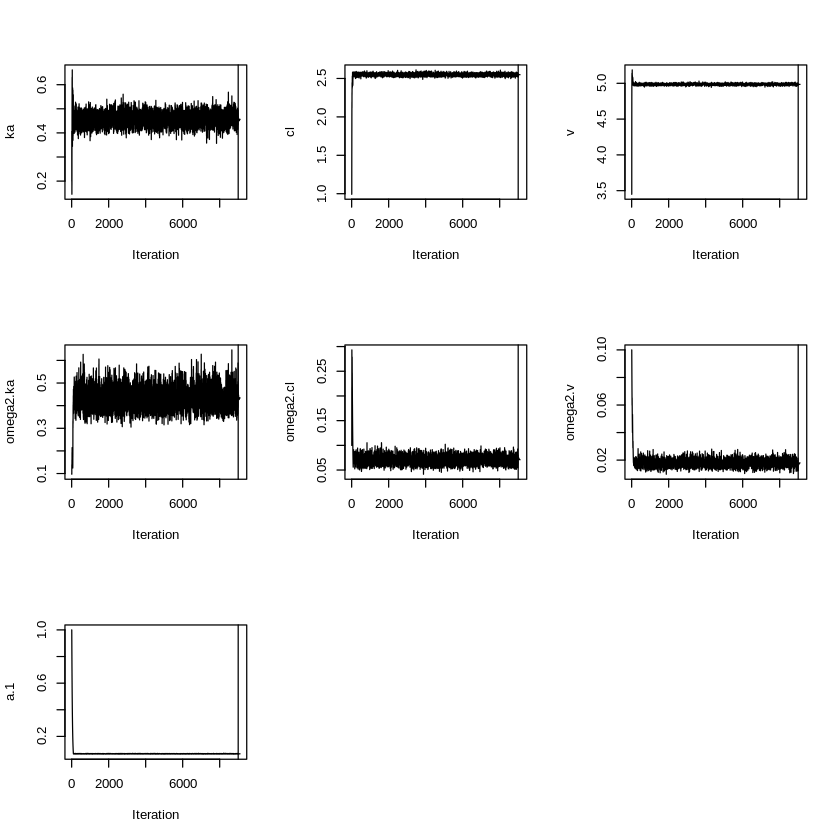

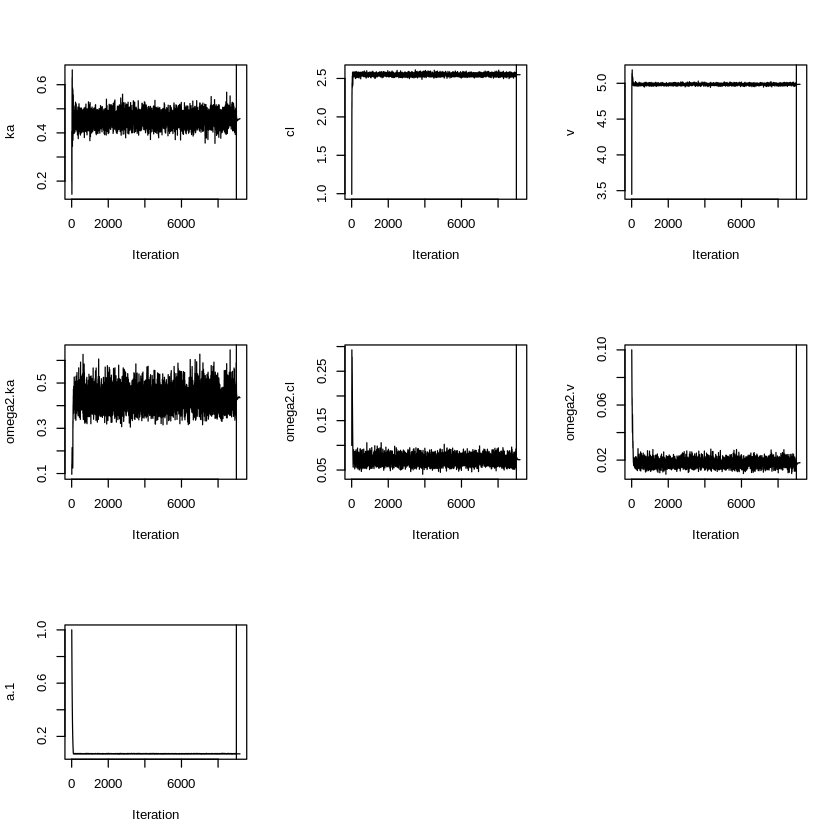

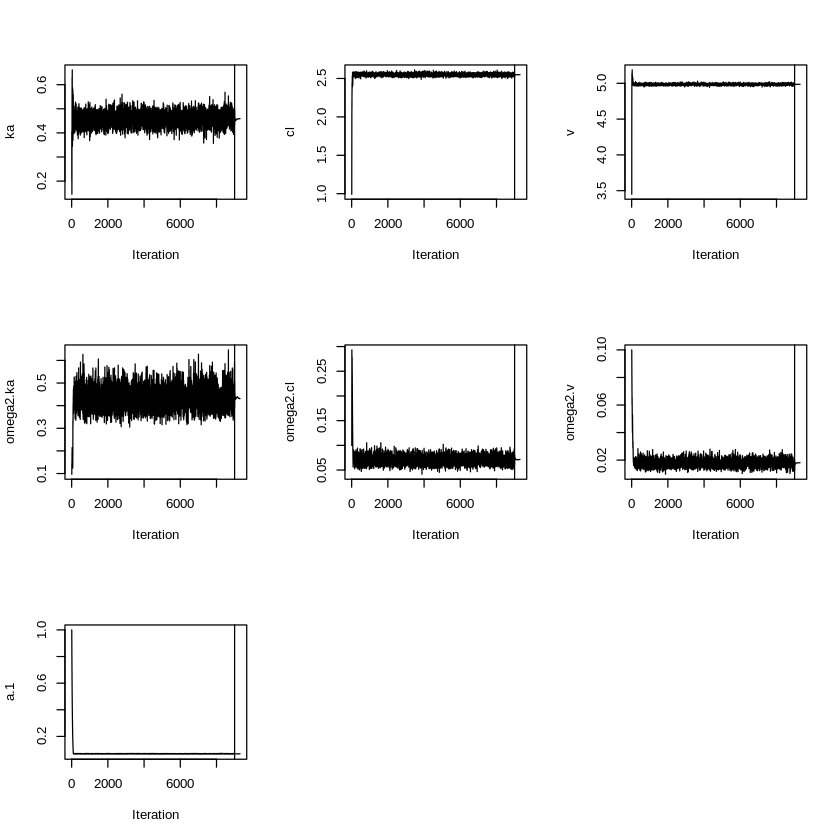

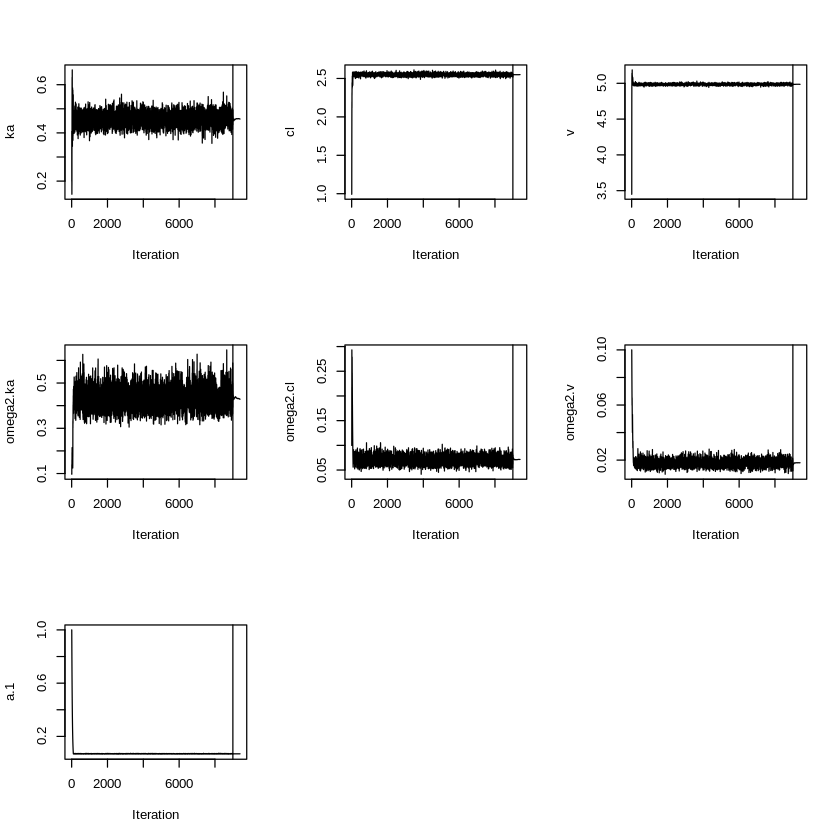

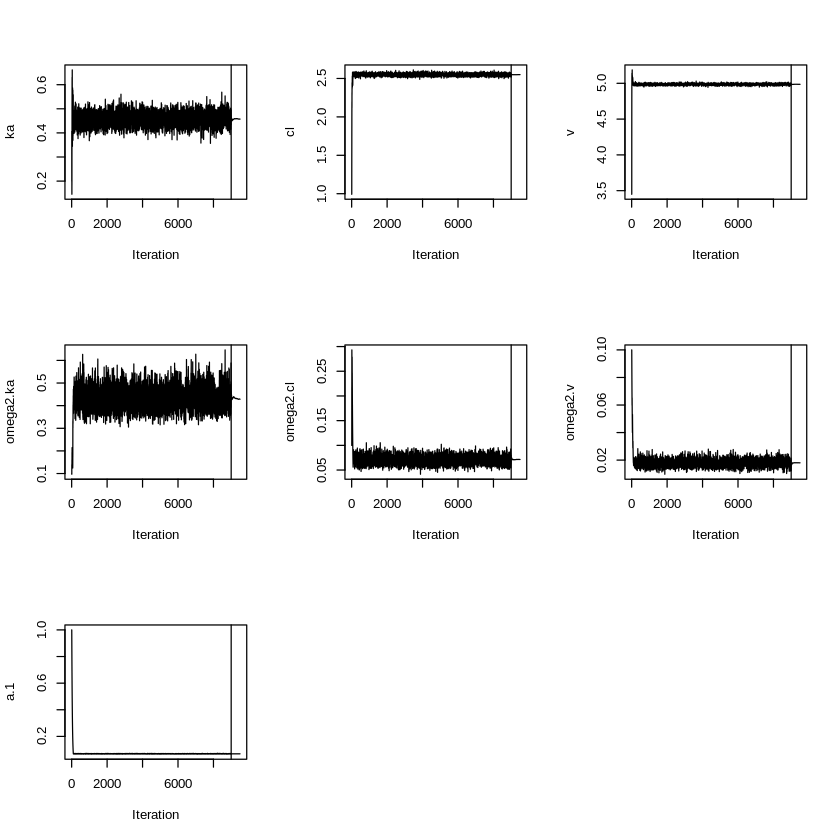

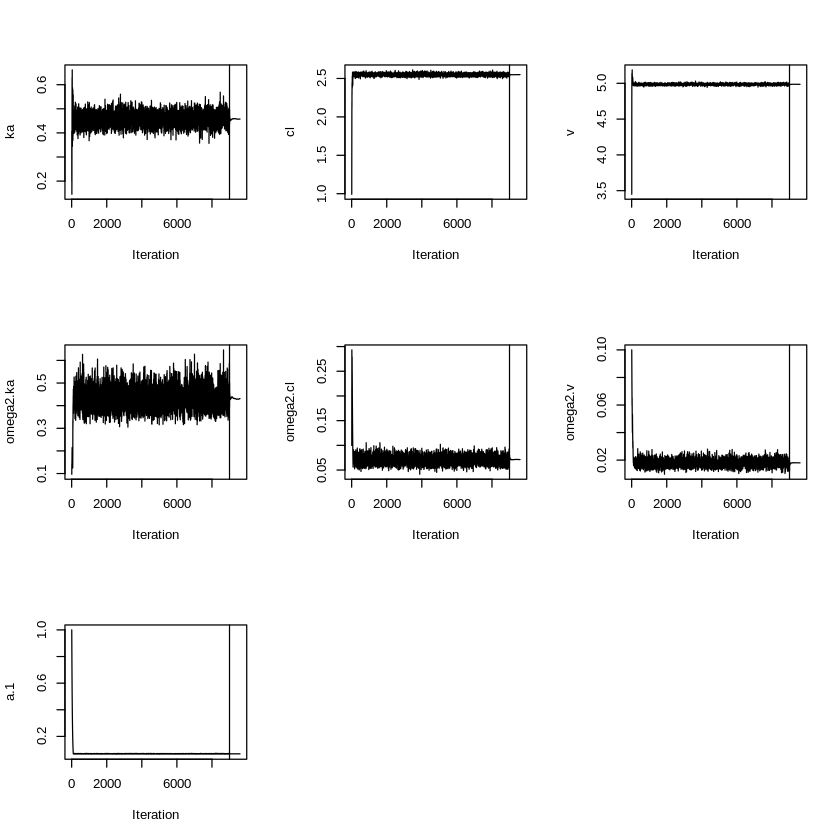

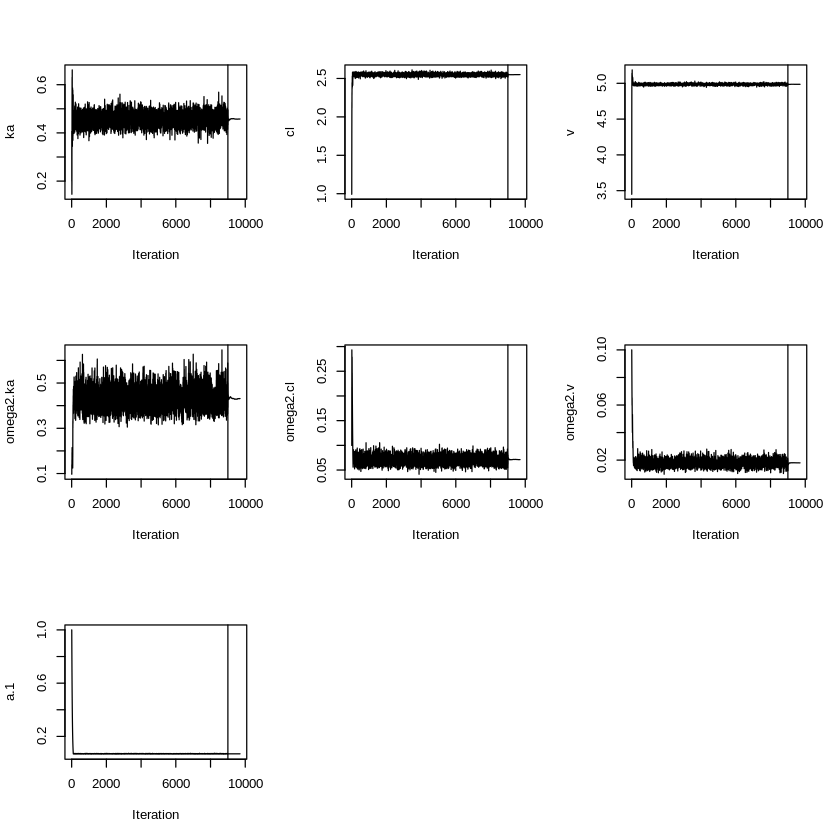

Simulating data using nsim = 1000 simulated datasets
Computing WRES and npde ..
Simulating data using nsim = 1000 simulated datasets
Computing WRES and npde ..
Simulating data using nsim = 1000 simulated datasets
Computing WRES and npde ..


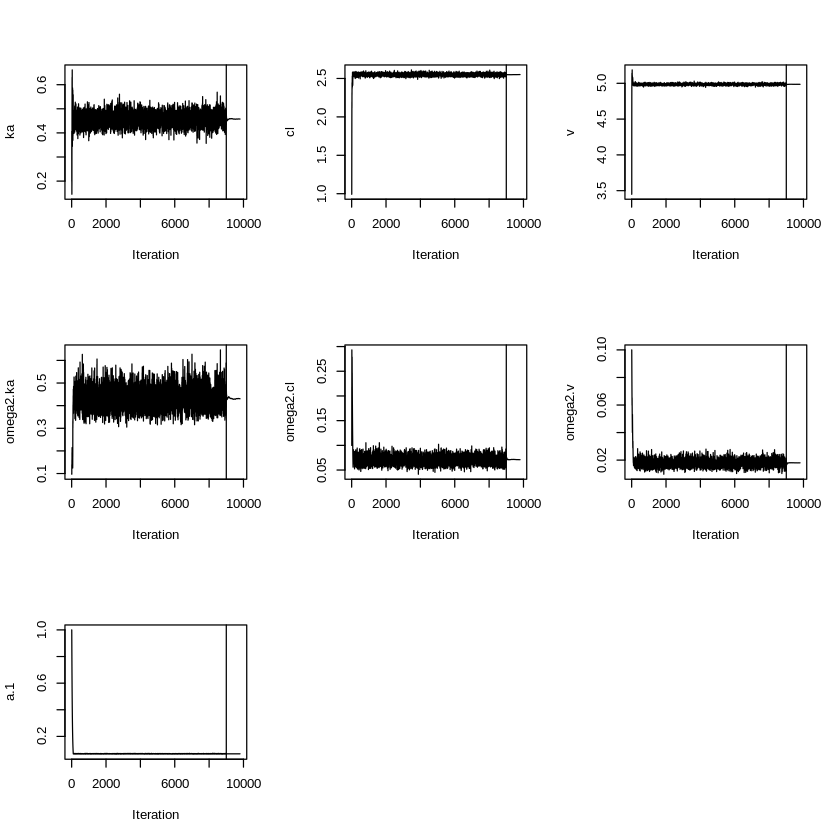


Model fitting completed

Back-transformed parameter estimates:
Ka: 1.58 hr^-1
CL: 12.8 L/hr
V: 146 L

Convergence information:
[1] "fitted"

NCA Analysis Results:
$result
# A tibble: 132 × 6
   ID    start   end PPTESTCD            PPORRES exclude
   <ord> <dbl> <dbl> <chr>                 <dbl> <chr>  
 1 6         0   Inf cmax                 6.44   NA     
 2 6         0   Inf tmax                 1.15   NA     
 3 6         0   Inf tlast               23.8    NA     
 4 6         0   Inf lambda.z             0.0878 NA     
 5 6         0   Inf r.squared            0.998  NA     
 6 6         0   Inf adj.r.squared        0.998  NA     
 7 6         0   Inf lambda.z.time.first  2.03   NA     
 8 6         0   Inf lambda.z.n.points    7      NA     
 9 6         0   Inf clast.pred           0.941  NA     
10 6         0   Inf half.life            7.89   NA     
# ℹ 122 more rows

$data
Formula for concentration:
 CONC ~ TIME | ID
Data are dense PK.
With 12 subjects defined in the 'ID

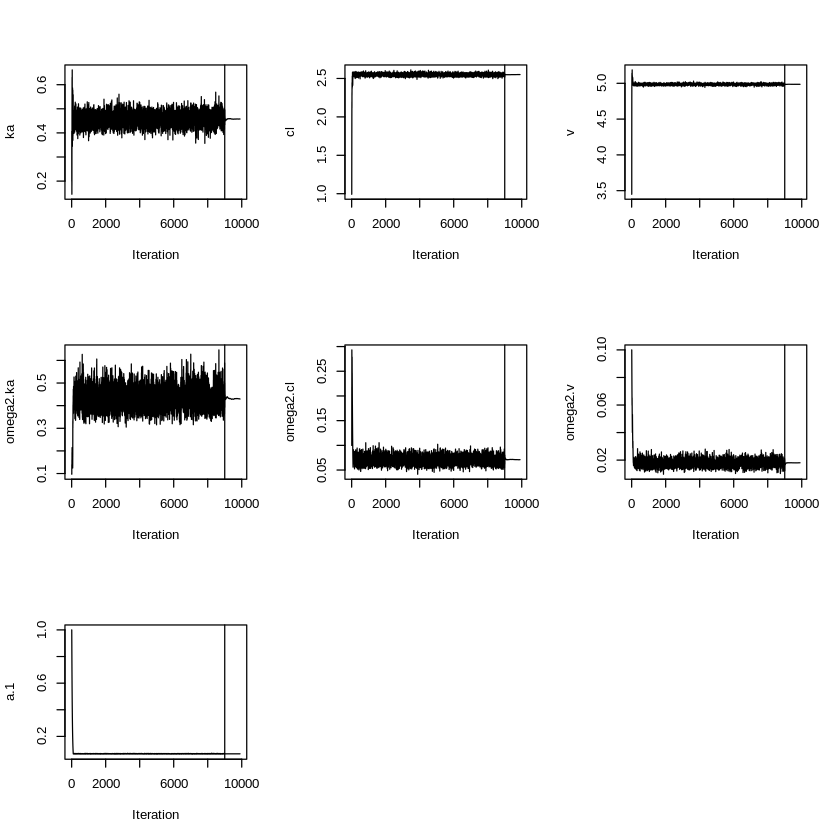

In [5]:
library(saemix)
library(PKNCA)
library(dplyr)

start_time <- proc.time()

# Load and prepare data
data(Theoph)

# Scale the concentrations
Theoph$conc_scaled <- Theoph$conc / 10

# Create the saemix data object
saemix.data <- saemixData(
  name.data = Theoph,
  name.group = "Subject",
  name.predictors = c("Dose", "Time"),
  name.response = "conc_scaled",
  units = list(x="hr", y="mg/L")
)

# Define the structural model
model.function <- function(psi, id, xidep) {
  ka <- exp(psi[id, 1])
  cl <- exp(psi[id, 2])
  v <- exp(psi[id, 3])

  dose <- xidep[, 1] * 32
  time <- xidep[, 2]

  k <- cl/v

  eps <- 1e-3
  ka_adj <- pmax(ka, k + eps)

  conc <- dose/v * ka_adj/(ka_adj - k) * (exp(-k * time) - exp(-ka_adj * time))

  return(conc)
}

# Define the model structure
model <- saemixModel(
  model = model.function,
  description = "One-compartment model with first-order absorption",
  psi0 = matrix(c(log(1.5),  # Ka의 초기값 (log scale)
                 log(2.7),   # CL의 초기값 (log scale)
                 log(31.5)), # V의 초기값 (log scale)
               ncol=3,
               dimnames=list(NULL, c("ka", "cl", "v"))),
  transform.par = c(0, 0, 0),
  covariance.model = matrix(c(1,0,0,
                             0,1,0,
                             0,0,1), ncol=3, byrow=TRUE),
  omega.init = diag(c(0.1, 0.1, 0.1)),  # 개체간 변동성 초기값도 조정
  error.model = "constant"
)

# Fit the model with extended iterations
fit <- saemix(
  model = model,
  data = saemix.data,
  control = list(
    seed = 123456,
    nbiter.saemix = c(9000, 999),
    displayProgress = TRUE,
    save = FALSE,
    print = FALSE
  )
)

# Print model-based analysis results
cat("\nModel fitting completed\n")
cat("\nBack-transformed parameter estimates:\n")
cat("Ka:", format(exp(fit@results@fixed.effects[1]), digits=3), "hr^-1\n")
cat("CL:", format(exp(fit@results@fixed.effects[2]), digits=3), "L/hr\n")
cat("V:", format(exp(fit@results@fixed.effects[3]), digits=3), "L\n")

# Print convergence information
cat("\nConvergence information:\n")
print(fit@results@status)

# Perform NCA analysis
# Prepare concentration data
theoph_conc <- Theoph %>%
  select(Subject, Time, conc) %>%
  rename(ID = Subject,
         CONC = conc,
         TIME = Time)

# Prepare dosing data
theoph_dose <- data.frame(
  ID = unique(Theoph$Subject),
  TIME = 0,
  AMT = 320,
  ROUTE = "Oral"
)

# Define intervals for NCA
intervals <- data.frame(
  start = 0,
  end = Inf,
  cmax = TRUE,
  tmax = TRUE,
  aucinf = TRUE,
  half.life = TRUE,
  lambda.z = TRUE,
  clast = TRUE,
  vz = TRUE
)

# Create NCA data object with both formulas
nca.data <- PKNCAdata(
  data.conc = theoph_conc,
  data.dose = theoph_dose,
  intervals = intervals,
  formula.conc = CONC ~ TIME | ID,
  formula.dose = AMT ~ TIME | ID
)

# Perform NCA calculations
nca.results <- pk.nca(nca.data)

# Print NCA results
cat("\nNCA Analysis Results:\n")
print(nca.results)


# Print total runtime
cat("\nTotal runtime:\n")
print(proc.time() - start_time)